SMA, EMA, MACD, Kalman, Fourier, Wavelet, STL on ARIMA, LSTM, CNN, RNN on different datasets

[Source](https://wire.insiderfinance.io/cracking-the-code-stock-prediction-with-attention-based-lstm-rnn-and-cnn-a-complete-python-2c46e8f25a12)

[Source2](https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba)

[Source3](https://medium.com/@wl8380/mastering-day-trading-with-lstm-predicting-the-next-10-minutes-4e03f89fef3f)

[Optuna](https://optuna.readthedocs.io/en/v2.0.0/reference/generated/optuna.trial.Trial.html), [Link2](https://medium.com/@elsaannacantik/forecasting-with-xgboost-catboost-and-lgbm-51832899dacc), [Link3](https://medium.com/@elsaannacantik/forecasting-with-xgboost-catboost-and-lgbm-51832899dacc)

[Tensorflow example](https://www.tensorflow.org/tutorials/structured_data/time_series#multi-output_models)

#### Import Libraries

In [1]:
# def import_libraries():
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import yfinance as yf
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Attention, Add, LayerNormalization, Layer,LSTM
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import os
# import keras_tuner as kt
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
# import xgboost as xgb
# import lightgbm as lgb
# import catboost as cb
from pykalman import KalmanFilter

from scipy.fft import fft,ifft
from scipy.signal import morlet, cwt
import pywt

from statsmodels.tsa.seasonal import seasonal_decompose, STL , MSTL
from statsforecast import StatsForecast
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.metrics import root_mean_squared_error,mean_squared_error,mean_absolute_percentage_error,r2_score,mean_absolute_error
from tensorflow.keras.layers import LeakyReLU,PReLU,ELU

2025-01-08 11:14:54.099951: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-08 11:14:54.130290: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-08 11:14:54.130318: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-08 11:14:54.131130: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-08 11:14:54.136172: I tensorflow/core/platform/cpu_feature_guar

#### Fetch data

In [2]:
def fetch_stock_data(ticker):
    """
    Fetch Tesla's historical stock data from Yahoo Finance.

    Returns:
        pd.DataFrame: DataFrame containing adjusted close prices indexed by date.
    """
    # Fetch data for Tesla (TSLA) from Yahoo Finance
    ticker = ticker
    start_date = "2010-01-01"
    end_date = "2024-11-17"
    # tesla = yf.download(ticker, start=start_date, end=end_date)
    ticker = yf.Ticker(ticker)
    tesla_data = ticker.history(period="max",interval="1d")
    # tesla.head(4)
    # Return a DataFrame with the adjusted close prices
    # tesla_data = tesla[['Adj Close']].rename(columns={"Adj Close": "adjClose"})
    # tesla_data.index.name = "date"
    return tesla_data
# Fetch Tesla stock data
# tesla_data = fetch_tesla_stock_data()

# Display the first few rows of data
# print(tesla_data.head(10))

In [3]:
tesla_data = fetch_stock_data("TSLA")

#### Filtering functions

##### Comparison plot of Actual(TEST), kalman, fourier, SMA, EMA, MACD, Wavelet

In [4]:
def plot_comparison(actual_test,pred_test, kalman=None, fourier=None, sma=None, ema=None, macd=None, wavelet=None):
# plot dataframe line chart
    global scaler, tesla_data
    plt.figure(figsize=(10, 6))
    # Inverse scale the actual stock prices
    y_raw = scaler.inverse_transform(actual_test.reshape(-1, 1))
    s = tesla_data.index[-len(y_raw):]
    plt.plot(s,y_raw,'black' ,label='Actual')
    plt.plot(s,pred_test,'orange' ,label='Predicted')
    if kalman is not None:
        #read csv file into dataframe
        kalman_df_pred = pd.read_csv(f'predicted_stock_price_kalman.csv',index=False)
        plt.plot(s,kalman_df_pred['kalman_pred'], 'red',label='Kalman')
    if fourier is not None:
        fourier_df_Pred = pd.read_csv(f'predicted_stock_price_fourier.csv',index=False)
        plt.plot(s,fourier_df_Pred['fourier_pred'],'green',label='Fourier')
    if sma is not None:
        sma_df_pred = pd.read_csv(f'predicted_stock_price_SMA.csv',index=False)
        plt.plot(s,sma_df_pred['sma_pred'],'yellow', label='SMA')
    if ema is not None:
        ema_df_pred = pd.read_csv(f'predicted_stock_price_EMA.csv',index=False)
        plt.plot(s,ema_df_pred['ema_pred'],'lightblue' ,label='EMA')
    if macd is not None:
        macd_df_pred = pd.read_csv(f'predicted_stock_price_MACD.csv',index=False)
        plt.plot(s,macd_df_pred['macd_pred'],'magenta' ,label='MACD')
    if wavelet is not None:
        wavelet_df_pred = pd.read_csv(f'predicted_stock_price_wavelet.csv',index=False)
        plt.plot(s,wavelet_df_pred['wavelet_pred'], 'cyan',label='Wavelet')
    plt.title('Actual vs Predicted')
    plt.xlabel('Time')           
    plt.ylabel('Value')
    plt.legend()
    plt.show()


##### Kalman

In [5]:
def kalman_filtering(org_data):
    kf = KalmanFilter(transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=0,
    initial_state_covariance=1,
    observation_covariance=1,
    transition_covariance=0.0001)

    mean, cov = kf.filter(org_data.values)
    mean = pd.Series(mean.flatten(), index=org_data.index)

    # Apply the smoother to the observations
    smoothed_state_means, smoothed_state_covariances = kf.smooth(org_data.values)
    s_mean = pd.Series(smoothed_state_means.flatten(), index=org_data.index)

    plt.plot(org_data.index,org_data.values, 'green', lw=1.5,label='original')
    plt.plot(org_data.index,org_data.values - mean, 'red', lw=1.5,label='kalman filtered')
    plt.plot(org_data.index,org_data.values - s_mean, 'yellow', lw=1.5,label='Kalman smoothed')
    plt.title(f"{filter} -Kalman filtered price fluctuation")
    plt.ylabel("Deviation from the mean ($)")
    plt.xlabel("Years")
    plt.legend()
    #convert to dataframe
    kalman_df = pd.DataFrame({'filtered': org_data.values - mean, 'kal_smoothed':org_data.values - s_mean})    
    return kalman_df

##### Fourier

In [6]:
def fourier_transform(org_data):
    global frequencies,fourier_reconstructed_signal,fft_values,stock_data
    # calcualte the fourier transform
    global threshold
    fft_values = np.fft.fft(org_data)

    # plot the original signal
    plt.figure(figsize=(20,11))
    plt.subplot(3, 1, 1)
    plt.plot(stock_data.index, org_data)
    plt.title(f'{filter} -Original Signal (Time Domain)')
    plt.xlabel('Time [s]')
    plt.ylabel('Price')

    # plot the fourier transform of the simulated sequence
    frequencies = np.fft.fftfreq(len(stock_data.index), d=1)
    print("freq-",frequencies)
    print("amp-",np.abs(fft_values))
    plt.subplot(3, 1, 2)
    plt.plot(frequencies, np.abs(fft_values))
    plt.title(f'{filter} -Fourier Transform (Frequency Domain)')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude')
    

    # Step 2: Filter High Frequencies (Denoising) 
    
    # Filter threshold: keep only low frequencies 
    fft_filtered = np.copy(fft_values) 
    fft_filtered[np.abs(frequencies) > threshold] = 0 # Zero out high frequencies 
    # Reconstruct the Signal (Inverse Fourier Transform) 
    fourier_reconstructed_signal = np.fft.ifft(fft_filtered).real
    
    # Plot Reconstructed Signal 
    plt.subplot(3, 1, 3)   
    plt.plot(stock_data.index, fourier_reconstructed_signal, label="Reconstructed Signal (Low Pass Filter)") 
    plt.xlabel("Time") 
    plt.ylabel("Price") 
    plt.title(f"{filter} -Denoised Time Series") 
    plt.legend() 
    plt.tight_layout()
    plt.show()

    fourier_df = pd.DataFrame({'filtered': fourier_reconstructed_signal}) 
    return fourier_df

In [7]:
#find the lowest positive value in an array frequencies
# def find_lowest_positive_value(frequencies):
#     return min([freq for freq in frequencies if freq > 0])
# find_lowest_positive_value(frequencies)

# Step 3: Identify Dominant Frequencies 
# dominant_freqs = frequencies[np.argsort(np.abs(fft_values))[-5:]]
# dominant_freqs
# dominant_amplitudes = np.abs(fft_values)[np.argsort(np.abs(fft_values))[-5:]] 
# dominant_amplitudes

In [8]:
# Step 4: Add Sinusoidal Features for Forecasting 
# sin_features = [np.sin(2 * np.pi * f * t) for f in dominant_freqs if f > 0] 
# cos_features = [np.cos(2 * np.pi * f * t) for f in dominant_freqs if f > 0] 
# seasonality_features = np.column_stack(sin_features + cos_features) 

# Combine Features with Original Signal 
# time_series_df = pd.DataFrame({ "Time": t, "Original_Signal": signal, "Denoised_Signal": reconstructed_signal }) 
# for i, freq in enumerate(dominant_freqs[dominant_freqs > 0]): 
#     time_series_df[f"Sin_{i}"] = np.sin(2 * np.pi * freq * t) 
#     time_series_df[f"Cos_{i}"] = np.cos(2 * np.pi * freq * t)

##### SMA

In [9]:
def SMA_transform(org_data):
    #transform close price to simple moving average
    global sma_win
    # sma_win = 20
    temp = org_data.rolling(window=sma_win,min_periods=1).mean()
    # print(temp)
    sma_df = pd.DataFrame(temp)
    #rename the column in sma_df   
    sma_df.columns = ['filtered']

    plt.plot(org_data.index,org_data.values, 'green', lw=1.5,label='original')
    plt.plot(org_data.index,sma_df.filtered, 'red', lw=1.5,label='SMA filtered')
    plt.title(f"{filter} -SMA filtered price fluctuation")
    plt.ylabel("SMA values")
    plt.xlabel("Years")
    plt.legend()

    return sma_df

##### EMA

In [10]:
def EMA_transform(org_data):
    #transform close price to simple moving average
    global ema_win
    temp = org_data.ewm(span=ema_win).mean()
    # print(temp)
    ema_df = pd.DataFrame(temp)
    #rename the column in sma_df
    ema_df.columns = ['filtered']

    plt.plot(org_data.index,org_data.values, 'green', lw=1.5,label='original')
    plt.plot(org_data.index,ema_df.filtered, 'red', lw=1.5,label='EMA filtered')
    plt.title(f"{filter} -EMA filtered price fluctuation")
    plt.ylabel("EMA values")
    plt.xlabel("Years")
    plt.legend()

    return ema_df

##### MACD

In [11]:
def MACD_transform(org_data):
    # Create MACD
    d_26ema = org_data.ewm(span=26).mean()
    d_12ema = org_data.ewm(span=12).mean()
    d_MACD = d_12ema-d_26ema
    macd_df = pd.DataFrame({'filtered': d_MACD})
    #rename the column in sma_df
    # macd_df.columns = ['filtered']

    plt.plot(org_data.index,org_data.values, 'green', lw=1.5,label='original')
    plt.plot(org_data.index,macd_df.filtered, 'red', lw=1.5,label='MACD filtered')
    plt.title(f"{filter} -MACD filtered price fluctuation")
    plt.ylabel("MACD values")
    plt.xlabel("Years")
    plt.legend()

    return macd_df
#calculate MACD

##### Wavelet

In [12]:
def wavelet_deconstruction_plot(data, wavelet_name):
    global details, approximation, wavelet
    # Step 1: Generate Synthetic Time Series Data 
    # np.random.seed(42) 
    # t = np.linspace(0, 10, 1024) 
    # Time vector (must be a power of 2 for DWT) 
    # signal = 5 * np.sin(2 * np.pi * 1 * t) + 2 * np.sin(2 * np.pi * 0.25 * t) + np.random.normal(0, 0.5, len(t)) 
    # Plot Original Signal 
    # plt.figure(figsize=(10, 4)) 
    # print('HEREEEEEEEEE')
    # plt.plot(data.index, data['Close'].values, label="Original Signal") 
    # plt.xlabel("Time") 
    # plt.ylabel("Close price") 
    # plt.title("Time Series Data") 
    # plt.legend() 
    # plt.show() 
    # Step 2: Perform Discrete Wavelet Transform (DWT) 
    wavelet = wavelet_name # 'db4' 
#Different wavelet families can be tested
    # Daubechies wavelet
    max_level = pywt.dwt_max_level(len(data['Close'].values), pywt.Wavelet(wavelet).dec_len) 
    # Max decomposition level 
    coeffs = pywt.wavedec(data['Close'].values, wavelet, level=max_level)

    # Perform wavelet decomposition 
    approximation = coeffs[0] 
    # Approximation coefficients (low-frequency) 
    details = coeffs[1:] 
    # Detail coefficients (high-frequency) 
    print("length of details-",len(details))
    # Step 3: Visualize Wavelet Decomposition 
    
    # plt.figure(figsize=(20, 15)) 
    # plt.subplot(len(details)+1, 1, 1) 
    # plt.plot(approximation, label="Approximation (Low Frequencies)") 
    # plt.title("Approximation Coefficients (A)") 
    # plt.legend() 
    # for i, detail in enumerate(details, 1): 
    #     plt.subplot(len(details)+1, 1, i + 1) 
    #     plt.plot(detail, label=f"Detail Coefficients (D{i})") 
    #     plt.title(f"Detail Coefficients (D{i})") 
    #     plt.legend() 
    # plt.tight_layout() 
    # plt.show() 

In [13]:
def wavelet_denoising(data,detail_index,approx_enable=True,threshold_enable=False,thresh_value=0):
    global details, approximation, wavelet,wavelet_df
    # Step 4: Reconstruct Signal (Inverse Wavelet Transform) 
    # Reconstruct only the approximation (low-frequency content) 
    # if not detail_index in range(len(details)):
    #     detail_index = 0
    #     print("Detail_index",detail_index)
    
    print("Threshold enabled-",threshold_enable)
    if not threshold_enable:
        if approx_enable:
            reconstructed_signal_low = pywt.waverec([approximation] + [np.zeros_like(d) for d in details], wavelet) 
            # Reconstruct signal with selective details (e.g., smooth trends + some details) 
        else:
        # Different details coefficients can be tested
            selective_coeffs = [approximation] + [details[i] if i == detail_index else np.zeros_like(d) for i, d in enumerate(details)] 
            reconstructed_signal_selective = pywt.waverec(selective_coeffs, wavelet) 

        # Plot Original vs Reconstructed Signal 

        plt.figure(figsize=(12, 6)) 
        plt.plot(data.index, data['Close'].values, label="Original Signal", alpha=0.5) 
        if approx_enable:
            plt.plot(data.index[:len(reconstructed_signal_low)], reconstructed_signal_low, label="Low Frequencies (Approximation)", color='red') 
        else:
            plt.plot(data.index[:len(reconstructed_signal_selective)], reconstructed_signal_selective, label="Selective Reconstruction", color='green') 
        plt.xlabel("Time") 
        plt.ylabel("Close Price") 
        plt.title("Signal Reconstruction from Wavelet Coefficients") 
        plt.legend() 
        plt.show()

    if threshold_enable:
        threshold = thresh_value
        # Adjust based on noise level 
        thresholded_details = [pywt.threshold(d, threshold, mode='soft') for d in details] 

        # Reconstruct the denoised signal 
        denoised_coeffs = [approximation] + thresholded_details 
        denoised_signal = pywt.waverec(denoised_coeffs, wavelet) 

        # Plot Denoised Signal 
        plt.figure(figsize=(10, 4)) 
        plt.plot(data.index, data['Close'].values, label="Original Signal", alpha=0.5) 
        plt.plot(data.index[:len(denoised_signal)], denoised_signal, label="Denoised Signal", color='orange') 
        plt.xlabel("Time") 
        plt.ylabel("Amplitude") 
        plt.title("Denoised Signal Using Wavelet Transform") 
        plt.legend() 
        plt.show()

    if threshold_enable:
        wavelet_df = pd.DataFrame({'filtered': denoised_signal})
        #rename the column in sma_df
        # print(wavelet_df)
        return wavelet_df
    else:
        if approx_enable:
            wavelet_df = pd.DataFrame({'filtered': reconstructed_signal_low})
            # print(wavelet_df)
            return wavelet_df
        else:
            wavelet_df = pd.DataFrame({'filtered': reconstructed_signal_selective})
            # print(wavelet_df)
            return wavelet_df

In [14]:
def wavelet_transform(org_data,detail_index, wavelet_name,approx_enable=True,threshold_enable=False,thresh_value=0):
    wavelet_deconstruction_plot(org_data, wavelet_name)
    ret_df = wavelet_denoising(org_data,detail_index,approx_enable,threshold_enable,thresh_value)
    return ret_df

##### STL

In [15]:
def plot_components_STL(result,org):

  df = pd.concat([result.observed, result.trend, result.seasonal, result.resid], axis=1)
  df = df.rename(columns={0:'Original Data', 'season':'seasonal','observed':'Original Data'})
  components = df.columns
  rows = len(components)
  fig = make_subplots(rows=rows, cols=1, shared_xaxes=True, subplot_titles = [i for i in components])
  #adjust size of plot
  # fig.update_layout(height=600, width=800)
# Plot original data
  for i, col in enumerate(components):
    fig.add_trace(go.Scatter(x=org.index, y=df[col], mode='lines', name=col), row=i+1, col=1)

  # Update layout
  fig.update_layout(
      title='Time Series Decomposition',
      xaxis_title='Time',
      height=800,
      width=600
  )

  fig.show()

In [16]:
#Assuming period of 1 day
def stl_transform(tesla_data,period):
    # period=[7,14,30,90,120,150,180,240,270,300,330,360,730,1080,1460,1825,2190,2555] 
    # period=[7]
    stl = STL(tesla_data['Close'], period=period)
    result_stl = stl.fit()

    # Plot the results
    plot_components_STL(result_stl,tesla_data)
    stl_df = pd.DataFrame({'filtered':result_stl.observed - result_stl.resid})
    return stl_df

##### MSTL

In [17]:
def plot_components(result,org):
  
  df = pd.concat([result.observed, result.trend, result.seasonal, result.resid], axis=1)
  df = df.rename(columns={0:'Original Data', 'season':'seasonal','observed':'Original Data'})
  components = df.columns
  rows = len(components)
  fig = make_subplots(rows=rows, cols=1, shared_xaxes=True, subplot_titles = [i for i in components])
  
# Plot original data
  for i, col in enumerate(components):
    fig.add_trace(go.Scatter(x=org.index, y=df[col], mode='lines', name=col), row=i+1, col=1)


  # Update layout
  fig.update_layout(
      title='Time Series Decomposition',
      xaxis_title='Time',
      height=1200,
      width=1200
  )

  fig.show()

In [18]:
#code to calculate variance 
#High variance indicate the presence of noise
# def calculate_variance(data):
#     mean = sum(data) / len(data)
#     variance = sum((x - mean) ** 2 for x in data) / len(data)
#     return variance
                                                        

In [19]:
# from statsmodels.tsa.stattools import adfuller
# def Augmented_Dickey_Fuller_Test_func(series):
#     # print (f'Dickey-Fuller test results for columns: {column_name}')
#     dftest = adfuller(series, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of observations used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print (dfoutput)
#     if dftest[1] <= 0.05:
#         print("Conclusion:====>")
#         print("Reject the null hypothesis")
#         print("The data is stationary")
#     else:
#         print("Conclusion:====>")
#         print("The null hypothesis cannot be rejected")
#         print("The data is not stationary")

In [20]:
# result_mstl.observed
# Augmented_Dickey_Fuller_Test_func(result_mstl.resid)
# calculate_variance(result_mstl.resid)

In [21]:
#Assuming period of 1 day
def mstl_transform(tesla_data,period):
    # period=[7,14,30,90,120,150,180,240,270,300,330,360,730,1080,1460,1825,2190,2555] 
    # period=[7]
    mstl = MSTL(tesla_data['Close'], periods=period)
    result_mstl = mstl.fit()

    # Plot the results
    plot_components(result_mstl,tesla_data)
    mstl_df = pd.DataFrame({'filtered':result_mstl.observed - result_mstl.resid})
    return mstl_df

##### Proposed Method for denoising

#### Create sequences

In [22]:
# def create_sequences(data, window_size, prediction_steps):
#     X = []
#     y = []
#     for i in range(window_size, len(data) - prediction_steps):
#         X.append(data[i-window_size:i, 0]) # input sequence
#         y.append(data[i, 0]) # target value (price at the next timestep)
#     return np.array(X), np.array(y)

def create_sequences(data, window_size, prediction_steps=10):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), 0]) # input sequence
        y.append(data[i + window_size, 0]) # target value (price at the next timestep)
    return np.array(X), np.array(y)

#### Model Definition

In [23]:
# Define a custom attention layer
class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[2], input_shape[2]), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(input_shape[1],), initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        q = tf.matmul(inputs, self.W)
        a = tf.matmul(q, inputs, transpose_b=True)
        attention_weights = tf.nn.softmax(a, axis=-1)
        return tf.matmul(attention_weights, inputs)

# LSTM model with attention and early stopping
def build_lstm_model_with_attention(input_shape,u,d,optimizer_name,no_of_layers,loss_func,actv_name):
    model = Sequential()
    model.add(LSTM(units=u, return_sequences=True, input_shape=input_shape,activation=actv_name))
    model.add(Dropout(d))

    # Attention layer
    model.add(AttentionLayer())
    model.add(LayerNormalization())

    for i in range(no_of_layers):
        model.add(LSTM(units=u, return_sequences=True,activation=actv_name))
        model.add(Dropout(d))

    model.add(LSTM(units=u, return_sequences=False,activation=actv_name))
    model.add(Dropout(d))
    model.add(Dense(units=1,activation='sigmoid'))  # Output layer for prediction

    model.compile(optimizer=optimizer_name, loss=loss_func)
    return model

# LSTM model without attention and early stopping
def build_lstm_model(input_shape,u,d,optimizer_name,no_of_layers,loss_func,actv_name):
    model = Sequential()
    model.add(LSTM(units=u, return_sequences=True, input_shape=input_shape))#,activation=actv_name))
    model.add(Dropout(d))
    for i in range(no_of_layers):
        model.add(LSTM(units=u, return_sequences=True))#,activation=actv_name))
        model.add(Dropout(d))
    # Attention layer
    # model.add(AttentionLayer())
    # model.add(LayerNormalization())

    model.add(LSTM(units=u, return_sequences=False))#,activation=actv_name))
    model.add(Dropout(d))
    # Output layer for prediction
    model.add(Dense(units=1))  #activation='sigmoid'

    # if loss_func == 'huber_loss':
    #     loss_func = tf.keras.losses.huber_loss
    model.compile(optimizer=optimizer_name, loss=loss_func)
    return model

#### Build Model

In [24]:
def build_model(window_size,d,u,split_size,optimizer_option,num_of_layers,loss_options,actv_option):
    global scaler_X,scaler_Y,raw_data,scaled_data,attn,X_train, X_test, y_train, y_test,scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
    X, y = create_sequences(raw_data, window_size)
    # Reshape input data to be in the shape [samples, time steps, features]
    # X = X.reshape(X.shape[0], X.shape[1], 1)
    # Split the data into training and testing sets
    X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=split_size, shuffle=False)
    # print(f"Training data shape: {X_train.shape}")
    # print(f"Testing data shape: {X_test.shape}")
    X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, shuffle=False)
    print("unscaled X_train size",X_train.shape)
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_Y = MinMaxScaler(feature_range=(0, 1))

    scaled_train_X = scaler_X.fit_transform(X_train)
    scaled_val_X = scaler_X.transform(X_val)
    scaled_test_X = scaler_X.transform(X_test)

    scaled_train_Y = scaler_Y.fit_transform(y_train.reshape(-1,1)).flatten()
    scaled_val_Y = scaler_Y.transform(y_val.reshape(-1,1)).flatten()
    scaled_test_Y = scaler_Y.transform(y_test.reshape(-1,1)).flatten()

    scaled_train_X = scaled_train_X.reshape(scaled_train_X.shape[0], scaled_train_X.shape[1], 1)
    scaled_val_X = scaled_val_X.reshape(scaled_val_X.shape[0], scaled_val_X.shape[1], 1)
    scaled_test_X = scaled_test_X.reshape(scaled_test_X.shape[0], scaled_test_X.shape[1], 1)

    print("scaled X_train size",scaled_train_X.shape,scaled_train_Y.shape)
    if attn:
        model = build_lstm_model_with_attention(scaled_train_X.shape[1:],u,d,optimizer_option,num_of_layers,loss_options,actv_option)
        # Implement EarlyStopping to prevent overfitting
    else:
        # Build the RNN model
        model = build_lstm_model(scaled_train_X.shape[1:],u,d,optimizer_option,num_of_layers,loss_options,actv_option)
    return model

#### Hyperparameter Optimization

In [25]:
def objective_lstm(trial):
    global  X_train,y_train,X_test,y_test,history, model, scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
    win_size = trial.suggest_int('win_size', 10, 100,step=10, log=False)
    epoch_no = trial.suggest_int('epoch_no', 10, 100,step=10, log=False)
    split_size = trial.suggest_float('split_size', 0.2, 0.5,step=0.1,log=False)
    # attn = trial.suggest_categorical('attn', [True, False])
    units = trial.suggest_int('units', 30, 70,step=10,log=False)
    drop_out = trial.suggest_float('drop_out', 0.2, 0.5,step=0.1,log=False)
    optimizer_options = trial.suggest_categorical('optimizer_name', ['adam', 'rmsprop', 'sgd', 'adagrad', 'adadelta', 'adamax', 'nadam'])
    num_of_layers = trial.suggest_int('no_layers', 2, 9,step=2, log=False)
    loss_options = trial.suggest_categorical('loss_fn_name', ['huber','mean_squared_error', 'mean_squared_logarithmic_error','log_cosh'])
    activation_option = trial.suggest_categorical('activation_name', ['relu', 'gelu','selu'])

    model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_options,activation_option)
    # build_rnn_model(input_shape,u,d)
    # model.compile(optimizer='adam', loss='mean_squared_error')


    # Implement EarlyStopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model with EarlyStopping and 50 epochs

    history = model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y),verbose=1, shuffle=False, callbacks=[early_stopping])
    loss = history.history['val_loss']
    print("loss value",loss)
    return min(loss)

#### Evaluate model

In [26]:
# Evaluate the model
def evaluate_model(model, x_data,y_data,filter):
    global predicted_stock_price,scaler_X,scaler_Y,mape, mae, rmse, r2,y_raw,predicted_stock_price_raw
    predicted_stock_price = model.predict(x_data)
    predicted_stock_price_raw = scaler_Y.inverse_transform(predicted_stock_price)

    # Inverse scale the actual stock prices
    y_raw = scaler_Y.inverse_transform(y_data.reshape(-1, 1))
    #save predicted value in a dataframe
    predicted_stock_price_raw = predicted_stock_price_raw.flatten()
    pred_df = pd.DataFrame({f"{filter}_pred":predicted_stock_price_raw})
    pred_df.to_csv(f'LSTM_predicted_stock_price_{filter}.csv', index=False)

    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_raw, predicted_stock_price_raw)
    #calculate MAE, RMSE, R2
    mae = mean_absolute_error(y_raw, predicted_stock_price_raw)
    rmse = root_mean_squared_error(y_raw, predicted_stock_price_raw)
    r2 = r2_score(y_raw, predicted_stock_price_raw)
    #save
    print(f"**********************{filter} filter***************************")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    #print mae, rmse and r2
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"R2 Score: {r2:.2f}")
    # return mape, mae, rmse, r2
    # return rmse




#### Plot simple & interative graph

In [27]:
def plot_simple(df,split,title,ticker,y_actual, predicted_stock_price_raw,width=10,height=6):
    # Plot the results
    global window_size,y_train
    if split == 'train':
        s = df.index[window_size:window_size+len(y_actual)]
    else:
        s = df.index[-len(y_actual):]
    #plot date in x axis
    plt.figure(figsize=(width,height))

    plt.figure(figsize=(width, height))
    plt.plot(s,y_actual, label=f"Actual {ticker} Stock Price", color='blue')
    plt.plot(s,predicted_stock_price_raw, label=f"Predicted {ticker} Stock Price", color='red')
    plt.title(title, fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Raw Stock Price (USD)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_interative(df,split,title,tick,y_actual,y_pred):
    global y_train,window_size
    if split == 'train':
        s = df.index[window_size:window_size+len(y_actual)]
    else:
        s = df.index[-len(y_actual):]
    fig = go.Figure(data=[
           go.Scatter(x=s, y=y_actual.flatten(), mode='lines', name='Actual'),
           go.Scatter(x=s, y=y_pred.flatten(), mode='lines', name='Predicted')])
    fig.update_layout(title=title+f'-{tick}', xaxis_title='Time', yaxis_title='Close price')
    fig.show()

#### Original data Scaled

In [28]:
def org_data_split(org_data,split_size,window_size):
    global Org_X_train,Org_y_train,Org_X_val,Org_y_val,Org_X_test,Org_y_test
    Org_X, Org_y = create_sequences(org_data, window_size)
    Org_X_train, Org_X_rest, Org_y_train, Org_y_rest = train_test_split(Org_X, Org_y, test_size=split_size, shuffle=False)
    Org_X_val, Org_X_test, Org_y_val, Org_y_test = train_test_split(Org_X_rest, Org_y_rest, test_size=0.5, shuffle=False)


#### Compile all functions

In [29]:
# def abc(tick,ws,ps,u,d,n_t,filter,epoch_no=70,batch_size_no=32,split_size=0.2,attn=False):
def abc(file_name,tick,n_t,filter,study_name,tuning,detail_index=0,wavelet_name="db4",approx_enable=True,threshold_enable=False,thresh_value=0,mstl_period=[7],stl_period=7):
    global model,study_lstm, window_size,stock_data, raw_data,scaler, scaled_data, X, y,X_train, X_test, y_train, y_test,history,model
    # import_libraries()


# stock_data = fetch_stock_data(tick)
    if filter == 'hybrid':
        hybrid_df = pd.read_csv('AKAM_autoencoder_data.csv',index_col=0)
        stock_data = hybrid_df
    else:
        # stock_data = fetch_stock_data(tick)
        if os.path.isfile(file_name):
            print(f"The file '{file_name}' does exist.")
            stock_data = pd.read_csv(file_name, index_col=0)
                # print(content)    
        else:
            print(f"The file '{file_name}' does not exist.")
            stock_data = fetch_stock_data(tick)
            stock_data.to_csv(file_name,index=True)


    if filter=="kalman":
        filtered_df = kalman_filtering(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'fourier':
        filtered_df = fourier_transform(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'SMA':
        filtered_df = SMA_transform(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'EMA':
        filtered_df = EMA_transform(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'MACD':
        filtered_df = MACD_transform(stock_data['Close'])
        print("Filter Name-",filter)
    elif filter == 'wavelet':
        filtered_df = wavelet_transform(stock_data,detail_index, wavelet_name,approx_enable,threshold_enable,thresh_value)
        print("Filter Name-",filter)
    elif filter == 'STL':
        filtered_df = stl_transform(stock_data,stl_period)
    elif filter == 'mstl':
        filtered_df = mstl_transform(stock_data,mstl_period)
    elif filter == 'hybrid':
        filtered_df = hybrid_df[['filtered_akam']].values
    else:
        pass

    # Fetch Tesla stock data
    # Define the window size and prediction time
    # window_size = ws
    # prediction_steps = ps
    if filter == 'na':
        raw_data = stock_data[['Close']].values
    elif filter == 'hybrid':
        raw_data = filtered_df
    else:
        raw_data = filtered_df[['filtered']].values
    # Normalize the data using MinMaxScaler
    # scaler = MinMaxScaler(feature_range=(0, 1))
    # scaled_data = scaler.fit_transform(raw_data)


    # Create sequences for the model

    # build_model(window_size,d,u,attn,ps=10)
    # Run Hyperband tuning with Optuna for each model
    if tuning:
        study_lstm = optuna.create_study(direction="minimize",sampler=TPESampler(),study_name=f'{study_name}')#, pruner=optuna.pruners.HyperbandPruner())

        # Optimize each study
        study_lstm.optimize(objective_lstm, n_trials=n_t)

        best_trial = study_lstm.best_trial
        print(f'Best parameters: for {filter} filter', best_trial.params)
        print(f'Best value: for {filter} filter', best_trial.value)
        for key, value in best_trial.params.items():
            print("    {}: {}".format(key, value))
        return best_trial.params, best_trial.value

    # if attn:
    #     a = "attention"
    # else:
    #     a = ""
    # print("****************************TEST************************************")
    # evaluate_model(model, X_test,y_test)
    # plot_simple(stock_data,"test",f'Stock Price(Test) Prediction with rnn({a})',tick,y_raw, predicted_stock_price_raw,10,6)
    # plot_interative(stock_data,"test",f'Stock Price(Test) Prediction with rnn({a})',tick,y_raw, predicted_stock_price_raw)

    # print("*****************************TRAIN***********************************")
    # evaluate_model(model, X_train,y_train)
    # plot_simple(stock_data,"train",f'Stock Price(Train) Prediction with rnn({a})',tick,y_raw, predicted_stock_price_raw,10,6)
    # plot_interative(stock_data,"train",f'Stock Price(Train) Prediction with rnn({a})',tick,y_raw, predicted_stock_price_raw)

#### AKAM - Original

##### Start Tuning

In [32]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=50
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="na" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="Original"
stock_file_name=f"{ticker}_data.csv"
tuning=True
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

[I 2024-12-30 17:50:38,838] A new study created in memory with name: Original


The file 'AKAM_data.csv' does exist.
unscaled X_train size (3150, 30)
scaled X_train size (3150, 30, 1) (3150,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(
2024-12-30 17:50:38.956967: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 17:50:38.959858: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-12-30 17:50:38.959884: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2024-12-30 17:50:38.959943: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to com

Epoch 1/70


2024-12-30 17:50:48.928080: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 17:50:48.928165: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 17:50:48.928199: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 17:50:48.929849: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to com

99/99 [==============================] - 16s 57ms/step - loss: 0.0113 - val_loss: 0.0092
Epoch 2/70
99/99 [==============================] - 3s 34ms/step - loss: 0.0092 - val_loss: 0.0073
Epoch 3/70
99/99 [==============================] - 3s 34ms/step - loss: 0.0091 - val_loss: 0.0069
Epoch 4/70
99/99 [==============================] - 3s 34ms/step - loss: 0.0091 - val_loss: 0.0068
Epoch 5/70
99/99 [==============================] - 3s 34ms/step - loss: 0.0090 - val_loss: 0.0067
Epoch 6/70
99/99 [==============================] - 3s 34ms/step - loss: 0.0091 - val_loss: 0.0067
Epoch 7/70
99/99 [==============================] - 3s 34ms/step - loss: 0.0090 - val_loss: 0.0067
Epoch 8/70
99/99 [==============================] - 3s 33ms/step - loss: 0.0090 - val_loss: 0.0066
Epoch 9/70
99/99 [==============================] - 3s 34ms/step - loss: 0.0090 - val_loss: 0.0066
Epoch 10/70
99/99 [==============================] - 3s 34ms/step - loss: 0.0090 - val_loss: 0.0067
Epoch 11/70
99/99 [

[I 2024-12-30 17:52:42,243] Trial 0 finished with value: 0.0065625631250441074 and parameters: {'win_size': 30, 'epoch_no': 70, 'split_size': 0.5, 'units': 40, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adagrad', 'no_layers': 8, 'loss_fn_name': 'mean_squared_logarithmic_error', 'activation_name': 'selu'}. Best is trial 0 with value: 0.0065625631250441074.


loss value [0.009246263653039932, 0.007315381430089474, 0.006893127225339413, 0.0067691621370613575, 0.006660217419266701, 0.0066832732409238815, 0.006685306783765554, 0.006630368996411562, 0.006620702799409628, 0.006651638075709343, 0.006673760246485472, 0.006682069506496191, 0.0066085862927138805, 0.00662637734785676, 0.006672256626188755, 0.006671943701803684, 0.006659285631030798, 0.006638317368924618, 0.006603265646845102, 0.006622857414186001, 0.006606860551983118, 0.006597867235541344, 0.0065625631250441074, 0.006589190103113651, 0.0065887621603906155, 0.00663285655900836, 0.0065985554829239845, 0.00660456158220768, 0.0066075255163013935, 0.006598791107535362, 0.006617447827011347, 0.0066032325848937035, 0.006614765617996454]
unscaled X_train size (3150, 30)
scaled X_train size (3150, 30, 1) (3150,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/50


2024-12-30 17:52:50.918859: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 17:52:50.922623: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-30 17:52:51.014566: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 17:52:51.076459: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or inval

99/99 [==============================] - 13s 51ms/step - loss: 0.0091 - val_loss: 0.0037
Epoch 2/50
99/99 [==============================] - 3s 28ms/step - loss: 0.0079 - val_loss: 0.0032
Epoch 3/50
99/99 [==============================] - 3s 27ms/step - loss: 0.0065 - val_loss: 0.0013
Epoch 4/50
99/99 [==============================] - 3s 28ms/step - loss: 0.0025 - val_loss: 1.6245e-04
Epoch 5/50
99/99 [==============================] - 3s 28ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 6/50
99/99 [==============================] - 3s 27ms/step - loss: 0.0028 - val_loss: 1.4302e-04
Epoch 7/50
99/99 [==============================] - 3s 27ms/step - loss: 0.0019 - val_loss: 9.8748e-04
Epoch 8/50
99/99 [==============================] - 3s 27ms/step - loss: 0.0020 - val_loss: 1.2323e-04
Epoch 9/50
99/99 [==============================] - 3s 26ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 10/50
99/99 [==============================] - 3s 28ms/step - loss: 0.0023 - val_loss: 1.2466e-04

[I 2024-12-30 17:54:55,610] Trial 1 finished with value: 0.00011460665700724348 and parameters: {'win_size': 30, 'epoch_no': 50, 'split_size': 0.5, 'units': 70, 'drop_out': 0.5, 'optimizer_name': 'adamax', 'no_layers': 6, 'loss_fn_name': 'huber', 'activation_name': 'selu'}. Best is trial 1 with value: 0.00011460665700724348.


loss value [0.0036537020932883024, 0.0031515841837972403, 0.0013473895378410816, 0.00016244793368969113, 0.0013288167538121343, 0.00014302342606242746, 0.0009874762035906315, 0.00012323020200710744, 0.0010905322851613164, 0.00012465991312637925, 0.001282006036490202, 0.00012931694800499827, 0.001284621306695044, 0.0001264206221094355, 0.0011760913766920567, 0.00012425050954334438, 0.0011717427987605333, 0.0001230538182426244, 0.0012425326276570559, 0.00013019835751038045, 0.001410069060511887, 0.00012583662464749068, 0.0012039919383823872, 0.00012148047244409099, 0.001417005667462945, 0.000126062601339072, 0.0009860796853899956, 0.0001297368435189128, 0.0012902942253276706, 0.0001174148274003528, 0.0013875854201614857, 0.00013030864647589624, 0.0012633242877200246, 0.00011460665700724348, 0.0011461820686236024, 0.00012741335376631469, 0.0012929773656651378, 0.00011577594705158845, 0.0011684580240398645, 0.00012855192471761256, 0.001287394785322249, 0.00012558574962895364, 0.00134556950

/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/100


2024-12-30 17:55:03.960131: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 17:55:04.071745: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 17:55:04.083779: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



138/138 [==============================] - 13s 41ms/step - loss: 0.0077 - val_loss: 0.0034
Epoch 2/100
138/138 [==============================] - 4s 27ms/step - loss: 0.0046 - val_loss: 0.0014
Epoch 3/100
138/138 [==============================] - 4s 27ms/step - loss: 0.0035 - val_loss: 6.6282e-04
Epoch 4/100
138/138 [==============================] - 4s 28ms/step - loss: 0.0022 - val_loss: 5.6787e-04
Epoch 5/100
138/138 [==============================] - 4s 27ms/step - loss: 0.0018 - val_loss: 7.7770e-04
Epoch 6/100
138/138 [==============================] - 4s 28ms/step - loss: 0.0021 - val_loss: 7.5198e-04
Epoch 7/100
138/138 [==============================] - 4s 28ms/step - loss: 0.0019 - val_loss: 7.1853e-04
Epoch 8/100
138/138 [==============================] - 4s 27ms/step - loss: 0.0020 - val_loss: 6.7527e-04
Epoch 9/100
138/138 [==============================] - 4s 28ms/step - loss: 0.0021 - val_loss: 6.4522e-04
Epoch 10/100
138/138 [==============================] - 4s 28ms/s

[I 2024-12-30 17:57:14,855] Trial 2 finished with value: 0.00032714655390009284 and parameters: {'win_size': 40, 'epoch_no': 100, 'split_size': 0.30000000000000004, 'units': 40, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adamax', 'no_layers': 6, 'loss_fn_name': 'mean_squared_logarithmic_error', 'activation_name': 'gelu'}. Best is trial 1 with value: 0.00011460665700724348.


loss value [0.0033655378501862288, 0.0014187146443873644, 0.0006628244882449508, 0.0005678653251379728, 0.000777699111495167, 0.0007519773207604885, 0.0007185274735093117, 0.0006752686458639801, 0.0006452227244153619, 0.000662315811496228, 0.0005852479953318834, 0.0006443521124310791, 0.0006079204031266272, 0.0005591801600530744, 0.0006210082792676985, 0.0005535624222829938, 0.0004200171388220042, 0.0005698358290828764, 0.00040824353345669806, 0.0004664854786824435, 0.00048184514162130654, 0.000432176748290658, 0.0003299579257145524, 0.00032714655390009284, 0.00047418411122635007, 0.00036592333344742656, 0.000430917163612321, 0.00035539790405891836, 0.0004646159359253943, 0.0004469137638807297, 0.0003475658595561981, 0.00045188216608949006, 0.0005811738665215671, 0.0004385785141494125]
unscaled X_train size (3768, 50)
scaled X_train size (3768, 50, 1) (3768,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/80


2024-12-30 17:57:24.670395: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 17:57:24.820556: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 17:57:24.948762: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 17:57:25.139456: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

  1/118 [..............................] - ETA: 23:27 - loss: 0.6749

2024-12-30 17:57:28.044900: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 17:57:28.195262: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



118/118 [==============================] - 18s 51ms/step - loss: 0.0128 - val_loss: 0.0011
Epoch 2/80
118/118 [==============================] - 4s 33ms/step - loss: 0.0087 - val_loss: 0.0051
Epoch 3/80
118/118 [==============================] - 4s 34ms/step - loss: 0.0123 - val_loss: 0.0064
Epoch 4/80
118/118 [==============================] - 4s 34ms/step - loss: 0.0120 - val_loss: 0.0075
Epoch 5/80
118/118 [==============================] - 4s 35ms/step - loss: 0.0123 - val_loss: 0.0070
Epoch 6/80
118/118 [==============================] - 4s 34ms/step - loss: 0.0092 - val_loss: 0.0022
Epoch 7/80
118/118 [==============================] - 4s 34ms/step - loss: 0.0073 - val_loss: 0.0083
Epoch 8/80
118/118 [==============================] - 4s 34ms/step - loss: 0.0091 - val_loss: 0.0153
Epoch 9/80
118/118 [==============================] - 4s 34ms/step - loss: 0.0068 - val_loss: 0.0084
Epoch 10/80
118/118 [==============================] - 4s 34ms/step - loss: 0.0092 - val_loss: 0.0031

[I 2024-12-30 17:58:14,382] Trial 3 finished with value: 0.0010808175429701805 and parameters: {'win_size': 50, 'epoch_no': 80, 'split_size': 0.4, 'units': 30, 'drop_out': 0.2, 'optimizer_name': 'nadam', 'no_layers': 6, 'loss_fn_name': 'mean_squared_error', 'activation_name': 'gelu'}. Best is trial 1 with value: 0.00011460665700724348.


loss value [0.0010808175429701805, 0.005100404843688011, 0.006425759755074978, 0.0074840751476585865, 0.007035512011498213, 0.0021966618951410055, 0.008288870565593243, 0.015288716182112694, 0.008415816351771355, 0.0031382525339722633, 0.008594689890742302]
unscaled X_train size (3756, 70)
scaled X_train size (3756, 70, 1) (3756,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/100


2024-12-30 17:58:19.174424: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 17:58:19.261193: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 17:58:19.268691: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



118/118 [==============================] - 8s 29ms/step - loss: 0.0089 - val_loss: 0.0153
Epoch 2/100
118/118 [==============================] - 2s 21ms/step - loss: 0.0063 - val_loss: 0.0118
Epoch 3/100
118/118 [==============================] - 2s 20ms/step - loss: 0.0062 - val_loss: 0.0109
Epoch 4/100
118/118 [==============================] - 2s 21ms/step - loss: 0.0061 - val_loss: 0.0106
Epoch 5/100
118/118 [==============================] - 2s 20ms/step - loss: 0.0060 - val_loss: 0.0104
Epoch 6/100
118/118 [==============================] - 2s 19ms/step - loss: 0.0061 - val_loss: 0.0104
Epoch 7/100
118/118 [==============================] - 2s 21ms/step - loss: 0.0059 - val_loss: 0.0104
Epoch 8/100
118/118 [==============================] - 2s 21ms/step - loss: 0.0059 - val_loss: 0.0103
Epoch 9/100
118/118 [==============================] - 2s 21ms/step - loss: 0.0059 - val_loss: 0.0102
Epoch 10/100
118/118 [==============================] - 2s 21ms/step - loss: 0.0058 - val_loss

[I 2024-12-30 18:02:24,908] Trial 4 finished with value: 0.0004888314288109541 and parameters: {'win_size': 70, 'epoch_no': 100, 'split_size': 0.4, 'units': 70, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adagrad', 'no_layers': 2, 'loss_fn_name': 'mean_squared_logarithmic_error', 'activation_name': 'gelu'}. Best is trial 1 with value: 0.00011460665700724348.


loss value [0.01526851486414671, 0.011782505549490452, 0.010880625806748867, 0.010593130253255367, 0.010443780571222305, 0.010394583456218243, 0.010369344614446163, 0.010304471477866173, 0.01024632528424263, 0.010201492346823215, 0.010120130144059658, 0.010077604092657566, 0.010004846379160881, 0.009939256124198437, 0.00983950775116682, 0.009742923080921173, 0.009639181196689606, 0.009579887613654137, 0.009496807120740414, 0.009407221339643002, 0.009316659532487392, 0.009209463372826576, 0.009121422655880451, 0.009016986936330795, 0.008915815502405167, 0.00882940273731947, 0.008730820380151272, 0.008614975959062576, 0.008501887321472168, 0.008394774980843067, 0.008278473280370235, 0.008172561414539814, 0.008046937175095081, 0.007940113544464111, 0.00782271008938551, 0.007684496697038412, 0.0075649600476026535, 0.007423355244100094, 0.007270661182701588, 0.0071053276769816875, 0.0069827851839363575, 0.006838734727352858, 0.006695703137665987, 0.00655975379049778, 0.006412417162209749, 0

/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/90
158/158 [==============================] - 12s 34ms/step - loss: 0.0089 - val_loss: 0.0247
Epoch 2/90
158/158 [==============================] - 3s 21ms/step - loss: 0.0065 - val_loss: 0.0199
Epoch 3/90
158/158 [==============================] - 3s 21ms/step - loss: 0.0064 - val_loss: 0.0186
Epoch 4/90
158/158 [==============================] - 3s 21ms/step - loss: 0.0064 - val_loss: 0.0184
Epoch 5/90
158/158 [==============================] - 3s 21ms/step - loss: 0.0064 - val_loss: 0.0184
Epoch 6/90
158/158 [==============================] - 3s 21ms/step - loss: 0.0065 - val_loss: 0.0184
Epoch 7/90
158/158 [==============================] - 3s 21ms/step - loss: 0.0065 - val_loss: 0.0184
Epoch 8/90
158/158 [==============================] - 3s 21ms/step - loss: 0.0065 - val_loss: 0.0185
Epoch 9/90
158/158 [==============================] - 3s 21ms/step - loss: 0.0065 - val_loss: 0.0186
Epoch 10/90
158/158 [==============================] - 3s 21ms/step - loss: 0.0065 - val_l

[I 2024-12-30 18:03:25,413] Trial 5 finished with value: 0.018352629616856575 and parameters: {'win_size': 20, 'epoch_no': 90, 'split_size': 0.2, 'units': 70, 'drop_out': 0.4, 'optimizer_name': 'adagrad', 'no_layers': 6, 'loss_fn_name': 'huber', 'activation_name': 'gelu'}. Best is trial 1 with value: 0.00011460665700724348.


loss value [0.024737436324357986, 0.01985676772892475, 0.018648367375135422, 0.01836879551410675, 0.018352629616856575, 0.018390607088804245, 0.018413908779621124, 0.01846177503466606, 0.018551291897892952, 0.018632512539625168, 0.018656061962246895, 0.018676117062568665, 0.018686022609472275, 0.018701018765568733, 0.01878450997173786]
unscaled X_train size (4984, 100)
scaled X_train size (4984, 100, 1) (4984,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/60


2024-12-30 18:03:30.498415: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:03:30.561057: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:03:30.656888: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:03:30.656921: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

156/156 [==============================] - 9s 30ms/step - loss: 0.0052 - val_loss: 0.0247
Epoch 2/60
156/156 [==============================] - 4s 24ms/step - loss: 0.0023 - val_loss: 0.0130
Epoch 3/60
156/156 [==============================] - 4s 23ms/step - loss: 0.0021 - val_loss: 0.0037
Epoch 4/60
156/156 [==============================] - 3s 22ms/step - loss: 0.0022 - val_loss: 0.0048
Epoch 5/60
156/156 [==============================] - 3s 21ms/step - loss: 0.0023 - val_loss: 0.0044
Epoch 6/60
156/156 [==============================] - 3s 20ms/step - loss: 0.0023 - val_loss: 0.0081
Epoch 7/60
156/156 [==============================] - 3s 20ms/step - loss: 0.0020 - val_loss: 0.0068
Epoch 8/60
156/156 [==============================] - 4s 23ms/step - loss: 0.0020 - val_loss: 0.0045
Epoch 9/60
156/156 [==============================] - 4s 23ms/step - loss: 0.0018 - val_loss: 0.0108
Epoch 10/60
156/156 [==============================] - 4s 24ms/step - loss: 0.0017 - val_loss: 0.0031


[I 2024-12-30 18:05:15,498] Trial 6 finished with value: 0.0006376922247000039 and parameters: {'win_size': 100, 'epoch_no': 60, 'split_size': 0.2, 'units': 70, 'drop_out': 0.2, 'optimizer_name': 'rmsprop', 'no_layers': 2, 'loss_fn_name': 'mean_squared_error', 'activation_name': 'relu'}. Best is trial 1 with value: 0.00011460665700724348.


loss value [0.024721235036849976, 0.01304826233536005, 0.003662652103230357, 0.004804636817425489, 0.004397672601044178, 0.008115870878100395, 0.0067864032462239265, 0.004486119374632835, 0.010769437067210674, 0.0030660731717944145, 0.007337012328207493, 0.004865889437496662, 0.0038907777052372694, 0.0025635261554270983, 0.010135533288121223, 0.007463899906724691, 0.007249046117067337, 0.006874167360365391, 0.002054960699751973, 0.008062940090894699, 0.0006376922247000039, 0.0013687025057151914, 0.0063366335816681385, 0.0046817343682050705, 0.0007435125298798084, 0.001997631508857012, 0.0008559778216294944, 0.007313601206988096, 0.001006097299978137, 0.0007676966488361359, 0.0037734138313680887]
unscaled X_train size (4388, 60)
scaled X_train size (4388, 60, 1) (4388,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/100


2024-12-30 18:05:26.548865: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:05:26.610312: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:05:26.706949: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:05:26.710811: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

138/138 [==============================] - 17s 51ms/step - loss: 0.0252 - val_loss: 0.0776
Epoch 2/100
138/138 [==============================] - 5s 34ms/step - loss: 0.0246 - val_loss: 0.0760
Epoch 3/100
138/138 [==============================] - 5s 34ms/step - loss: 0.0239 - val_loss: 0.0742
Epoch 4/100
138/138 [==============================] - 5s 35ms/step - loss: 0.0231 - val_loss: 0.0724
Epoch 5/100
138/138 [==============================] - 5s 34ms/step - loss: 0.0223 - val_loss: 0.0705
Epoch 6/100
138/138 [==============================] - 5s 34ms/step - loss: 0.0216 - val_loss: 0.0687
Epoch 7/100
138/138 [==============================] - 5s 34ms/step - loss: 0.0208 - val_loss: 0.0669
Epoch 8/100
138/138 [==============================] - 5s 34ms/step - loss: 0.0202 - val_loss: 0.0652
Epoch 9/100
138/138 [==============================] - 5s 34ms/step - loss: 0.0195 - val_loss: 0.0634
Epoch 10/100
138/138 [==============================] - 5s 34ms/step - loss: 0.0189 - val_los

[I 2024-12-30 18:13:14,466] Trial 7 finished with value: 0.02506546676158905 and parameters: {'win_size': 60, 'epoch_no': 100, 'split_size': 0.30000000000000004, 'units': 40, 'drop_out': 0.2, 'optimizer_name': 'adadelta', 'no_layers': 8, 'loss_fn_name': 'mean_squared_error', 'activation_name': 'gelu'}. Best is trial 1 with value: 0.00011460665700724348.


loss value [0.07764501869678497, 0.07600737363100052, 0.0742182582616806, 0.07237782329320908, 0.07051604986190796, 0.06868273764848709, 0.06691327691078186, 0.06516819447278976, 0.06344183534383774, 0.061747580766677856, 0.06010743975639343, 0.058513958007097244, 0.05693517252802849, 0.055403608828783035, 0.0539047047495842, 0.05245627835392952, 0.05105990916490555, 0.04968440532684326, 0.048353392630815506, 0.047065746039152145, 0.04583461955189705, 0.044654279947280884, 0.043522633612155914, 0.04243891313672066, 0.04140499234199524, 0.04041779041290283, 0.03948197141289711, 0.0386008694767952, 0.03776039183139801, 0.036979708820581436, 0.03622515872120857, 0.03552311658859253, 0.03485598415136337, 0.034238021820783615, 0.03365703672170639, 0.03311042860150337, 0.03259321674704552, 0.0321279913187027, 0.031680066138505936, 0.03126911446452141, 0.030872661620378494, 0.03051036223769188, 0.03017101064324379, 0.02984633669257164, 0.029547348618507385, 0.029272155836224556, 0.02900893054

/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/90


2024-12-30 18:13:24.074046: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:13:24.181283: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:13:24.184270: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 13s 39ms/step - loss: 0.0160 - val_loss: 0.0328
Epoch 2/90
119/119 [==============================] - 3s 23ms/step - loss: 0.0156 - val_loss: 0.0318
Epoch 3/90
119/119 [==============================] - 3s 23ms/step - loss: 0.0151 - val_loss: 0.0309
Epoch 4/90
119/119 [==============================] - 3s 23ms/step - loss: 0.0146 - val_loss: 0.0299
Epoch 5/90
119/119 [==============================] - 3s 23ms/step - loss: 0.0142 - val_loss: 0.0290
Epoch 6/90
119/119 [==============================] - 3s 23ms/step - loss: 0.0138 - val_loss: 0.0281
Epoch 7/90
119/119 [==============================] - 3s 23ms/step - loss: 0.0134 - val_loss: 0.0273
Epoch 8/90
119/119 [==============================] - 3s 23ms/step - loss: 0.0130 - val_loss: 0.0264
Epoch 9/90
119/119 [==============================] - 3s 23ms/step - loss: 0.0127 - val_loss: 0.0256
Epoch 10/90
119/119 [==============================] - 3s 23ms/step - loss: 0.0123 - val_loss: 0.0249

[I 2024-12-30 18:17:30,645] Trial 8 finished with value: 0.008680629543960094 and parameters: {'win_size': 30, 'epoch_no': 90, 'split_size': 0.4, 'units': 70, 'drop_out': 0.4, 'optimizer_name': 'adadelta', 'no_layers': 6, 'loss_fn_name': 'mean_squared_logarithmic_error', 'activation_name': 'selu'}. Best is trial 1 with value: 0.00011460665700724348.


loss value [0.032784927636384964, 0.031825952231884, 0.030853649601340294, 0.02991434372961521, 0.029003003612160683, 0.02810964174568653, 0.027252960950136185, 0.026435106992721558, 0.025645559653639793, 0.024878956377506256, 0.02414087764918804, 0.02343817614018917, 0.02276107482612133, 0.022108769044280052, 0.02147933654487133, 0.020876193419098854, 0.020298998802900314, 0.019745228812098503, 0.019212042912840843, 0.018694402649998665, 0.018203934654593468, 0.017735715955495834, 0.0172873567789793, 0.016855914145708084, 0.016445260494947433, 0.016054730862379074, 0.015682661905884743, 0.01532670296728611, 0.014985164627432823, 0.01466217078268528, 0.014349153265357018, 0.01405240036547184, 0.013769331388175488, 0.013505315408110619, 0.013253957964479923, 0.013015029951930046, 0.01278403028845787, 0.012566875666379929, 0.012357683852314949, 0.012160973623394966, 0.011972214095294476, 0.011794954538345337, 0.011626900173723698, 0.011464724317193031, 0.011313602328300476, 0.01116877514

/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/70
117/117 [==============================] - 15s 60ms/step - loss: 0.0068 - val_loss: 0.0119
Epoch 2/70
117/117 [==============================] - 5s 40ms/step - loss: 0.0048 - val_loss: 0.0106
Epoch 3/70
117/117 [==============================] - 5s 41ms/step - loss: 0.0049 - val_loss: 0.0106
Epoch 4/70
117/117 [==============================] - 5s 41ms/step - loss: 0.0050 - val_loss: 0.0108
Epoch 5/70
117/117 [==============================] - 5s 41ms/step - loss: 0.0050 - val_loss: 0.0109
Epoch 6/70
117/117 [==============================] - 5s 41ms/step - loss: 0.0050 - val_loss: 0.0111
Epoch 7/70
117/117 [==============================] - 5s 39ms/step - loss: 0.0050 - val_loss: 0.0112
Epoch 8/70
117/117 [==============================] - 5s 39ms/step - loss: 0.0050 - val_loss: 0.0113
Epoch 9/70
117/117 [==============================] - 5s 40ms/step - loss: 0.0050 - val_loss: 0.0113
Epoch 10/70
117/117 [==============================] - 5s 40ms/step - loss: 0.0049 - val_l

[I 2024-12-30 18:18:39,517] Trial 9 finished with value: 0.010593653656542301 and parameters: {'win_size': 90, 'epoch_no': 70, 'split_size': 0.4, 'units': 40, 'drop_out': 0.2, 'optimizer_name': 'adagrad', 'no_layers': 8, 'loss_fn_name': 'mean_squared_logarithmic_error', 'activation_name': 'gelu'}. Best is trial 1 with value: 0.00011460665700724348.


loss value [0.011855102144181728, 0.010593653656542301, 0.010618381202220917, 0.010829025879502296, 0.010923353023827076, 0.011078333482146263, 0.01119362935423851, 0.011274391785264015, 0.011331947520375252, 0.011357986368238926, 0.011422715149819851, 0.0114623187109828]
unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/30


2024-12-30 18:18:47.420620: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:18:47.479567: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:18:47.597589: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:18:47.598298: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

99/99 [==============================] - 10s 29ms/step - loss: 0.0112 - val_loss: 0.0035
Epoch 2/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0090 - val_loss: 0.0042
Epoch 3/30
99/99 [==============================] - 1s 15ms/step - loss: 0.0089 - val_loss: 0.0037
Epoch 4/30
99/99 [==============================] - 1s 15ms/step - loss: 0.0072 - val_loss: 0.2616
Epoch 5/30
99/99 [==============================] - 1s 15ms/step - loss: 0.0178 - val_loss: 0.0034
Epoch 6/30
99/99 [==============================] - 1s 15ms/step - loss: 0.0089 - val_loss: 0.0029
Epoch 7/30
99/99 [==============================] - 1s 15ms/step - loss: 0.0041 - val_loss: 0.0144
Epoch 8/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0097 - val_loss: 0.0034
Epoch 9/30
99/99 [==============================] - 1s 15ms/step - loss: 0.0080 - val_loss: 0.0027
Epoch 10/30
99/99 [==============================] - 1s 15ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 11/30
99/99 [

[I 2024-12-30 18:19:22,500] Trial 10 finished with value: 0.00044703661114908755 and parameters: {'win_size': 10, 'epoch_no': 30, 'split_size': 0.5, 'units': 60, 'drop_out': 0.5, 'optimizer_name': 'adam', 'no_layers': 4, 'loss_fn_name': 'huber', 'activation_name': 'selu'}. Best is trial 1 with value: 0.00011460665700724348.


loss value [0.0034805566538125277, 0.004235974047333002, 0.003653263673186302, 0.26163190603256226, 0.0033849896863102913, 0.0028562056832015514, 0.01443515159189701, 0.0034407316707074642, 0.0027095312252640724, 0.00151539605576545, 0.003447011113166809, 0.002500788075849414, 0.00044703661114908755, 0.0028067126404494047, 0.01784943789243698, 0.0031933672726154327, 0.002330518327653408, 0.001154053956270218, 0.0026433956809341908, 0.0010640411637723446, 0.003065432421863079, 0.011079131625592709, 0.0029970125760883093]
unscaled X_train size (4402, 40)
scaled X_train size (4402, 40, 1) (4402,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/40


2024-12-30 18:19:28.879467: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:19:28.880982: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-30 18:19:28.926888: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:19:28.929962: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-30 18:19:29.040071: E external/local_xla/xla/str

138/138 [==============================] - 10s 29ms/step - loss: 0.0059 - val_loss: 0.0025
Epoch 2/40
138/138 [==============================] - 3s 19ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 3/40
138/138 [==============================] - 3s 19ms/step - loss: 0.0022 - val_loss: 7.1898e-04
Epoch 4/40
138/138 [==============================] - 3s 19ms/step - loss: 0.0013 - val_loss: 4.1293e-04
Epoch 5/40
138/138 [==============================] - 3s 19ms/step - loss: 0.0013 - val_loss: 4.7581e-04
Epoch 6/40
138/138 [==============================] - 3s 20ms/step - loss: 0.0012 - val_loss: 4.6345e-04
Epoch 7/40
138/138 [==============================] - 3s 19ms/step - loss: 0.0011 - val_loss: 4.7596e-04
Epoch 8/40
138/138 [==============================] - 3s 19ms/step - loss: 0.0012 - val_loss: 5.5046e-04
Epoch 9/40
138/138 [==============================] - 3s 19ms/step - loss: 9.8433e-04 - val_loss: 5.5188e-04
Epoch 10/40
138/138 [==============================] - 3s 19ms/step -

[I 2024-12-30 18:20:36,413] Trial 11 finished with value: 0.0003215664182789624 and parameters: {'win_size': 40, 'epoch_no': 40, 'split_size': 0.30000000000000004, 'units': 50, 'drop_out': 0.5, 'optimizer_name': 'adamax', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 1 with value: 0.00011460665700724348.


loss value [0.0025465358048677444, 0.0011513192439451814, 0.0007189755560830235, 0.0004129320150241256, 0.0004758068826049566, 0.00046344948350451887, 0.00047596479998901486, 0.0005504600121639669, 0.0005518833640962839, 0.0005688058445230126, 0.0003984887443948537, 0.0005730377743020654, 0.00048050121404230595, 0.0004565985291264951, 0.0003215664182789624, 0.0005179805448278785, 0.00037085276562720537, 0.00046737006050534546, 0.00046320795081555843, 0.000496775028295815, 0.0004040143685415387, 0.000467933394247666, 0.00037129654083400965, 0.00036311420262791216, 0.0004653670475818217]
unscaled X_train size (4395, 50)
scaled X_train size (4395, 50, 1) (4395,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/30
138/138 [==============================] - 10s 31ms/step - loss: 0.0052 - val_loss: 0.0019
Epoch 2/30
138/138 [==============================] - 3s 20ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 3/30
138/138 [==============================] - 3s 22ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 4/30
138/138 [==============================] - 3s 21ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 5/30
138/138 [==============================] - 3s 21ms/step - loss: 0.0013 - val_loss: 9.6307e-04
Epoch 6/30
138/138 [==============================] - 3s 20ms/step - loss: 0.0013 - val_loss: 9.6086e-04
Epoch 7/30
138/138 [==============================] - 3s 21ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 8/30
138/138 [==============================] - 3s 21ms/step - loss: 0.0013 - val_loss: 9.3921e-04
Epoch 9/30
138/138 [==============================] - 3s 21ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 10/30
138/138 [==============================] - 3s 20ms/step - loss: 0.

[I 2024-12-30 18:22:10,195] Trial 12 finished with value: 0.00036089689820073545 and parameters: {'win_size': 50, 'epoch_no': 30, 'split_size': 0.30000000000000004, 'units': 50, 'drop_out': 0.5, 'optimizer_name': 'adamax', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 1 with value: 0.00011460665700724348.


loss value [0.0018915280234068632, 0.0012493148678913713, 0.0010326755000278354, 0.0011466901050880551, 0.0009630735730752349, 0.000960861798375845, 0.0010331335943192244, 0.0009392102947458625, 0.0011171449441462755, 0.0011493210913613439, 0.0011008245637640357, 0.0009996379958465695, 0.0009918371215462685, 0.001378003042191267, 0.0006366278394125402, 0.00160053966101259, 0.0006678752833977342, 0.0006237974739633501, 0.0008763651712797582, 0.000653883267659694, 0.0010600193636491895, 0.00036089689820073545, 0.0008434035698883235, 0.0005284923827275634, 0.0009273485629819334, 0.0004970800946466625, 0.0010426155058667064, 0.0004717450647149235, 0.001009458559565246, 0.0005020315293222666]
unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/10


2024-12-30 18:22:16.643418: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:22:16.758512: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:22:16.759787: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



99/99 [==============================] - 10s 41ms/step - loss: 0.0104 - val_loss: 0.0043
Epoch 2/10
99/99 [==============================] - 1s 14ms/step - loss: 0.0087 - val_loss: 0.0040
Epoch 3/10
99/99 [==============================] - 1s 14ms/step - loss: 0.0083 - val_loss: 0.0031
Epoch 4/10
99/99 [==============================] - 1s 14ms/step - loss: 0.0071 - val_loss: 0.0017
Epoch 5/10
99/99 [==============================] - 1s 14ms/step - loss: 0.0042 - val_loss: 2.9978e-04
Epoch 6/10
99/99 [==============================] - 1s 14ms/step - loss: 0.0014 - val_loss: 1.0620e-04
Epoch 7/10
99/99 [==============================] - 1s 14ms/step - loss: 0.0013 - val_loss: 3.1877e-04
Epoch 8/10
99/99 [==============================] - 1s 15ms/step - loss: 0.0013 - val_loss: 6.0332e-05
Epoch 9/10
99/99 [==============================] - 2s 15ms/step - loss: 0.0013 - val_loss: 8.8087e-04
Epoch 10/10
99/99 [==============================] - 1s 14ms/step - loss: 0.0018 - val_loss: 5.4338

[I 2024-12-30 18:22:33,894] Trial 13 finished with value: 5.43382739124354e-05 and parameters: {'win_size': 10, 'epoch_no': 10, 'split_size': 0.5, 'units': 60, 'drop_out': 0.5, 'optimizer_name': 'adamax', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 13 with value: 5.43382739124354e-05.


loss value [0.0042821913957595825, 0.004021683242172003, 0.003058746224269271, 0.0016847563674673438, 0.00029978083330206573, 0.00010620416287565604, 0.00031877035507932305, 6.033185854903422e-05, 0.0008808702114038169, 5.43382739124354e-05]
unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/10


2024-12-30 18:22:40.135395: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:22:40.158330: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:22:40.242548: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:22:40.244224: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

99/99 [==============================] - 8s 29ms/step - loss: 0.0095 - val_loss: 0.0037
Epoch 2/10
99/99 [==============================] - 1s 14ms/step - loss: 0.0083 - val_loss: 0.0037
Epoch 3/10
99/99 [==============================] - 1s 14ms/step - loss: 0.0083 - val_loss: 0.0036
Epoch 4/10
99/99 [==============================] - 1s 14ms/step - loss: 0.0082 - val_loss: 0.0037
Epoch 5/10
99/99 [==============================] - 1s 14ms/step - loss: 0.0083 - val_loss: 0.0037
Epoch 6/10
99/99 [==============================] - 1s 14ms/step - loss: 0.0083 - val_loss: 0.0036
Epoch 7/10
99/99 [==============================] - 1s 14ms/step - loss: 0.0083 - val_loss: 0.0037
Epoch 8/10
99/99 [==============================] - 1s 14ms/step - loss: 0.0083 - val_loss: 0.0037
Epoch 9/10
99/99 [==============================] - 1s 14ms/step - loss: 0.0083 - val_loss: 0.0036
Epoch 10/10
99/99 [==============================] - 1s 14ms/step - loss: 0.0082 - val_loss: 0.0036


[I 2024-12-30 18:22:55,894] Trial 14 finished with value: 0.0036356081254780293 and parameters: {'win_size': 10, 'epoch_no': 10, 'split_size': 0.5, 'units': 60, 'drop_out': 0.4, 'optimizer_name': 'sgd', 'no_layers': 4, 'loss_fn_name': 'huber', 'activation_name': 'selu'}. Best is trial 13 with value: 5.43382739124354e-05.


loss value [0.0037329320330172777, 0.003674288047477603, 0.0036405816208571196, 0.003659816924482584, 0.003674112493172288, 0.0036356081254780293, 0.0036683245562016964, 0.003659177338704467, 0.0036492571234703064, 0.0036361597012728453]
unscaled X_train size (3155, 20)
scaled X_train size (3155, 20, 1) (3155,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/10
99/99 [==============================] - 6s 22ms/step - loss: 0.0082 - val_loss: 0.0012
Epoch 2/10
99/99 [==============================] - 1s 12ms/step - loss: 0.0028 - val_loss: 1.3988e-04
Epoch 3/10
99/99 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 5.2809e-04
Epoch 4/10
99/99 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 9.2360e-05
Epoch 5/10
99/99 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 4.4864e-04
Epoch 6/10
99/99 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 1.1827e-04
Epoch 7/10
99/99 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 4.7007e-04
Epoch 8/10
99/99 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 6.4577e-05
Epoch 9/10
99/99 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 5.0350e-04
Epoch 10/10
99/99 [==============================] - 1s 13ms/step - loss: 0.0

[I 2024-12-30 18:23:13,520] Trial 15 finished with value: 6.457723065977916e-05 and parameters: {'win_size': 20, 'epoch_no': 10, 'split_size': 0.5, 'units': 60, 'drop_out': 0.5, 'optimizer_name': 'adamax', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 13 with value: 5.43382739124354e-05.


loss value [0.0011883884435519576, 0.00013987788406666368, 0.0005280938930809498, 9.235964535037056e-05, 0.0004486406978685409, 0.00011826631089206785, 0.0004700652207247913, 6.457723065977916e-05, 0.000503501680213958, 6.636948819505051e-05]
unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/10
99/99 [==============================] - 6s 20ms/step - loss: 0.0092 - val_loss: 0.0018
Epoch 2/10
99/99 [==============================] - 1s 10ms/step - loss: 0.0049 - val_loss: 7.7111e-04
Epoch 3/10
99/99 [==============================] - 1s 10ms/step - loss: 0.0020 - val_loss: 5.9556e-05
Epoch 4/10
99/99 [==============================] - 1s 11ms/step - loss: 7.6582e-04 - val_loss: 3.2361e-04
Epoch 5/10
99/99 [==============================] - 1s 11ms/step - loss: 8.9980e-04 - val_loss: 4.8116e-05
Epoch 6/10
99/99 [==============================] - 1s 11ms/step - loss: 8.2774e-04 - val_loss: 4.8883e-04
Epoch 7/10
99/99 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 4.1734e-05
Epoch 8/10
99/99 [==============================] - 1s 11ms/step - loss: 8.9792e-04 - val_loss: 3.7620e-04
Epoch 9/10
99/99 [==============================] - 1s 11ms/step - loss: 9.5362e-04 - val_loss: 4.2622e-05
Epoch 10/10
99/99 [==============================] - 1s 1

[I 2024-12-30 18:23:29,464] Trial 16 finished with value: 4.1733550460776314e-05 and parameters: {'win_size': 10, 'epoch_no': 10, 'split_size': 0.5, 'units': 60, 'drop_out': 0.4, 'optimizer_name': 'adamax', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.0017738856840878725, 0.0007711055222898722, 5.955624510534108e-05, 0.0003236121847294271, 4.811626422451809e-05, 0.0004888300900347531, 4.1733550460776314e-05, 0.0003762003034353256, 4.262162110535428e-05, 0.00021517608547583222]
unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 21ms/step - loss: 0.0097 - val_loss: 0.0042
Epoch 2/20
99/99 [==============================] - 1s 10ms/step - loss: 0.0085 - val_loss: 0.0040
Epoch 3/20
99/99 [==============================] - 1s 10ms/step - loss: 0.0084 - val_loss: 0.0040
Epoch 4/20
99/99 [==============================] - 1s 10ms/step - loss: 0.0084 - val_loss: 0.0040
Epoch 5/20
99/99 [==============================] - 1s 10ms/step - loss: 0.0084 - val_loss: 0.0039
Epoch 6/20
99/99 [==============================] - 1s 10ms/step - loss: 0.0083 - val_loss: 0.0039
Epoch 7/20
99/99 [==============================] - 1s 11ms/step - loss: 0.0083 - val_loss: 0.0039
Epoch 8/20
99/99 [==============================] - 1s 10ms/step - loss: 0.0082 - val_loss: 0.0039
Epoch 9/20
99/99 [==============================] - 1s 11ms/step - loss: 0.0082 - val_loss: 0.0039
Epoch 10/20
99/99 [==============================] - 1s 11ms/step - loss: 0.0082 - val_loss: 0.0038
Epoch 11/

[I 2024-12-30 18:23:55,796] Trial 17 finished with value: 0.0036345578264445066 and parameters: {'win_size': 10, 'epoch_no': 20, 'split_size': 0.5, 'units': 60, 'drop_out': 0.4, 'optimizer_name': 'sgd', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.0041524991393089294, 0.004025397822260857, 0.003980094101279974, 0.003978029824793339, 0.003917759750038385, 0.0038987358566373587, 0.003879089839756489, 0.003866315120831132, 0.003881574608385563, 0.0038295267149806023, 0.0038468993734568357, 0.0038015171885490417, 0.003759025828912854, 0.0037573131266981363, 0.003724039066582918, 0.003718971973285079, 0.0036992598325014114, 0.003679936518892646, 0.003677956061437726, 0.0036345578264445066]
unscaled X_train size (3756, 70)
scaled X_train size (3756, 70, 1) (3756,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/20


2024-12-30 18:24:00.376131: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:24:00.487850: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:24:00.491573: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



118/118 [==============================] - 7s 26ms/step - loss: 0.0049 - val_loss: 5.5289e-04
Epoch 2/20
118/118 [==============================] - 2s 18ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 3/20
118/118 [==============================] - 2s 18ms/step - loss: 0.0029 - val_loss: 9.9134e-04
Epoch 4/20
118/118 [==============================] - 2s 18ms/step - loss: 0.0021 - val_loss: 8.1846e-04
Epoch 5/20
118/118 [==============================] - 2s 18ms/step - loss: 0.0017 - val_loss: 5.9969e-04
Epoch 6/20
118/118 [==============================] - 2s 19ms/step - loss: 0.0014 - val_loss: 5.5718e-04
Epoch 7/20
118/118 [==============================] - 2s 18ms/step - loss: 0.0014 - val_loss: 5.1291e-04
Epoch 8/20
118/118 [==============================] - 2s 18ms/step - loss: 0.0012 - val_loss: 2.3603e-04
Epoch 9/20
118/118 [==============================] - 2s 18ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/20
118/118 [==============================] - 2s 18ms/step - loss

[I 2024-12-30 18:24:44,556] Trial 18 finished with value: 0.00014696063590236008 and parameters: {'win_size': 70, 'epoch_no': 20, 'split_size': 0.4, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'adam', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.000552890298422426, 0.0011974944500252604, 0.0009913404937833548, 0.0008184635662473738, 0.0005996855907142162, 0.0005571804358623922, 0.000512912985868752, 0.00023602672445122153, 0.0014720900217071176, 0.00014696063590236008, 0.002339463448151946, 0.0013273638905957341, 0.00027970055816695094, 0.002697302494198084, 0.0033599005546420813, 0.0007895453018136322, 0.00036108316271565855, 0.0013707481557503343, 0.0005834674811922014, 0.004081691615283489]
unscaled X_train size (3155, 20)
scaled X_train size (3155, 20, 1) (3155,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/40


2024-12-30 18:24:53.286383: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:24:53.423633: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:24:53.558785: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:24:53.691876: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

 1/99 [..............................] - ETA: 16:39 - loss: 0.2988

2024-12-30 18:24:55.698442: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:24:55.815465: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



99/99 [==============================] - 14s 35ms/step - loss: 0.0087 - val_loss: 0.0026
Epoch 2/40
99/99 [==============================] - 2s 20ms/step - loss: 0.0045 - val_loss: 0.0027
Epoch 3/40
99/99 [==============================] - 2s 20ms/step - loss: 0.0060 - val_loss: 0.0019
Epoch 4/40
99/99 [==============================] - 2s 20ms/step - loss: 0.0045 - val_loss: 0.0017
Epoch 5/40
99/99 [==============================] - 2s 20ms/step - loss: 0.0030 - val_loss: 0.0016
Epoch 6/40
99/99 [==============================] - 2s 20ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 7/40
99/99 [==============================] - 2s 20ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 8/40
99/99 [==============================] - 2s 22ms/step - loss: 0.0028 - val_loss: 8.2973e-04
Epoch 9/40
99/99 [==============================] - 2s 20ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 10/40
99/99 [==============================] - 2s 20ms/step - loss: 0.0031 - val_loss: 8.9792e-04
Epoch 11/40

[I 2024-12-30 18:26:10,414] Trial 19 finished with value: 0.00018377110245637596 and parameters: {'win_size': 20, 'epoch_no': 40, 'split_size': 0.5, 'units': 60, 'drop_out': 0.5, 'optimizer_name': 'nadam', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.0026065015699714422, 0.0027433987706899643, 0.0018744483822956681, 0.001722895074635744, 0.0015898956917226315, 0.0012834500521421432, 0.0020794556476175785, 0.0008297290187329054, 0.0019010317046195269, 0.0008979190024547279, 0.0012674725148826838, 0.000691124820150435, 0.0013462573988363147, 0.0005368252750486135, 0.001815691008232534, 0.0009189661941491067, 0.0010327101917937398, 0.0011511098127812147, 0.0006316803046502173, 0.001658099819906056, 0.0013994115870445967, 0.000498088775202632, 0.0014006235869601369, 0.0014028477016836405, 0.0003683625254780054, 0.0017171098152175546, 0.00018377110245637596, 0.0013873896095901728, 0.0002821918169502169, 0.0011116397799924016, 0.0003497148572932929, 0.0011332251597195864, 0.0006618048646487296, 0.0005620393203571439, 0.0005633299006149173, 0.0003793936048168689, 0.0005301288329064846]
unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/10


2024-12-30 18:26:14.727298: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:26:14.814004: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:26:14.816903: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 6s 18ms/step - loss: 0.0052 - val_loss: 4.5761e-04
Epoch 2/10
119/119 [==============================] - 1s 9ms/step - loss: 0.0015 - val_loss: 3.9622e-04
Epoch 3/10
119/119 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 3.4737e-04
Epoch 4/10
119/119 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 3.0593e-04
Epoch 5/10
119/119 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 2.8181e-04
Epoch 6/10
119/119 [==============================] - 1s 10ms/step - loss: 0.0011 - val_loss: 2.6684e-04
Epoch 7/10
119/119 [==============================] - 1s 10ms/step - loss: 0.0012 - val_loss: 2.4189e-04
Epoch 8/10
119/119 [==============================] - 1s 10ms/step - loss: 0.0011 - val_loss: 2.3211e-04
Epoch 9/10
119/119 [==============================] - 1s 10ms/step - loss: 9.9779e-04 - val_loss: 2.2369e-04
Epoch 10/10
119/119 [==============================] - 1s 10ms/s

[I 2024-12-30 18:26:27,589] Trial 20 finished with value: 0.00022369330690708011 and parameters: {'win_size': 10, 'epoch_no': 10, 'split_size': 0.4, 'units': 60, 'drop_out': 0.4, 'optimizer_name': 'rmsprop', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.00045761230285279453, 0.00039622417534701526, 0.00034737418172881007, 0.00030592738767154515, 0.0002818062203004956, 0.00026683727628551424, 0.00024189286341425031, 0.00023210699146147817, 0.00022369330690708011, 0.00023234757827594876]
unscaled X_train size (3155, 20)
scaled X_train size (3155, 20, 1) (3155,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/10
99/99 [==============================] - 6s 22ms/step - loss: 0.0073 - val_loss: 0.0012
Epoch 2/10
99/99 [==============================] - 1s 12ms/step - loss: 0.0026 - val_loss: 1.0535e-04
Epoch 3/10
99/99 [==============================] - 1s 12ms/step - loss: 0.0011 - val_loss: 5.5959e-04
Epoch 4/10
99/99 [==============================] - 1s 12ms/step - loss: 0.0015 - val_loss: 6.6566e-05
Epoch 5/10
99/99 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 6.0255e-04
Epoch 6/10
99/99 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 7.1371e-05
Epoch 7/10
99/99 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 5.7697e-04
Epoch 8/10
99/99 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 1.0436e-04
Epoch 9/10
99/99 [==============================] - 1s 12ms/step - loss: 9.4358e-04 - val_loss: 4.1558e-04
Epoch 10/10
99/99 [==============================] - 1s 12ms/step - loss:

[I 2024-12-30 18:26:45,337] Trial 21 finished with value: 6.656564801232889e-05 and parameters: {'win_size': 20, 'epoch_no': 10, 'split_size': 0.5, 'units': 60, 'drop_out': 0.5, 'optimizer_name': 'adamax', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.001169553492218256, 0.00010535206092754379, 0.0005595926195383072, 6.656564801232889e-05, 0.0006025477196089923, 7.137090869946405e-05, 0.0005769718554802239, 0.00010435783042339608, 0.00041557708755135536, 7.25949794286862e-05]
unscaled X_train size (3155, 20)
scaled X_train size (3155, 20, 1) (3155,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 6s 22ms/step - loss: 0.0085 - val_loss: 0.0015
Epoch 2/20
99/99 [==============================] - 1s 12ms/step - loss: 0.0037 - val_loss: 4.2204e-04
Epoch 3/20
99/99 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 1.5883e-04
Epoch 4/20
99/99 [==============================] - 1s 12ms/step - loss: 0.0012 - val_loss: 4.3174e-04
Epoch 5/20
99/99 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 1.2757e-04
Epoch 6/20
99/99 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 5.4519e-04
Epoch 7/20
99/99 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 9.4765e-05
Epoch 8/20
99/99 [==============================] - 1s 12ms/step - loss: 0.0013 - val_loss: 6.2947e-04
Epoch 9/20
99/99 [==============================] - 1s 12ms/step - loss: 0.0016 - val_loss: 8.1907e-05
Epoch 10/20
99/99 [==============================] - 1s 12ms/step - loss: 9.9

[I 2024-12-30 18:27:15,260] Trial 22 finished with value: 7.819037273293361e-05 and parameters: {'win_size': 20, 'epoch_no': 20, 'split_size': 0.5, 'units': 50, 'drop_out': 0.5, 'optimizer_name': 'adamax', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.001538325217552483, 0.00042204491910524666, 0.00015882898878771812, 0.0004317396960686892, 0.00012757071817759424, 0.0005451944889500737, 9.476522245677188e-05, 0.0006294678896665573, 8.19072884041816e-05, 0.00035549275344237685, 0.0001054067543009296, 0.00022721981804352254, 0.00010478775948286057, 0.00020727055380120873, 0.00010693984222598374, 0.00021715438924729824, 0.00013812660472467542, 0.00017256943101529032, 7.819037273293361e-05, 0.000372059439541772]
unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/30
99/99 [==============================] - 9s 29ms/step - loss: 0.0104 - val_loss: 0.0043
Epoch 2/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0087 - val_loss: 0.0039
Epoch 3/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0080 - val_loss: 0.0029
Epoch 4/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0066 - val_loss: 0.0014
Epoch 5/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0031 - val_loss: 1.1799e-04
Epoch 6/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0012 - val_loss: 3.4143e-04
Epoch 7/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0011 - val_loss: 5.8872e-05
Epoch 8/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0012 - val_loss: 9.1952e-04
Epoch 9/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0019 - val_loss: 5.5147e-05
Epoch 10/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0012 - val_lo

[I 2024-12-30 18:27:53,054] Trial 23 finished with value: 5.254979259916581e-05 and parameters: {'win_size': 10, 'epoch_no': 30, 'split_size': 0.5, 'units': 60, 'drop_out': 0.5, 'optimizer_name': 'adamax', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.004288258031010628, 0.003888881066814065, 0.0028978867921978235, 0.0014239833690226078, 0.00011798524064943194, 0.00034142512595281005, 5.887207225896418e-05, 0.0009195232414640486, 5.5146934755612165e-05, 0.0007631091866642237, 5.254979259916581e-05, 0.0007650707266293466, 5.846747808391228e-05, 0.0007124392432160676, 7.174332131398842e-05, 0.0010055664461106062, 5.343198063201271e-05, 0.0006564672803506255, 6.896117702126503e-05, 0.0009026830084621906, 6.583744107047096e-05]
unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/30
99/99 [==============================] - 10s 29ms/step - loss: 0.0104 - val_loss: 0.0042
Epoch 2/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0088 - val_loss: 0.0040
Epoch 3/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0083 - val_loss: 0.0030
Epoch 4/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0069 - val_loss: 0.0015
Epoch 5/30
99/99 [==============================] - 1s 15ms/step - loss: 0.0035 - val_loss: 1.1019e-04
Epoch 6/30
99/99 [==============================] - 1s 15ms/step - loss: 7.7825e-04 - val_loss: 2.3883e-04
Epoch 7/30
99/99 [==============================] - 1s 14ms/step - loss: 9.1863e-04 - val_loss: 1.0225e-04
Epoch 8/30
99/99 [==============================] - 1s 14ms/step - loss: 8.9821e-04 - val_loss: 1.0790e-04
Epoch 9/30
99/99 [==============================] - 1s 14ms/step - loss: 9.5998e-04 - val_loss: 1.4529e-04
Epoch 10/30
99/99 [==============================] - 1s 14ms/step - loss

[I 2024-12-30 18:28:31,256] Trial 24 finished with value: 4.740236545330845e-05 and parameters: {'win_size': 10, 'epoch_no': 30, 'split_size': 0.5, 'units': 60, 'drop_out': 0.4, 'optimizer_name': 'adamax', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.004162851721048355, 0.004005195572972298, 0.002999744610860944, 0.001503331703133881, 0.00011019039084203541, 0.00023883124231360853, 0.00010225256119156256, 0.0001078954228432849, 0.00014528601604979485, 4.740236545330845e-05, 0.0004828664823435247, 6.132559792604297e-05, 0.0009905488695949316, 6.445178587455302e-05, 0.0006770188920199871, 8.87064597918652e-05, 0.0009141943883150816, 7.403851486742496e-05, 0.0009099311428144574, 6.89684966346249e-05]
unscaled X_train size (3774, 40)
scaled X_train size (3774, 40, 1) (3774,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/30
118/118 [==============================] - 9s 32ms/step - loss: 0.0066 - val_loss: 0.0020
Epoch 2/30
118/118 [==============================] - 2s 20ms/step - loss: 0.0047 - val_loss: 0.0017
Epoch 3/30
118/118 [==============================] - 2s 20ms/step - loss: 0.0029 - val_loss: 2.3307e-04
Epoch 4/30
118/118 [==============================] - 2s 20ms/step - loss: 0.0013 - val_loss: 5.2269e-04
Epoch 5/30
118/118 [==============================] - 2s 20ms/step - loss: 0.0013 - val_loss: 1.6367e-04
Epoch 6/30
118/118 [==============================] - 2s 20ms/step - loss: 0.0012 - val_loss: 3.9926e-04
Epoch 7/30
118/118 [==============================] - 2s 20ms/step - loss: 0.0012 - val_loss: 1.5543e-04
Epoch 8/30
118/118 [==============================] - 2s 20ms/step - loss: 0.0011 - val_loss: 3.8891e-04
Epoch 9/30
118/118 [==============================] - 2s 20ms/step - loss: 0.0012 - val_loss: 1.6556e-04
Epoch 10/30
118/118 [==============================] - 2s 20ms/

[I 2024-12-30 18:29:19,272] Trial 25 finished with value: 0.0001554294431116432 and parameters: {'win_size': 40, 'epoch_no': 30, 'split_size': 0.4, 'units': 50, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adamax', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.0020162637811154127, 0.0017447193386033177, 0.0002330686111235991, 0.0005226933863013983, 0.00016366654017474502, 0.0003992609563283622, 0.0001554294431116432, 0.0003889143408741802, 0.00016555559705011547, 0.0002963542938232422, 0.0001627034362172708, 0.00027435648371465504, 0.0001557650393806398, 0.000261981796938926, 0.00016722286818549037, 0.00022274327056948096, 0.00016657209198456258]
unscaled X_train size (3150, 30)
scaled X_train size (3150, 30, 1) (3150,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/40
99/99 [==============================] - 9s 33ms/step - loss: 0.0079 - val_loss: 0.0027
Epoch 2/40
99/99 [==============================] - 2s 18ms/step - loss: 0.0060 - val_loss: 0.0014
Epoch 3/40
99/99 [==============================] - 2s 18ms/step - loss: 0.0028 - val_loss: 1.0482e-04
Epoch 4/40
99/99 [==============================] - 2s 18ms/step - loss: 0.0016 - val_loss: 9.8882e-04
Epoch 5/40
99/99 [==============================] - 2s 18ms/step - loss: 0.0020 - val_loss: 1.4902e-04
Epoch 6/40
99/99 [==============================] - 2s 18ms/step - loss: 0.0013 - val_loss: 6.7230e-04
Epoch 7/40
99/99 [==============================] - 2s 19ms/step - loss: 0.0015 - val_loss: 1.0843e-04
Epoch 8/40
99/99 [==============================] - 2s 19ms/step - loss: 0.0014 - val_loss: 7.3531e-04
Epoch 9/40
99/99 [==============================] - 2s 19ms/step - loss: 0.0017 - val_loss: 1.0205e-04
Epoch 10/40
99/99 [==============================] - 2s 18ms/step - loss: 0.0016 

[I 2024-12-30 18:30:02,276] Trial 26 finished with value: 0.00010204829595750198 and parameters: {'win_size': 30, 'epoch_no': 40, 'split_size': 0.5, 'units': 60, 'drop_out': 0.4, 'optimizer_name': 'adamax', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.002699906239286065, 0.0014120079576969147, 0.00010481807839823887, 0.0009888199856504798, 0.00014902300608810037, 0.000672296853736043, 0.00010842561459867284, 0.0007353083929046988, 0.00010204829595750198, 0.0007555898046121001, 0.00012390257325023413, 0.0004472435393836349, 0.0001635943481232971, 0.0004746403428725898, 0.00012493091344367713, 0.0005663768388330936, 0.00010633010970195755, 0.0006568145472556353, 0.0001042808435158804]
unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/50
119/119 [==============================] - 9s 26ms/step - loss: 0.0089 - val_loss: 0.0043
Epoch 2/50
119/119 [==============================] - 2s 13ms/step - loss: 0.0077 - val_loss: 0.0048
Epoch 3/50
119/119 [==============================] - 2s 13ms/step - loss: 0.0074 - val_loss: 0.0042
Epoch 4/50
119/119 [==============================] - 2s 13ms/step - loss: 0.0067 - val_loss: 0.0029
Epoch 5/50
119/119 [==============================] - 2s 14ms/step - loss: 0.0052 - val_loss: 0.0012
Epoch 6/50
119/119 [==============================] - 2s 13ms/step - loss: 0.0024 - val_loss: 6.3213e-05
Epoch 7/50
119/119 [==============================] - 2s 14ms/step - loss: 9.3072e-04 - val_loss: 6.3050e-05
Epoch 8/50
119/119 [==============================] - 2s 13ms/step - loss: 8.2784e-04 - val_loss: 1.0167e-04
Epoch 9/50
119/119 [==============================] - 2s 14ms/step - loss: 7.5751e-04 - val_loss: 6.6338e-05
Epoch 10/50
119/119 [==============================] - 2s 13ms/

[I 2024-12-30 18:30:53,959] Trial 27 finished with value: 5.0093130994355306e-05 and parameters: {'win_size': 10, 'epoch_no': 50, 'split_size': 0.4, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'adamax', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.004297059029340744, 0.00478933984413743, 0.00421999441459775, 0.0028540403582155704, 0.0011542049469426274, 6.32127994322218e-05, 6.3049876189325e-05, 0.00010167071741307154, 6.633799057453871e-05, 0.00019371570670045912, 5.1988547056680545e-05, 0.0003753267810679972, 5.624056575470604e-05, 0.0001850904809543863, 5.371255610953085e-05, 0.0001924979587784037, 5.0093130994355306e-05, 0.00020498561207205057, 5.561056605074555e-05, 0.00030233716825023293, 5.618850627797656e-05, 0.00029768794775009155, 5.446629074867815e-05, 0.00033941713627427816, 7.248033216455951e-05, 0.0001846800878411159, 5.910941763431765e-05]
unscaled X_train size (3786, 20)
scaled X_train size (3786, 20, 1) (3786,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/50


2024-12-30 18:31:00.147280: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:31:00.226479: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:31:00.226581: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 9s 28ms/step - loss: 0.0077 - val_loss: 0.0035
Epoch 2/50
119/119 [==============================] - 2s 16ms/step - loss: 0.0066 - val_loss: 0.0035
Epoch 3/50
119/119 [==============================] - 2s 16ms/step - loss: 0.0066 - val_loss: 0.0034
Epoch 4/50
119/119 [==============================] - 2s 16ms/step - loss: 0.0066 - val_loss: 0.0035
Epoch 5/50
119/119 [==============================] - 2s 15ms/step - loss: 0.0065 - val_loss: 0.0034
Epoch 6/50
119/119 [==============================] - 2s 16ms/step - loss: 0.0065 - val_loss: 0.0034
Epoch 7/50
119/119 [==============================] - 2s 16ms/step - loss: 0.0065 - val_loss: 0.0034
Epoch 8/50
119/119 [==============================] - 2s 16ms/step - loss: 0.0065 - val_loss: 0.0034
Epoch 9/50
119/119 [==============================] - 2s 16ms/step - loss: 0.0065 - val_loss: 0.0034
Epoch 10/50
119/119 [==============================] - 2s 16ms/step - loss: 0.0064 - val_loss: 0.0034


[I 2024-12-30 18:32:35,043] Trial 28 finished with value: 0.0029403085354715586 and parameters: {'win_size': 20, 'epoch_no': 50, 'split_size': 0.4, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'sgd', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.0034999530762434006, 0.0034854740370064974, 0.003433092962950468, 0.0034554016310721636, 0.0034363027662038803, 0.003434409387409687, 0.0034012808464467525, 0.003418659558519721, 0.003388703800737858, 0.00338042713701725, 0.003371055005118251, 0.00334502593614161, 0.0033426741138100624, 0.003333267057314515, 0.0033328041899949312, 0.003353409469127655, 0.0033377758227288723, 0.003335991408675909, 0.0033351872116327286, 0.0032936101779341698, 0.0032874231692403555, 0.0032736279536038637, 0.0032641063444316387, 0.00326721859164536, 0.003258997108787298, 0.0032429718412458897, 0.003237122669816017, 0.0032247083727270365, 0.0032274960540235043, 0.003203737083822489, 0.003201385261490941, 0.0031951237469911575, 0.0031752712093293667, 0.003172404132783413, 0.003155084326863289, 0.0031473401468247175, 0.0031404008623212576, 0.0031152949668467045, 0.0031011856626719236, 0.0031077086459845304, 0.003108350792899728, 0.003083262126892805, 0.0030673046130687, 0.0030154490377753973, 0

/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/60
119/119 [==============================] - 17s 43ms/step - loss: 0.0152 - val_loss: 0.0011
Epoch 2/60
119/119 [==============================] - 3s 27ms/step - loss: 0.0091 - val_loss: 0.0039
Epoch 3/60
119/119 [==============================] - 3s 27ms/step - loss: 0.0137 - val_loss: 0.0060
Epoch 4/60
119/119 [==============================] - 3s 27ms/step - loss: 0.0144 - val_loss: 0.0070
Epoch 5/60
119/119 [==============================] - 3s 27ms/step - loss: 0.0145 - val_loss: 0.0077
Epoch 6/60
119/119 [==============================] - 3s 27ms/step - loss: 0.0133 - val_loss: 0.0072
Epoch 7/60
119/119 [==============================] - 3s 27ms/step - loss: 0.0114 - val_loss: 0.0049
Epoch 8/60
119/119 [==============================] - 3s 27ms/step - loss: 0.0093 - val_loss: 0.0026
Epoch 9/60
119/119 [==============================] - 3s 27ms/step - loss: 0.0088 - val_loss: 0.0068
Epoch 10/60
119/119 [==============================] - 3s 27ms/step - loss: 0.0102 - val_l

[I 2024-12-30 18:33:25,248] Trial 29 finished with value: 0.0011145655298605561 and parameters: {'win_size': 30, 'epoch_no': 60, 'split_size': 0.4, 'units': 30, 'drop_out': 0.30000000000000004, 'optimizer_name': 'nadam', 'no_layers': 6, 'loss_fn_name': 'mean_squared_error', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.0011145655298605561, 0.0038834682200104, 0.005994871258735657, 0.0070358384400606155, 0.007702316623181105, 0.0071748546324670315, 0.004867645911872387, 0.002555041341111064, 0.0067904950119555, 0.004838536959141493, 0.0052277445793151855]
unscaled X_train size (4374, 80)
scaled X_train size (4374, 80, 1) (4374,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/50


2024-12-30 18:33:29.820754: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:33:29.911954: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:33:29.915422: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



137/137 [==============================] - 8s 26ms/step - loss: 0.0032 - val_loss: 0.0041
Epoch 2/50
137/137 [==============================] - 2s 18ms/step - loss: 0.0019 - val_loss: 0.0030
Epoch 3/50
137/137 [==============================] - 3s 18ms/step - loss: 0.0014 - val_loss: 8.3231e-04
Epoch 4/50
137/137 [==============================] - 2s 18ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 5/50
137/137 [==============================] - 3s 18ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 6/50
137/137 [==============================] - 2s 18ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 7/50
137/137 [==============================] - 2s 18ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 8/50
137/137 [==============================] - 2s 18ms/step - loss: 0.0011 - val_loss: 1.5451e-04
Epoch 9/50
137/137 [==============================] - 2s 18ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 10/50
137/137 [==============================] - 2s 18ms/step - loss: 0.0027 - val_loss:

[I 2024-12-30 18:34:16,044] Trial 30 finished with value: 0.0001545056002214551 and parameters: {'win_size': 80, 'epoch_no': 50, 'split_size': 0.30000000000000004, 'units': 40, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adam', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.004135314375162125, 0.0030192143749445677, 0.0008323059300892055, 0.0034266607835888863, 0.0010708470363169909, 0.0026324023492634296, 0.0017114407382905483, 0.0001545056002214551, 0.0030119484290480614, 0.003883491735905409, 0.003488726681098342, 0.0004899618215858936, 0.0022741914726793766, 0.002074224641546607, 0.00040072755655273795, 0.003209342248737812, 0.0015980590833351016, 0.00029449613066390157]
unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/30
99/99 [==============================] - 8s 29ms/step - loss: 0.0104 - val_loss: 0.0044
Epoch 2/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0088 - val_loss: 0.0041
Epoch 3/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0084 - val_loss: 0.0035
Epoch 4/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0075 - val_loss: 0.0024
Epoch 5/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0056 - val_loss: 8.1895e-04
Epoch 6/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0018 - val_loss: 5.7781e-05
Epoch 7/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0013 - val_loss: 8.0136e-04
Epoch 8/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0016 - val_loss: 8.0810e-05
Epoch 9/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0011 - val_loss: 5.7305e-04
Epoch 10/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0012 - val_lo

[I 2024-12-30 18:34:52,596] Trial 31 finished with value: 5.1176662964280695e-05 and parameters: {'win_size': 10, 'epoch_no': 30, 'split_size': 0.5, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'adamax', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.004360410384833813, 0.00408066576346755, 0.0034918864257633686, 0.0023654685355722904, 0.000818947097286582, 5.7781118812272325e-05, 0.0008013571496121585, 8.081008854787797e-05, 0.00057305145310238, 5.1176662964280695e-05, 0.0008004721021279693, 5.686713120667264e-05, 0.0008148280903697014, 5.453938138089143e-05, 0.000621106824837625, 7.009970431681722e-05, 0.0006409008055925369, 7.076708425302058e-05, 0.0006208521081134677, 6.940534512978047e-05]
unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/40
99/99 [==============================] - 9s 29ms/step - loss: 0.0104 - val_loss: 0.0044
Epoch 2/40
99/99 [==============================] - 1s 14ms/step - loss: 0.0086 - val_loss: 0.0040
Epoch 3/40
99/99 [==============================] - 1s 14ms/step - loss: 0.0083 - val_loss: 0.0034
Epoch 4/40
99/99 [==============================] - 1s 14ms/step - loss: 0.0074 - val_loss: 0.0022
Epoch 5/40
99/99 [==============================] - 1s 14ms/step - loss: 0.0052 - val_loss: 7.9920e-04
Epoch 6/40
99/99 [==============================] - 1s 14ms/step - loss: 0.0017 - val_loss: 6.0731e-05
Epoch 7/40
99/99 [==============================] - 1s 14ms/step - loss: 0.0013 - val_loss: 7.0911e-04
Epoch 8/40
99/99 [==============================] - 1s 15ms/step - loss: 0.0016 - val_loss: 5.5461e-05
Epoch 9/40
99/99 [==============================] - 1s 14ms/step - loss: 0.0010 - val_loss: 4.5652e-04
Epoch 10/40
99/99 [==============================] - 1s 14ms/step - loss: 0.0011 - val_lo

[I 2024-12-30 18:35:29,340] Trial 32 finished with value: 4.9628448323346674e-05 and parameters: {'win_size': 10, 'epoch_no': 40, 'split_size': 0.5, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'adamax', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.004417237360030413, 0.003982002381235361, 0.003390904515981674, 0.00217532180249691, 0.0007991950842551887, 6.0730530094588175e-05, 0.0007091067382134497, 5.546117972698994e-05, 0.0004565205308608711, 4.9628448323346674e-05, 0.0006178524345159531, 5.184200927033089e-05, 0.0007502765511162579, 5.597064591711387e-05, 0.0007724351016804576, 6.464459147537127e-05, 0.0005638579605147243, 5.978078115731478e-05, 0.0006322339177131653, 5.57299645151943e-05]
unscaled X_train size (3155, 20)
scaled X_train size (3155, 20, 1) (3155,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/40
99/99 [==============================] - 9s 31ms/step - loss: 0.0095 - val_loss: 0.0031
Epoch 2/40
99/99 [==============================] - 2s 16ms/step - loss: 0.0071 - val_loss: 0.0018
Epoch 3/40
99/99 [==============================] - 2s 17ms/step - loss: 0.0043 - val_loss: 3.7174e-04
Epoch 4/40
99/99 [==============================] - 2s 17ms/step - loss: 0.0014 - val_loss: 1.1459e-04
Epoch 5/40
99/99 [==============================] - 2s 16ms/step - loss: 0.0012 - val_loss: 4.5929e-04
Epoch 6/40
99/99 [==============================] - 2s 16ms/step - loss: 0.0013 - val_loss: 8.9633e-05
Epoch 7/40
99/99 [==============================] - 2s 17ms/step - loss: 0.0012 - val_loss: 7.0237e-04
Epoch 8/40
99/99 [==============================] - 2s 16ms/step - loss: 0.0017 - val_loss: 8.1131e-05
Epoch 9/40
99/99 [==============================] - 2s 17ms/step - loss: 0.0013 - val_loss: 6.8576e-04
Epoch 10/40
99/99 [==============================] - 2s 17ms/step - loss: 0.0016 

[I 2024-12-30 18:36:43,506] Trial 33 finished with value: 7.600847311550751e-05 and parameters: {'win_size': 20, 'epoch_no': 40, 'split_size': 0.5, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'adamax', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'activation_name': 'selu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.0031198186334222555, 0.0018444459419697523, 0.00037173848249949515, 0.00011458756489446387, 0.00045929133193567395, 8.96333294804208e-05, 0.0007023672224022448, 8.11314457678236e-05, 0.0006857618573121727, 9.6447991381865e-05, 0.000548299343790859, 8.763062214711681e-05, 0.0007313996320590377, 8.104080916382372e-05, 0.0008983027073554695, 8.367838017875329e-05, 0.0006817819084972143, 8.088391768978909e-05, 0.0006931680254638195, 9.137033339357004e-05, 0.0006944495253264904, 8.14185113995336e-05, 0.0005952125648036599, 7.839050522306934e-05, 0.0005446483846753836, 8.364723908016458e-05, 0.0006652614683844149, 7.884594378992915e-05, 0.0003433276724535972, 8.916079968912527e-05, 0.00048206018982455134, 7.816047582309693e-05, 0.0006007286719977856, 8.387563866563141e-05, 0.0007792427204549313, 7.600847311550751e-05, 0.0005222439649514854, 8.176646224455908e-05, 0.00030932380468584597, 8.960573904914781e-05]
unscaled X_train size (3150, 30)
scaled X_train size (3150, 30, 1) (3

/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/60
99/99 [==============================] - 12s 43ms/step - loss: 0.0092 - val_loss: 0.0035
Epoch 2/60
99/99 [==============================] - 2s 23ms/step - loss: 0.0078 - val_loss: 0.0038
Epoch 3/60
99/99 [==============================] - 2s 23ms/step - loss: 0.0071 - val_loss: 0.0025
Epoch 4/60
99/99 [==============================] - 2s 24ms/step - loss: 0.0053 - val_loss: 9.3716e-04
Epoch 5/60
99/99 [==============================] - 2s 23ms/step - loss: 0.0022 - val_loss: 1.2948e-04
Epoch 6/60
99/99 [==============================] - 2s 24ms/step - loss: 0.0018 - val_loss: 9.6631e-04
Epoch 7/60
99/99 [==============================] - 2s 23ms/step - loss: 0.0020 - val_loss: 1.4777e-04
Epoch 8/60
99/99 [==============================] - 2s 23ms/step - loss: 0.0017 - val_loss: 8.2803e-04
Epoch 9/60
99/99 [==============================] - 2s 23ms/step - loss: 0.0020 - val_loss: 1.8799e-04
Epoch 10/60
99/99 [==============================] - 2s 23ms/step - loss: 0.0017 - v

[I 2024-12-30 18:37:28,764] Trial 34 finished with value: 0.0001294753310503438 and parameters: {'win_size': 30, 'epoch_no': 60, 'split_size': 0.5, 'units': 40, 'drop_out': 0.4, 'optimizer_name': 'adamax', 'no_layers': 6, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.003523455932736397, 0.0038158190436661243, 0.002470924984663725, 0.0009371633641421795, 0.0001294753310503438, 0.0009663142845965922, 0.00014777047908864915, 0.0008280343026854098, 0.00018798817472998053, 0.0008597113774158061, 0.0001824510982260108, 0.0008809849387034774, 0.00020318156748544425, 0.0006340460968203843, 0.000447393482318148]
unscaled X_train size (3792, 10)
scaled X_train size (3792, 10, 1) (3792,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/50
119/119 [==============================] - 14s 33ms/step - loss: 0.0098 - val_loss: 0.0053
Epoch 2/50
119/119 [==============================] - 2s 17ms/step - loss: 0.0084 - val_loss: 0.0057
Epoch 3/50
119/119 [==============================] - 2s 17ms/step - loss: 0.0083 - val_loss: 0.0057
Epoch 4/50
119/119 [==============================] - 2s 17ms/step - loss: 0.0082 - val_loss: 0.0054
Epoch 5/50
119/119 [==============================] - 2s 18ms/step - loss: 0.0080 - val_loss: 0.0050
Epoch 6/50
119/119 [==============================] - 2s 17ms/step - loss: 0.0075 - val_loss: 0.0036
Epoch 7/50
119/119 [==============================] - 2s 17ms/step - loss: 0.0062 - val_loss: 0.0012
Epoch 8/50
119/119 [==============================] - 2s 17ms/step - loss: 0.0032 - val_loss: 1.1341e-04
Epoch 9/50
119/119 [==============================] - 2s 17ms/step - loss: 0.0011 - val_loss: 2.0241e-04
Epoch 10/50
119/119 [==============================] - 2s 17ms/step - loss: 0.0010

[I 2024-12-30 18:38:23,552] Trial 35 finished with value: 0.00010297552216798067 and parameters: {'win_size': 10, 'epoch_no': 50, 'split_size': 0.4, 'units': 50, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adamax', 'no_layers': 6, 'loss_fn_name': 'huber', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.005331157706677914, 0.005702691152691841, 0.005699762608855963, 0.005401044152677059, 0.005006727762520313, 0.0036353820469230413, 0.0011824143584817648, 0.00011341492790961638, 0.00020241060701664537, 0.00010297552216798067, 0.00025212139007635415, 0.0004435559385456145, 0.0003492649120744318, 0.0006876238621771336, 0.00043677014764398336, 0.00032837592880241573, 0.0004196144873276353, 0.0006897008279338479, 0.00047940152580849826, 0.00044715884723700583]
unscaled X_train size (3145, 40)
scaled X_train size (3145, 40, 1) (3145,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 9s 36ms/step - loss: 0.0142 - val_loss: 0.0246
Epoch 2/20
99/99 [==============================] - 2s 21ms/step - loss: 0.0141 - val_loss: 0.0241
Epoch 3/20
99/99 [==============================] - 2s 21ms/step - loss: 0.0138 - val_loss: 0.0236
Epoch 4/20
99/99 [==============================] - 2s 21ms/step - loss: 0.0136 - val_loss: 0.0232
Epoch 5/20
99/99 [==============================] - 2s 21ms/step - loss: 0.0133 - val_loss: 0.0227
Epoch 6/20
99/99 [==============================] - 2s 21ms/step - loss: 0.0131 - val_loss: 0.0223
Epoch 7/20
99/99 [==============================] - 2s 21ms/step - loss: 0.0128 - val_loss: 0.0218
Epoch 8/20
99/99 [==============================] - 2s 21ms/step - loss: 0.0126 - val_loss: 0.0214
Epoch 9/20
99/99 [==============================] - 2s 21ms/step - loss: 0.0124 - val_loss: 0.0210
Epoch 10/20
99/99 [==============================] - 2s 21ms/step - loss: 0.0123 - val_loss: 0.0206
Epoch 11/

[I 2024-12-30 18:39:13,641] Trial 36 finished with value: 0.01703965850174427 and parameters: {'win_size': 40, 'epoch_no': 20, 'split_size': 0.5, 'units': 70, 'drop_out': 0.4, 'optimizer_name': 'adadelta', 'no_layers': 4, 'loss_fn_name': 'mean_squared_logarithmic_error', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.02461496740579605, 0.024137426167726517, 0.023648764938116074, 0.02317025512456894, 0.022706715390086174, 0.02225346863269806, 0.021821193397045135, 0.021393757313489914, 0.020977307111024857, 0.020570844411849976, 0.020178422331809998, 0.01979256607592106, 0.01941811293363571, 0.01905544102191925, 0.01870369352400303, 0.018355347216129303, 0.018012622371315956, 0.017679795622825623, 0.01735583133995533, 0.01703965850174427]
unscaled X_train size (3155, 20)
scaled X_train size (3155, 20, 1) (3155,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/70


2024-12-30 18:39:17.940645: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:39:18.051896: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:39:18.051928: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



99/99 [==============================] - 6s 22ms/step - loss: 0.0146 - val_loss: 0.0066
Epoch 2/70
99/99 [==============================] - 1s 12ms/step - loss: 0.0061 - val_loss: 0.0046
Epoch 3/70
99/99 [==============================] - 1s 12ms/step - loss: 0.0047 - val_loss: 0.0054
Epoch 4/70
99/99 [==============================] - 1s 12ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 5/70
99/99 [==============================] - 1s 12ms/step - loss: 0.0039 - val_loss: 0.0049
Epoch 6/70
99/99 [==============================] - 1s 12ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 7/70
99/99 [==============================] - 1s 12ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 8/70
99/99 [==============================] - 1s 12ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 9/70
99/99 [==============================] - 1s 12ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 10/70
99/99 [==============================] - 1s 12ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 11/70
99/99 [=

[I 2024-12-30 18:39:49,853] Trial 37 finished with value: 0.002271900186315179 and parameters: {'win_size': 20, 'epoch_no': 70, 'split_size': 0.5, 'units': 40, 'drop_out': 0.30000000000000004, 'optimizer_name': 'rmsprop', 'no_layers': 2, 'loss_fn_name': 'mean_squared_error', 'activation_name': 'gelu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.0065981182269752026, 0.004589051473885775, 0.005429210606962442, 0.004480001050978899, 0.004924706183373928, 0.003750845557078719, 0.004271244164556265, 0.0034386671613901854, 0.0031094944570213556, 0.0030910770874470472, 0.003370655234903097, 0.003418024629354477, 0.002813661238178611, 0.002847914583981037, 0.0027170362882316113, 0.002271900186315179, 0.002530053723603487, 0.002579818945378065, 0.002407361753284931, 0.002561914501711726, 0.002897837897762656, 0.0026333334390074015, 0.0026974729262292385, 0.002591577358543873, 0.0025322323199361563, 0.0024481937289237976]
unscaled X_train size (5040, 30)
scaled X_train size (5040, 30, 1) (5040,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/50


2024-12-30 18:40:00.007530: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:40:00.077775: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:40:00.079870: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



158/158 [==============================] - 15s 40ms/step - loss: 0.0081 - val_loss: 0.0241
Epoch 2/50
158/158 [==============================] - 4s 25ms/step - loss: 0.0062 - val_loss: 0.0202
Epoch 3/50
158/158 [==============================] - 4s 25ms/step - loss: 0.0061 - val_loss: 0.0192
Epoch 4/50
158/158 [==============================] - 4s 25ms/step - loss: 0.0061 - val_loss: 0.0191
Epoch 5/50
158/158 [==============================] - 4s 25ms/step - loss: 0.0060 - val_loss: 0.0190
Epoch 6/50
158/158 [==============================] - 4s 25ms/step - loss: 0.0061 - val_loss: 0.0190
Epoch 7/50
158/158 [==============================] - 4s 25ms/step - loss: 0.0061 - val_loss: 0.0191
Epoch 8/50
158/158 [==============================] - 4s 25ms/step - loss: 0.0061 - val_loss: 0.0192
Epoch 9/50
158/158 [==============================] - 4s 25ms/step - loss: 0.0060 - val_loss: 0.0192
Epoch 10/50
158/158 [==============================] - 4s 25ms/step - loss: 0.0060 - val_loss: 0.0192

[I 2024-12-30 18:41:02,129] Trial 38 finished with value: 0.018981624394655228 and parameters: {'win_size': 30, 'epoch_no': 50, 'split_size': 0.2, 'units': 30, 'drop_out': 0.4, 'optimizer_name': 'adagrad', 'no_layers': 8, 'loss_fn_name': 'log_cosh', 'activation_name': 'selu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.024099277332425117, 0.020177917554974556, 0.019230442121624947, 0.01905718818306923, 0.018981624394655228, 0.019014179706573486, 0.019063279032707214, 0.019190523773431778, 0.019203398376703262, 0.0191545058041811, 0.01922450214624405, 0.019258147105574608, 0.019270053133368492, 0.019318662583827972, 0.01934814266860485]
unscaled X_train size (3762, 60)
scaled X_train size (3762, 60, 1) (3762,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/40
118/118 [==============================] - 13s 46ms/step - loss: 0.0091 - val_loss: 0.0016
Epoch 2/40
118/118 [==============================] - 4s 31ms/step - loss: 0.0067 - val_loss: 0.0056
Epoch 3/40
118/118 [==============================] - 4s 31ms/step - loss: 0.0063 - val_loss: 0.0044
Epoch 4/40
118/118 [==============================] - 4s 30ms/step - loss: 0.0051 - val_loss: 8.5290e-04
Epoch 5/40
118/118 [==============================] - 4s 31ms/step - loss: 0.0027 - val_loss: 3.8082e-04
Epoch 6/40
118/118 [==============================] - 4s 31ms/step - loss: 0.0024 - val_loss: 9.7804e-04
Epoch 7/40
118/118 [==============================] - 4s 31ms/step - loss: 0.0028 - val_loss: 3.9346e-04
Epoch 8/40
118/118 [==============================] - 4s 31ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 9/40
118/118 [==============================] - 4s 30ms/step - loss: 0.0030 - val_loss: 2.6019e-04
Epoch 10/40
118/118 [==============================] - 4s 31ms/step - 

[I 2024-12-30 18:43:37,072] Trial 39 finished with value: 0.00014702721091452986 and parameters: {'win_size': 60, 'epoch_no': 40, 'split_size': 0.4, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'adamax', 'no_layers': 6, 'loss_fn_name': 'mean_squared_logarithmic_error', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.0015740098897367716, 0.005552643444389105, 0.004385008476674557, 0.0008528962498530746, 0.00038081855745986104, 0.0009780419059097767, 0.000393460679333657, 0.0010680630803108215, 0.0002601918240543455, 0.0009426968754269183, 0.00021890184143558145, 0.0008763141231611371, 0.00021299626678228378, 0.0007342835888266563, 0.00022444091155193746, 0.0005298281321302056, 0.00020837591728195548, 0.0005613411194644868, 0.000258129759458825, 0.0004374551645014435, 0.0001838951138779521, 0.00041602907003834844, 0.0001698029227554798, 0.00030986915226094425, 0.0001641691051190719, 0.0003203872183803469, 0.00016620956012047827, 0.0003465592162683606, 0.0001580877142259851, 0.0003156012680847198, 0.00015869791968725622, 0.00027616933220997453, 0.00019177650392521173, 0.00023184822930488735, 0.00017641045269556344, 0.00027828250313177705, 0.00015846248425077647, 0.0002813248720485717, 0.00014702721091452986, 0.00023977019009180367]
unscaled X_train size (3792, 10)
scaled X_train size (3

/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/60


2024-12-30 18:43:46.599629: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:43:46.728200: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:43:46.857558: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:43:46.978640: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before

  4/119 [>.............................] - ETA: 2s - loss: 0.4261   

2024-12-30 18:43:49.610764: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 16s 38ms/step - loss: 0.0174 - val_loss: 0.0013
Epoch 2/60
119/119 [==============================] - 3s 21ms/step - loss: 0.0116 - val_loss: 0.0035
Epoch 3/60
119/119 [==============================] - 3s 21ms/step - loss: 0.0142 - val_loss: 0.0061
Epoch 4/60
119/119 [==============================] - 3s 21ms/step - loss: 0.0156 - val_loss: 0.0081
Epoch 5/60
119/119 [==============================] - 3s 22ms/step - loss: 0.0160 - val_loss: 0.0092
Epoch 6/60
119/119 [==============================] - 3s 22ms/step - loss: 0.0164 - val_loss: 0.0100
Epoch 7/60
119/119 [==============================] - 3s 22ms/step - loss: 0.0163 - val_loss: 0.0097
Epoch 8/60
119/119 [==============================] - 3s 22ms/step - loss: 0.0162 - val_loss: 0.0097
Epoch 9/60
119/119 [==============================] - 3s 21ms/step - loss: 0.0155 - val_loss: 0.0092
Epoch 10/60
119/119 [==============================] - 3s 21ms/step - loss: 0.0153 - val_loss: 0.0088

[I 2024-12-30 18:44:19,879] Trial 40 finished with value: 0.0012846700847148895 and parameters: {'win_size': 10, 'epoch_no': 60, 'split_size': 0.4, 'units': 70, 'drop_out': 0.4, 'optimizer_name': 'nadam', 'no_layers': 6, 'loss_fn_name': 'mean_squared_error', 'activation_name': 'gelu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.0012846700847148895, 0.0034720483236014843, 0.006111904978752136, 0.008137027733027935, 0.00924011506140232, 0.00995479617267847, 0.009738247841596603, 0.009709174744784832, 0.009187300689518452, 0.00884381402283907, 0.009672832675278187]
unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/30
99/99 [==============================] - 12s 30ms/step - loss: 0.0104 - val_loss: 0.0044
Epoch 2/30
99/99 [==============================] - 1s 15ms/step - loss: 0.0088 - val_loss: 0.0042
Epoch 3/30
99/99 [==============================] - 2s 15ms/step - loss: 0.0085 - val_loss: 0.0036
Epoch 4/30
99/99 [==============================] - 1s 15ms/step - loss: 0.0077 - val_loss: 0.0024
Epoch 5/30
99/99 [==============================] - 1s 15ms/step - loss: 0.0059 - val_loss: 0.0010
Epoch 6/30
99/99 [==============================] - 1s 15ms/step - loss: 0.0025 - val_loss: 5.8677e-05
Epoch 7/30
99/99 [==============================] - 1s 15ms/step - loss: 0.0011 - val_loss: 5.6429e-04
Epoch 8/30
99/99 [==============================] - 1s 15ms/step - loss: 0.0014 - val_loss: 5.8697e-05
Epoch 9/30
99/99 [==============================] - 1s 15ms/step - loss: 8.9362e-04 - val_loss: 4.4478e-04
Epoch 10/30
99/99 [==============================] - 1s 15ms/step - loss: 0.0012 - val_l

[I 2024-12-30 18:45:00,413] Trial 41 finished with value: 5.330137719283812e-05 and parameters: {'win_size': 10, 'epoch_no': 30, 'split_size': 0.5, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'adamax', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.004449745174497366, 0.004155293572694063, 0.003617224283516407, 0.0023851534351706505, 0.0010403284104540944, 5.8677451306721196e-05, 0.000564287300221622, 5.869691813131794e-05, 0.0004447750688996166, 5.330137719283812e-05, 0.0005437186337076128, 6.0486265283543617e-05, 0.000777357374317944, 5.990870340610854e-05, 0.0007837495650164783, 6.342711276374757e-05, 0.0005388892022892833, 5.62364912184421e-05, 0.0005033898050896823, 6.559366738656536e-05]
unscaled X_train size (3155, 20)
scaled X_train size (3155, 20, 1) (3155,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 9s 32ms/step - loss: 0.0096 - val_loss: 0.0032
Epoch 2/20
99/99 [==============================] - 2s 17ms/step - loss: 0.0071 - val_loss: 0.0019
Epoch 3/20
99/99 [==============================] - 2s 17ms/step - loss: 0.0045 - val_loss: 4.3350e-04
Epoch 4/20
99/99 [==============================] - 2s 17ms/step - loss: 0.0012 - val_loss: 9.1283e-05
Epoch 5/20
99/99 [==============================] - 2s 17ms/step - loss: 0.0012 - val_loss: 7.7360e-04
Epoch 6/20
99/99 [==============================] - 2s 17ms/step - loss: 0.0017 - val_loss: 8.1774e-05
Epoch 7/20
99/99 [==============================] - 2s 17ms/step - loss: 0.0014 - val_loss: 7.7482e-04
Epoch 8/20
99/99 [==============================] - 2s 17ms/step - loss: 0.0018 - val_loss: 8.7831e-05
Epoch 9/20
99/99 [==============================] - 2s 17ms/step - loss: 0.0014 - val_loss: 7.1531e-04
Epoch 10/20
99/99 [==============================] - 2s 17ms/step - loss: 0.0016 

[I 2024-12-30 18:45:41,978] Trial 42 finished with value: 8.152339432854205e-05 and parameters: {'win_size': 20, 'epoch_no': 20, 'split_size': 0.5, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'adamax', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.0032038241624832153, 0.0018848077161237597, 0.0004334994882810861, 9.128290548687801e-05, 0.0007736045517958701, 8.177352719940245e-05, 0.0007748238858766854, 8.783090015640482e-05, 0.0007153142360039055, 8.152339432854205e-05, 0.0008220657473430037, 8.233790140366182e-05, 0.0006733828340657055, 8.298263128381222e-05, 0.0006437742267735302, 8.525176235707477e-05, 0.0005651909159496427, 8.153991075232625e-05, 0.0006366014713421464, 8.16904503153637e-05]
unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/30
99/99 [==============================] - 9s 29ms/step - loss: 0.0103 - val_loss: 0.0046
Epoch 2/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0087 - val_loss: 0.0041
Epoch 3/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0083 - val_loss: 0.0034
Epoch 4/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0073 - val_loss: 0.0022
Epoch 5/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0054 - val_loss: 8.0862e-04
Epoch 6/30
99/99 [==============================] - 1s 15ms/step - loss: 0.0020 - val_loss: 6.0948e-05
Epoch 7/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0010 - val_loss: 6.1327e-04
Epoch 8/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0014 - val_loss: 6.5760e-05
Epoch 9/30
99/99 [==============================] - 1s 14ms/step - loss: 0.0010 - val_loss: 7.0838e-04
Epoch 10/30
99/99 [==============================] - 1s 15ms/step - loss: 0.0016 - val_lo

[I 2024-12-30 18:46:24,589] Trial 43 finished with value: 4.8184396291617304e-05 and parameters: {'win_size': 10, 'epoch_no': 30, 'split_size': 0.5, 'units': 50, 'drop_out': 0.4, 'optimizer_name': 'adamax', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.004557105712592602, 0.00409820768982172, 0.0033867820166051388, 0.0022430550307035446, 0.0008086241432465613, 6.094752097851597e-05, 0.0006132730632089078, 6.575958104804158e-05, 0.000708376697730273, 6.836305692559108e-05, 0.000514703628141433, 5.124716699356213e-05, 0.0003021464217454195, 4.8184396291617304e-05, 0.0006400432903319597, 5.751218122895807e-05, 0.000641985796391964, 5.766730464529246e-05, 0.0007063255761750042, 5.6579105148557574e-05, 0.0006175371818244457, 6.377583486028016e-05, 0.0005833694594912231, 6.0283120546955615e-05]
unscaled X_train size (3150, 30)
scaled X_train size (3150, 30, 1) (3150,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/40


2024-12-30 18:46:31.167660: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:46:31.294454: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-30 18:46:31.294630: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



99/99 [==============================] - 9s 34ms/step - loss: 0.0119 - val_loss: 0.0150
Epoch 2/40
99/99 [==============================] - 2s 18ms/step - loss: 0.0118 - val_loss: 0.0148
Epoch 3/40
99/99 [==============================] - 2s 19ms/step - loss: 0.0117 - val_loss: 0.0146
Epoch 4/40
99/99 [==============================] - 2s 19ms/step - loss: 0.0115 - val_loss: 0.0144
Epoch 5/40
99/99 [==============================] - 2s 19ms/step - loss: 0.0115 - val_loss: 0.0143
Epoch 6/40
99/99 [==============================] - 2s 19ms/step - loss: 0.0114 - val_loss: 0.0141
Epoch 7/40
99/99 [==============================] - 2s 19ms/step - loss: 0.0113 - val_loss: 0.0139
Epoch 8/40
99/99 [==============================] - 2s 19ms/step - loss: 0.0112 - val_loss: 0.0137
Epoch 9/40
99/99 [==============================] - 2s 19ms/step - loss: 0.0111 - val_loss: 0.0136
Epoch 10/40
99/99 [==============================] - 2s 19ms/step - loss: 0.0110 - val_loss: 0.0134
Epoch 11/40
99/99 [=

[I 2024-12-30 18:47:47,247] Trial 44 finished with value: 0.009449761360883713 and parameters: {'win_size': 30, 'epoch_no': 40, 'split_size': 0.5, 'units': 60, 'drop_out': 0.4, 'optimizer_name': 'adadelta', 'no_layers': 4, 'loss_fn_name': 'huber', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.014964690431952477, 0.01478634774684906, 0.014607910066843033, 0.014429256319999695, 0.01425216719508171, 0.01407599076628685, 0.013902481645345688, 0.013732303865253925, 0.013567684218287468, 0.013399744406342506, 0.013234677724540234, 0.013073144480586052, 0.012913133949041367, 0.012756923213601112, 0.012606538832187653, 0.012456290423870087, 0.012308744713664055, 0.012163762003183365, 0.012021942064166069, 0.011880248785018921, 0.011741101741790771, 0.011602349579334259, 0.011468928307294846, 0.01133573055267334, 0.011200918816030025, 0.01106986589729786, 0.0109446095302701, 0.010818629525601864, 0.010696418583393097, 0.010573100298643112, 0.010451890528202057, 0.010333221405744553, 0.01021798886358738, 0.010103784501552582, 0.009987924247980118, 0.009876007214188576, 0.009768319316208363, 0.009659655392169952, 0.009553803130984306, 0.009449761360883713]
unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/70
99/99 [==============================] - 8s 29ms/step - loss: 0.0103 - val_loss: 0.0042
Epoch 2/70
99/99 [==============================] - 1s 14ms/step - loss: 0.0089 - val_loss: 0.0043
Epoch 3/70
99/99 [==============================] - 1s 15ms/step - loss: 0.0086 - val_loss: 0.0040
Epoch 4/70
99/99 [==============================] - 1s 14ms/step - loss: 0.0082 - val_loss: 0.0034
Epoch 5/70
99/99 [==============================] - 1s 14ms/step - loss: 0.0075 - val_loss: 0.0025
Epoch 6/70
99/99 [==============================] - 1s 14ms/step - loss: 0.0058 - val_loss: 0.0012
Epoch 7/70
99/99 [==============================] - 1s 14ms/step - loss: 0.0030 - val_loss: 1.7134e-04
Epoch 8/70
99/99 [==============================] - 1s 14ms/step - loss: 8.1988e-04 - val_loss: 1.3109e-04
Epoch 9/70
99/99 [==============================] - 1s 14ms/step - loss: 8.6946e-04 - val_loss: 2.0709e-04
Epoch 10/70
99/99 [==============================] - 1s 14ms/step - loss: 8.5723e-04 - va

[I 2024-12-30 18:48:36,004] Trial 45 finished with value: 4.890044147032313e-05 and parameters: {'win_size': 10, 'epoch_no': 70, 'split_size': 0.5, 'units': 40, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adamax', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.0042173974215984344, 0.004259953275322914, 0.004001676104962826, 0.003438665997236967, 0.002484682248905301, 0.0012417049147188663, 0.00017133879009634256, 0.00013108814891893417, 0.0002070930931949988, 6.938569276826456e-05, 0.00012017726112389937, 0.00018430352793075144, 7.645016012247652e-05, 0.00020561146084219217, 5.1375543989706784e-05, 0.0006882157758809626, 5.306635648594238e-05, 0.0006114288116805255, 4.890044147032313e-05, 0.0005554163362830877, 5.679036257788539e-05, 0.0006713526090607047, 5.2475286793196574e-05, 0.00035535305505618453, 5.147193223820068e-05, 0.0006690024747513235, 5.177338607609272e-05, 0.0005670770187862217, 5.9661873820004985e-05]
unscaled X_train size (3155, 20)
scaled X_train size (3155, 20, 1) (3155,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/80
99/99 [==============================] - 6s 22ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 2/80
99/99 [==============================] - 1s 12ms/step - loss: 0.0098 - val_loss: 0.0089
Epoch 3/80
99/99 [==============================] - 1s 12ms/step - loss: 0.0091 - val_loss: 0.0076
Epoch 4/80
99/99 [==============================] - 1s 12ms/step - loss: 0.0087 - val_loss: 0.0066
Epoch 5/80
99/99 [==============================] - 1s 12ms/step - loss: 0.0085 - val_loss: 0.0060
Epoch 6/80
99/99 [==============================] - 1s 12ms/step - loss: 0.0084 - val_loss: 0.0056
Epoch 7/80
99/99 [==============================] - 1s 13ms/step - loss: 0.0082 - val_loss: 0.0053
Epoch 8/80
99/99 [==============================] - 1s 12ms/step - loss: 0.0082 - val_loss: 0.0050
Epoch 9/80
99/99 [==============================] - 1s 12ms/step - loss: 0.0082 - val_loss: 0.0048
Epoch 10/80
99/99 [==============================] - 1s 12ms/step - loss: 0.0081 - val_loss: 0.0047
Epoch 11/

[I 2024-12-30 18:50:17,266] Trial 46 finished with value: 0.003310859901830554 and parameters: {'win_size': 20, 'epoch_no': 80, 'split_size': 0.5, 'units': 30, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adagrad', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'gelu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.011264877393841743, 0.008947597816586494, 0.007569570560008287, 0.006643182132393122, 0.0060310401022434235, 0.005581424105912447, 0.005255210679024458, 0.005010746885091066, 0.004822158254683018, 0.004660231061279774, 0.0045472728088498116, 0.004455764777958393, 0.00437096506357193, 0.0043111154809594154, 0.004244200419634581, 0.004196611233055592, 0.0041549005545675755, 0.004115309566259384, 0.0040980251505970955, 0.004065255168825388, 0.004040245898067951, 0.004017713479697704, 0.003994042053818703, 0.0039653051644563675, 0.00394662469625473, 0.003931518644094467, 0.003907886333763599, 0.003890007035806775, 0.003876597387716174, 0.0038557490333914757, 0.0038448066916316748, 0.0038319157902151346, 0.003826235653832555, 0.0038151759654283524, 0.0038128586020320654, 0.0037937681190669537, 0.003782855346798897, 0.0037747931201010942, 0.003765980713069439, 0.0037607497069984674, 0.0037536579184234142, 0.0037463067565113306, 0.0037339951377362013, 0.0037225664127618074, 0.00

/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/80
99/99 [==============================] - 9s 29ms/step - loss: 0.0134 - val_loss: 0.0064
Epoch 2/80
99/99 [==============================] - 1s 14ms/step - loss: 0.0112 - val_loss: 0.0064
Epoch 3/80
99/99 [==============================] - 1s 14ms/step - loss: 0.0108 - val_loss: 0.0062
Epoch 4/80
99/99 [==============================] - 1s 14ms/step - loss: 0.0104 - val_loss: 0.0055
Epoch 5/80
99/99 [==============================] - 2s 15ms/step - loss: 0.0095 - val_loss: 0.0041
Epoch 6/80
99/99 [==============================] - 1s 14ms/step - loss: 0.0075 - val_loss: 0.0023
Epoch 7/80
99/99 [==============================] - 1s 14ms/step - loss: 0.0041 - val_loss: 7.8056e-04
Epoch 8/80
99/99 [==============================] - 1s 14ms/step - loss: 0.0011 - val_loss: 8.2248e-05
Epoch 9/80
99/99 [==============================] - 1s 14ms/step - loss: 0.0010 - val_loss: 5.3456e-04
Epoch 10/80
99/99 [==============================] - 1s 14ms/step - loss: 0.0011 - val_loss: 7.75

[I 2024-12-30 18:50:59,064] Trial 47 finished with value: 6.601851055165753e-05 and parameters: {'win_size': 10, 'epoch_no': 80, 'split_size': 0.5, 'units': 40, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adamax', 'no_layers': 4, 'loss_fn_name': 'mean_squared_logarithmic_error', 'activation_name': 'selu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.006364348344504833, 0.006448298692703247, 0.0061840093694627285, 0.005476306192576885, 0.004078745376318693, 0.0023439961951225996, 0.0007805581553839147, 8.224802149925381e-05, 0.0005345563986338675, 7.756080594845116e-05, 0.0005842942628078163, 8.482598059345037e-05, 0.0005559478886425495, 6.601851055165753e-05, 0.0006797255482524633, 7.727902266196907e-05, 0.0006701387465000153, 9.457136184209958e-05, 0.00047265339526347816, 7.015468145255e-05, 0.0003337321395520121, 6.698443758068606e-05, 0.0003762451815418899, 7.492880831705406e-05]
unscaled X_train size (3115, 100)
scaled X_train size (3115, 100, 1) (3115,)


/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/70
98/98 [==============================] - 10s 48ms/step - loss: 0.0034 - val_loss: 0.0062
Epoch 2/70
98/98 [==============================] - 3s 32ms/step - loss: 0.0017 - val_loss: 0.0059
Epoch 3/70
98/98 [==============================] - 3s 32ms/step - loss: 0.0018 - val_loss: 0.0068
Epoch 4/70
98/98 [==============================] - 3s 32ms/step - loss: 0.0019 - val_loss: 0.0065
Epoch 5/70
98/98 [==============================] - 3s 33ms/step - loss: 0.0019 - val_loss: 0.0064
Epoch 6/70
98/98 [==============================] - 3s 32ms/step - loss: 0.0019 - val_loss: 0.0067
Epoch 7/70
98/98 [==============================] - 3s 32ms/step - loss: 0.0020 - val_loss: 0.0067
Epoch 8/70
98/98 [==============================] - 3s 32ms/step - loss: 0.0019 - val_loss: 0.0066
Epoch 9/70
98/98 [==============================] - 3s 32ms/step - loss: 0.0019 - val_loss: 0.0069
Epoch 10/70
98/98 [==============================] - 3s 32ms/step - loss: 0.0019 - val_loss: 0.0064
Epoch 11

[I 2024-12-30 18:54:48,066] Trial 48 finished with value: 0.0028436463326215744 and parameters: {'win_size': 100, 'epoch_no': 70, 'split_size': 0.5, 'units': 40, 'drop_out': 0.2, 'optimizer_name': 'rmsprop', 'no_layers': 4, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.006177493836730719, 0.005879889242351055, 0.006830697413533926, 0.006477772258222103, 0.006423140875995159, 0.006668507121503353, 0.006742543540894985, 0.006564820185303688, 0.0068658497184515, 0.006374807562679052, 0.006409875582903624, 0.0057532223872840405, 0.006046080030500889, 0.005914187058806419, 0.005510574206709862, 0.005640946328639984, 0.005386725068092346, 0.005560830235481262, 0.005247872322797775, 0.005267859436571598, 0.0050406488589942455, 0.004849713295698166, 0.004902211017906666, 0.004893084987998009, 0.004742912016808987, 0.004761671181768179, 0.004514388740062714, 0.004642424639314413, 0.004391318652778864, 0.004489768762141466, 0.004612764343619347, 0.004305830225348473, 0.004095369018614292, 0.00449453154578805, 0.004247692879289389, 0.004115273244678974, 0.004203385207802057, 0.0042169042862951756, 0.0040811654180288315, 0.004011021926999092, 0.003877213690429926, 0.0038408779073506594, 0.0041114394553005695, 0.003979256842285395, 0.003990164026618

/home/steve/anaconda3/envs/steve_tensorflow/lib/python3.11/site-packages/optuna/distributions.py:704: UserWarning: The distribution is specified by [2, 9] and step=2, but the range is not divisible by `step`. It will be replaced by [2, 8].
  warnings.warn(


Epoch 1/20
99/99 [==============================] - 16s 48ms/step - loss: 0.0078 - val_loss: 0.0038
Epoch 2/20
99/99 [==============================] - 3s 29ms/step - loss: 0.0069 - val_loss: 0.0036
Epoch 3/20
99/99 [==============================] - 3s 29ms/step - loss: 0.0051 - val_loss: 0.0010
Epoch 4/20
99/99 [==============================] - 3s 29ms/step - loss: 0.0018 - val_loss: 3.8165e-04
Epoch 5/20
99/99 [==============================] - 3s 30ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 6/20
99/99 [==============================] - 3s 30ms/step - loss: 0.0020 - val_loss: 1.8571e-04
Epoch 7/20
99/99 [==============================] - 3s 30ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 8/20
99/99 [==============================] - 3s 30ms/step - loss: 0.0025 - val_loss: 1.9356e-04
Epoch 9/20
99/99 [==============================] - 3s 30ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 10/20
99/99 [==============================] - 3s 30ms/step - loss: 0.0020 - val_loss: 1.8

[I 2024-12-30 18:56:01,086] Trial 49 finished with value: 0.00016691726341377944 and parameters: {'win_size': 50, 'epoch_no': 20, 'split_size': 0.5, 'units': 70, 'drop_out': 0.30000000000000004, 'optimizer_name': 'adamax', 'no_layers': 6, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}. Best is trial 16 with value: 4.1733550460776314e-05.


loss value [0.003838991979137063, 0.003577351802960038, 0.0010430720867589116, 0.00038165139267221093, 0.001472720061428845, 0.00018570681277196854, 0.001833007438108325, 0.00019356023403815925, 0.0015454401727765799, 0.0001844591461122036, 0.001537131960503757, 0.0001740737643558532, 0.0017434912733733654, 0.00017123942961916327, 0.0016433907439932227, 0.00016691726341377944, 0.0014786126557737589, 0.00016882913769222796, 0.0016733573284000158, 0.00017083389684557915]
Best parameters: for na filter {'win_size': 10, 'epoch_no': 10, 'split_size': 0.5, 'units': 60, 'drop_out': 0.4, 'optimizer_name': 'adamax', 'no_layers': 2, 'loss_fn_name': 'log_cosh', 'activation_name': 'relu'}
Best value: for na filter 4.1733550460776314e-05
    win_size: 10
    epoch_no: 10
    split_size: 0.5
    units: 60
    drop_out: 0.4
    optimizer_name: adamax
    no_layers: 2
    loss_fn_name: log_cosh
    activation_name: relu


({'win_size': 10,
  'epoch_no': 10,
  'split_size': 0.5,
  'units': 60,
  'drop_out': 0.4,
  'optimizer_name': 'adamax',
  'no_layers': 2,
  'loss_fn_name': 'log_cosh',
  'activation_name': 'relu'},
 4.1733550460776314e-05)

epcohs = 80

In [58]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=50
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="na" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="Original"
stock_file_name=f"{ticker}_data.csv"
tuning=False
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

The file 'AKAM_data.csv' does exist.


##### Optuna plot

In [36]:
optuna.visualization.plot_optimization_history(study_lstm)

In [37]:
# optuna-dashboard sqlite:///db.sqlite3

optuna.visualization.plot_slice(study_lstm)

##### Best parameter values

In [38]:
study_lstm.best_trial.params

{'win_size': 10,
 'epoch_no': 10,
 'split_size': 0.5,
 'units': 60,
 'drop_out': 0.4,
 'optimizer_name': 'adamax',
 'no_layers': 2,
 'loss_fn_name': 'log_cosh',
 'activation_name': 'relu'}

##### After hyperparameter tuning - Evaluate model with best values

In [39]:
win_size=study_lstm.best_trial.params['win_size']
epoch_no=study_lstm.best_trial.params['epoch_no']
drop_out=round(study_lstm.best_trial.params['drop_out'],2)
units=study_lstm.best_trial.params['units']
split_size=round(study_lstm.best_trial.params['split_size'],2)
optimizer_options =study_lstm.best_trial.params['optimizer_name']
num_of_layers= study_lstm.best_trial.params['no_layers']
loss_option=study_lstm.best_trial.params['loss_fn_name']
actv_option=study_lstm.best_trial.params['activation_name']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)
Epoch 1/10
99/99 [==============================] - 6s 22ms/step - loss: 0.0020 - val_loss: 1.0765e-04
Epoch 2/10
99/99 [==============================] - 1s 12ms/step - loss: 7.8019e-04 - val_loss: 2.7678e-04
Epoch 3/10
99/99 [==============================] - 1s 12ms/step - loss: 6.4316e-04 - val_loss: 9.9757e-05
Epoch 4/10
99/99 [==============================] - 1s 12ms/step - loss: 6.4159e-04 - val_loss: 8.4733e-05
Epoch 5/10
99/99 [==============================] - 1s 13ms/step - loss: 6.0903e-04 - val_loss: 4.1284e-05
Epoch 6/10
99/99 [==============================] - 1s 12ms/step - loss: 5.7654e-04 - val_loss: 9.4216e-05
Epoch 7/10
99/99 [==============================] - 1s 12ms/step - loss: 6.1153e-04 - val_loss: 7.7573e-05
Epoch 8/10
99/99 [==============================] - 1s 12ms/step - loss: 6.0189e-04 - val_loss: 5.6772e-05
Epoch 9/10
99/99 [==============================] - 1s 12ms/step - loss: 

epcohs = 80

In [59]:
win_size=study_lstm.best_trial.params['win_size']
epoch_no=80 #study_lstm.best_trial.params['epoch_no']
drop_out=round(study_lstm.best_trial.params['drop_out'],2)
units=study_lstm.best_trial.params['units']
split_size=round(study_lstm.best_trial.params['split_size'],2)
optimizer_options =study_lstm.best_trial.params['optimizer_name']
num_of_layers= study_lstm.best_trial.params['no_layers']
loss_option=study_lstm.best_trial.params['loss_fn_name']
actv_option=study_lstm.best_trial.params['activation_name']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)
Epoch 1/80
99/99 [==============================] - 6s 22ms/step - loss: 0.0024 - val_loss: 1.1789e-04
Epoch 2/80
99/99 [==============================] - 1s 12ms/step - loss: 7.6908e-04 - val_loss: 3.9438e-05
Epoch 3/80
99/99 [==============================] - 1s 12ms/step - loss: 7.0643e-04 - val_loss: 1.3247e-04
Epoch 4/80
99/99 [==============================] - 1s 12ms/step - loss: 6.7777e-04 - val_loss: 5.9275e-05
Epoch 5/80
99/99 [==============================] - 1s 12ms/step - loss: 6.4399e-04 - val_loss: 2.6775e-04
Epoch 6/80
99/99 [==============================] - 1s 12ms/step - loss: 6.4934e-04 - val_loss: 1.5207e-04
Epoch 7/80
99/99 [==============================] - 1s 13ms/step - loss: 5.9295e-04 - val_loss: 3.9411e-05
Epoch 8/80
99/99 [==============================] - 1s 12ms/step - loss: 6.0038e-04 - val_loss: 1.7119e-04
Epoch 9/80
99/99 [==============================] - 1s 13ms/step - loss: 

In [40]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

50/50 [==============================] - 1s 3ms/step
**********************na filter***************************
Mean Absolute Percentage Error (MAPE): 0.06%
Mean Absolute Error (MAE): 6.02
Root Mean Squared Error (RMSE): 6.78
R2 Score: 0.79


In [60]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

50/50 [==============================] - 1s 4ms/step
**********************na filter***************************
Mean Absolute Percentage Error (MAPE): 0.03%
Mean Absolute Error (MAE): 2.57
Root Mean Squared Error (RMSE): 3.50
R2 Score: 0.94


##### Val and training loss plot

In [41]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

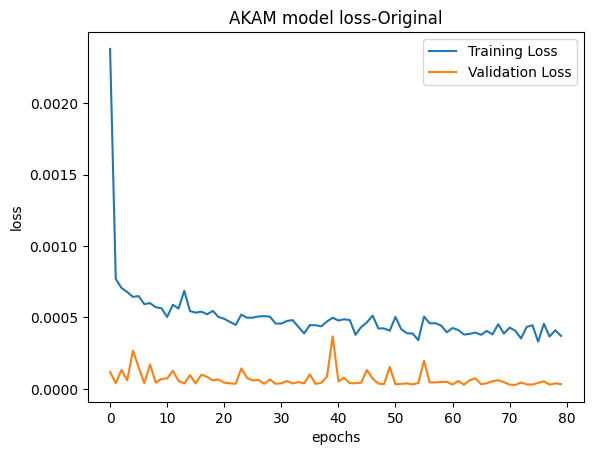

In [61]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [63]:
# Save the entire model as a `.keras` zip archive.
# best_model.save('TSLA_model_hyperparameter.keras')
best_model.save(f'saved_model_LSTM/{ticker}_model_{study_naam}_{epoch_no}epochs')
# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_LSTM/AKAM_model_Original_80epochs/assets


INFO:tensorflow:Assets written to: saved_model_LSTM/AKAM_model_Original_80epochs/assets


In [43]:
best_model.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_314 (LSTM)             (None, 10, 60)            14880     
                                                                 
 dropout_314 (Dropout)       (None, 10, 60)            0         
                                                                 
 lstm_315 (LSTM)             (None, 10, 60)            29040     
                                                                 
 dropout_315 (Dropout)       (None, 10, 60)            0         
                                                                 
 lstm_316 (LSTM)             (None, 10, 60)            29040     
                                                                 
 dropout_316 (Dropout)       (None, 10, 60)            0         
                                                                 
 lstm_317 (LSTM)             (None, 60)              

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [45]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
# plot_simple(stock_data,"test",f'Stock Price(Test) Prediction with LSTM({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'Stock Price(Test) Prediction with LSTM({a})',ticker,y_raw, predicted_stock_price_raw)

****************************TEST************************************


epochs=80

In [62]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
# plot_simple(stock_data,"test",f'Stock Price(Test) Prediction with LSTM({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'Stock Price(Test) Prediction with LSTM({a})',ticker,y_raw, predicted_stock_price_raw)

****************************TEST************************************


#### AKAM - Filtered(SMA)

##### Start Tuning

The file 'AKAM_data.csv' does exist.
Filter Name- SMA


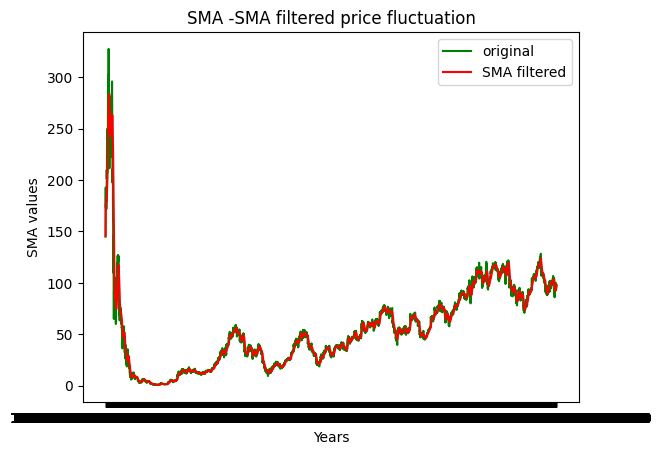

In [64]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
sma_win=20
attn=False
# units=50
# drop_out=0.2
n_trial=50
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="SMA" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="SMA"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

##### Best parameter values

In [47]:
study_lstm.best_trial.params

{'win_size': 10,
 'epoch_no': 10,
 'split_size': 0.5,
 'units': 60,
 'drop_out': 0.4,
 'optimizer_name': 'adamax',
 'no_layers': 2,
 'loss_fn_name': 'log_cosh',
 'activation_name': 'relu'}

##### After hyperparameter tuning - Train model with best values

In [65]:
win_size=study_lstm.best_trial.params['win_size']
epoch_no=80#study_lstm.best_trial.params['epoch_no']
drop_out=round(study_lstm.best_trial.params['drop_out'],2)
units=study_lstm.best_trial.params['units']
split_size=round(study_lstm.best_trial.params['split_size'],2)
optimizer_options =study_lstm.best_trial.params['optimizer_name']
num_of_layers= study_lstm.best_trial.params['no_layers']
loss_option=study_lstm.best_trial.params['loss_fn_name']
actv_option=study_lstm.best_trial.params['activation_name']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)
Epoch 1/80
99/99 [==============================] - 6s 23ms/step - loss: 0.0029 - val_loss: 3.3187e-04
Epoch 2/80
99/99 [==============================] - 1s 13ms/step - loss: 6.8450e-04 - val_loss: 2.9051e-05
Epoch 3/80
99/99 [==============================] - 1s 14ms/step - loss: 7.1453e-04 - val_loss: 3.0495e-05
Epoch 4/80
99/99 [==============================] - 1s 14ms/step - loss: 7.5398e-04 - val_loss: 1.7729e-04
Epoch 5/80
99/99 [==============================] - 1s 14ms/step - loss: 6.5334e-04 - val_loss: 1.1072e-04
Epoch 6/80
99/99 [==============================] - 1s 13ms/step - loss: 5.9982e-04 - val_loss: 3.7526e-05
Epoch 7/80
99/99 [==============================] - 1s 13ms/step - loss: 6.9759e-04 - val_loss: 1.1179e-04
Epoch 8/80
99/99 [==============================] - 1s 14ms/step - loss: 6.1713e-04 - val_loss: 2.8382e-05
Epoch 9/80
99/99 [==============================] - 1s 14ms/step - loss: 

##### Evalute tuned model

In [49]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

50/50 [==============================] - 1s 3ms/step
**********************SMA filter***************************
Mean Absolute Percentage Error (MAPE): 0.04%
Mean Absolute Error (MAE): 3.64
Root Mean Squared Error (RMSE): 4.11
R2 Score: 0.92


In [66]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

50/50 [==============================] - 1s 4ms/step
**********************SMA filter***************************
Mean Absolute Percentage Error (MAPE): 0.03%
Mean Absolute Error (MAE): 3.06
Root Mean Squared Error (RMSE): 3.43
R2 Score: 0.94


##### Validation and training loss plot

In [50]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} LSTM model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [67]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} LSTM model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [69]:
# Save the entire model as a `.keras` zip archive.
# best_model.save('TSLA_model_hyperparameter.keras')
best_model.save(f'saved_model_LSTM/{ticker}_model_{study_naam}')
# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_LSTM/AKAM_model_SMA/assets


INFO:tensorflow:Assets written to: saved_model_LSTM/AKAM_model_SMA/assets


In [ ]:
best_model.summary()

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [51]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="LSTM"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [68]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="LSTM"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### AKAM - Filtered(kalman)

##### Start Tuning

The file 'AKAM_data.csv' does exist.
Filter Name- kalman


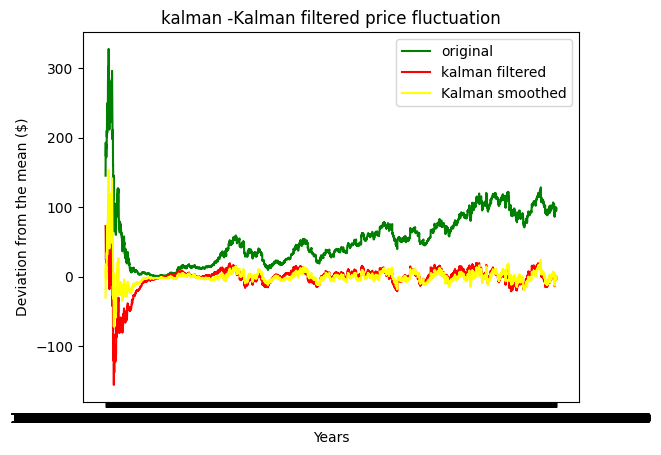

In [70]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="kalman" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="kalman"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

##### Best parameter values

In [53]:
study_lstm.best_trial.params

{'win_size': 10,
 'epoch_no': 10,
 'split_size': 0.5,
 'units': 60,
 'drop_out': 0.4,
 'optimizer_name': 'adamax',
 'no_layers': 2,
 'loss_fn_name': 'log_cosh',
 'activation_name': 'relu'}

##### After hyperparameter tuning - Evaluate model with best values

In [71]:
win_size=study_lstm.best_trial.params['win_size']
epoch_no=80#study_lstm.best_trial.params['epoch_no']
drop_out=round(study_lstm.best_trial.params['drop_out'],2)
units=study_lstm.best_trial.params['units']
split_size=round(study_lstm.best_trial.params['split_size'],2)
optimizer_options =study_lstm.best_trial.params['optimizer_name']
num_of_layers= study_lstm.best_trial.params['no_layers']
loss_option=study_lstm.best_trial.params['loss_fn_name']
actv_option=study_lstm.best_trial.params['activation_name']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)
Epoch 1/80
99/99 [==============================] - 6s 22ms/step - loss: 0.0160 - val_loss: 3.9608e-04
Epoch 2/80
99/99 [==============================] - 1s 12ms/step - loss: 0.0044 - val_loss: 1.2428e-04
Epoch 3/80
99/99 [==============================] - 1s 12ms/step - loss: 0.0039 - val_loss: 7.6782e-04
Epoch 4/80
99/99 [==============================] - 1s 12ms/step - loss: 0.0036 - val_loss: 3.7338e-04
Epoch 5/80
99/99 [==============================] - 1s 13ms/step - loss: 0.0034 - val_loss: 2.8196e-04
Epoch 6/80
99/99 [==============================] - 1s 13ms/step - loss: 0.0032 - val_loss: 5.9690e-05
Epoch 7/80
99/99 [==============================] - 1s 13ms/step - loss: 0.0030 - val_loss: 9.2526e-05
Epoch 8/80
99/99 [==============================] - 1s 13ms/step - loss: 0.0029 - val_loss: 7.3207e-05
Epoch 9/80
99/99 [==============================] - 1s 13ms/step - loss: 0.0027 - val_loss: 4.8061e-0

##### Evaluate trained model

In [55]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

50/50 [==============================] - 1s 3ms/step
**********************kalman filter***************************
Mean Absolute Percentage Error (MAPE): 2.20%
Mean Absolute Error (MAE): 3.26
Root Mean Squared Error (RMSE): 4.19
R2 Score: 0.77


In [72]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

50/50 [==============================] - 1s 3ms/step
**********************kalman filter***************************
Mean Absolute Percentage Error (MAPE): 1.18%
Mean Absolute Error (MAE): 2.25
Root Mean Squared Error (RMSE): 2.99
R2 Score: 0.88


##### Val and training loss plot

In [56]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} LSTM model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

In [73]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} LSTM model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [74]:
# Save the entire model as a `.keras` zip archive.
# best_model.save('TSLA_model_hyperparameter.keras')
best_model.save(f'saved_model_LSTM/{ticker}_model_{study_naam}')
# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_LSTM/AKAM_model_kalman/assets


INFO:tensorflow:Assets written to: saved_model_LSTM/AKAM_model_kalman/assets


In [75]:
best_model.summary()

Model: "sequential_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_334 (LSTM)             (None, 10, 60)            14880     
                                                                 
 dropout_334 (Dropout)       (None, 10, 60)            0         
                                                                 
 lstm_335 (LSTM)             (None, 10, 60)            29040     
                                                                 
 dropout_335 (Dropout)       (None, 10, 60)            0         
                                                                 
 lstm_336 (LSTM)             (None, 10, 60)            29040     
                                                                 
 dropout_336 (Dropout)       (None, 10, 60)            0         
                                                                 
 lstm_337 (LSTM)             (None, 60)              

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [57]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="LSTM"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [76]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="LSTM"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### AKAM - Filtered(EMA)

##### Start Tuning

The file 'AKAM_data.csv' does exist.
Filter Name- EMA


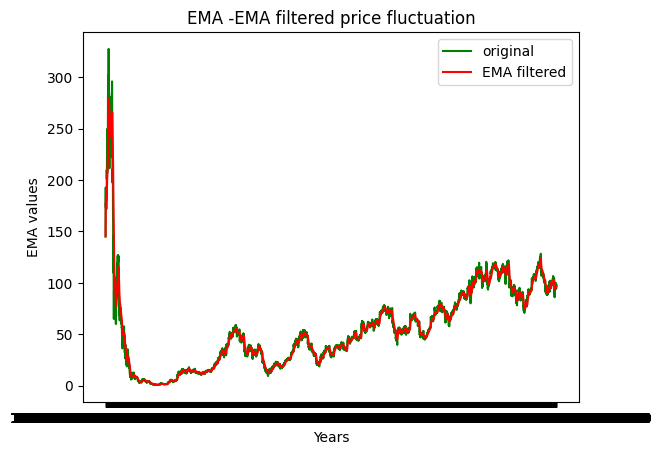

In [77]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
ema_win=20
# units=50
# drop_out=0.2
n_trial=2
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="EMA" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="EMA"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

##### Best parameter values

In [78]:
study_lstm.best_trial.params

{'win_size': 10,
 'epoch_no': 10,
 'split_size': 0.5,
 'units': 60,
 'drop_out': 0.4,
 'optimizer_name': 'adamax',
 'no_layers': 2,
 'loss_fn_name': 'log_cosh',
 'activation_name': 'relu'}

##### After hyperparameter tuning - Evaluate model with best values

In [79]:
win_size=study_lstm.best_trial.params['win_size']
epoch_no=80#study_lstm.best_trial.params['epoch_no']
drop_out=round(study_lstm.best_trial.params['drop_out'],2)
units=study_lstm.best_trial.params['units']
split_size=round(study_lstm.best_trial.params['split_size'],2)
optimizer_options =study_lstm.best_trial.params['optimizer_name']
num_of_layers= study_lstm.best_trial.params['no_layers']
loss_option=study_lstm.best_trial.params['loss_fn_name']
actv_option=study_lstm.best_trial.params['activation_name']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)
Epoch 1/80
99/99 [==============================] - 6s 22ms/step - loss: 0.0024 - val_loss: 9.9614e-05
Epoch 2/80
99/99 [==============================] - 1s 11ms/step - loss: 7.7186e-04 - val_loss: 7.4822e-05
Epoch 3/80
99/99 [==============================] - 1s 12ms/step - loss: 6.3463e-04 - val_loss: 1.6511e-04
Epoch 4/80
99/99 [==============================] - 1s 12ms/step - loss: 5.5109e-04 - val_loss: 1.9937e-04
Epoch 5/80
99/99 [==============================] - 1s 11ms/step - loss: 6.2736e-04 - val_loss: 9.4546e-05
Epoch 6/80
99/99 [==============================] - 1s 12ms/step - loss: 6.1531e-04 - val_loss: 2.0519e-05
Epoch 7/80
99/99 [==============================] - 1s 12ms/step - loss: 5.1027e-04 - val_loss: 3.7964e-05
Epoch 8/80
99/99 [==============================] - 1s 12ms/step - loss: 5.5991e-04 - val_loss: 2.1892e-04
Epoch 9/80
99/99 [==============================] - 1s 13ms/step - loss: 

##### Evaluate trained model

In [82]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

50/50 [==============================] - 0s 4ms/step
**********************EMA filter***************************
Mean Absolute Percentage Error (MAPE): 0.05%
Mean Absolute Error (MAE): 4.40
Root Mean Squared Error (RMSE): 4.72
R2 Score: 0.89


##### Val and training loss plot

In [83]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [84]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_CNN/{ticker}_model_{study_naam}_{ema_win}')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_CNN/AKAM_model_EMA_20/assets


INFO:tensorflow:Assets written to: saved_model_CNN/AKAM_model_EMA_20/assets


In [85]:
best_model.summary()

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_338 (LSTM)             (None, 10, 60)            14880     
                                                                 
 dropout_338 (Dropout)       (None, 10, 60)            0         
                                                                 
 lstm_339 (LSTM)             (None, 10, 60)            29040     
                                                                 
 dropout_339 (Dropout)       (None, 10, 60)            0         
                                                                 
 lstm_340 (LSTM)             (None, 10, 60)            29040     
                                                                 
 dropout_340 (Dropout)       (None, 10, 60)            0         
                                                                 
 lstm_341 (LSTM)             (None, 60)              

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [86]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="LSTM"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### AKAM - Filtered(MACD)

##### Start Tuning

[I 2024-11-26 19:16:09,397] A new study created in memory with name: MACD


Filter Name- MACD
Epoch 1/10
91/91 [==============================] - 3s 14ms/step - loss: 0.0078 - val_loss: 0.0103
Epoch 2/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0024 - val_loss: 0.0093
Epoch 3/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0021 - val_loss: 0.0081
Epoch 4/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 0.0082
Epoch 5/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 0.0071
Epoch 6/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.0062
Epoch 7/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.0055
Epoch 8/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0041
Epoch 9/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0048
Epoch 10/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0033


[I 2024-11-26 19:16:20,064] Trial 0 finished with value: 0.0032991310581564903 and parameters: {'win_size': 20, 'epoch_no': 10, 'split_size': 0.2, 'units': 70, 'drop_out': 0.2}. Best is trial 0 with value: 0.0032991310581564903.


loss value [0.010338778607547283, 0.009312453679740429, 0.008104554377496243, 0.008184535428881645, 0.0070703160017728806, 0.006199487950652838, 0.005478709004819393, 0.0040875328704714775, 0.004820379428565502, 0.0032991310581564903]
Epoch 1/25
68/68 [==============================] - 4s 20ms/step - loss: 0.0092 - val_loss: 0.0087
Epoch 2/25
68/68 [==============================] - 1s 11ms/step - loss: 9.5575e-04 - val_loss: 0.0086
Epoch 3/25
68/68 [==============================] - 1s 12ms/step - loss: 8.2655e-04 - val_loss: 0.0088
Epoch 4/25
68/68 [==============================] - 1s 12ms/step - loss: 7.4906e-04 - val_loss: 0.0085
Epoch 5/25
68/68 [==============================] - 1s 12ms/step - loss: 6.9822e-04 - val_loss: 0.0087
Epoch 6/25
68/68 [==============================] - 1s 12ms/step - loss: 6.5303e-04 - val_loss: 0.0093
Epoch 7/25
68/68 [==============================] - 1s 11ms/step - loss: 6.2656e-04 - val_loss: 0.0092
Epoch 8/25
68/68 [==============================

[I 2024-11-26 19:16:35,230] Trial 1 finished with value: 0.008545308373868465 and parameters: {'win_size': 40, 'epoch_no': 25, 'split_size': 0.4, 'units': 70, 'drop_out': 0.2}. Best is trial 0 with value: 0.0032991310581564903.


loss value [0.008725729770958424, 0.008564658463001251, 0.008764608763158321, 0.008545308373868465, 0.008692014962434769, 0.009346519596874714, 0.009218539111316204, 0.01007468905299902, 0.009372632950544357, 0.009564652107656002, 0.009989520534873009, 0.010228118859231472, 0.010320046916604042, 0.010919501073658466]
Best parameters: for MACD filter {'win_size': 20, 'epoch_no': 10, 'split_size': 0.2, 'units': 70, 'drop_out': 0.2}
Best value: for MACD filter 0.0032991310581564903
    win_size: 20
    epoch_no: 10
    split_size: 0.2
    units: 70
    drop_out: 0.2


({'win_size': 20,
  'epoch_no': 10,
  'split_size': 0.2,
  'units': 70,
  'drop_out': 0.2},
 0.0032991310581564903)

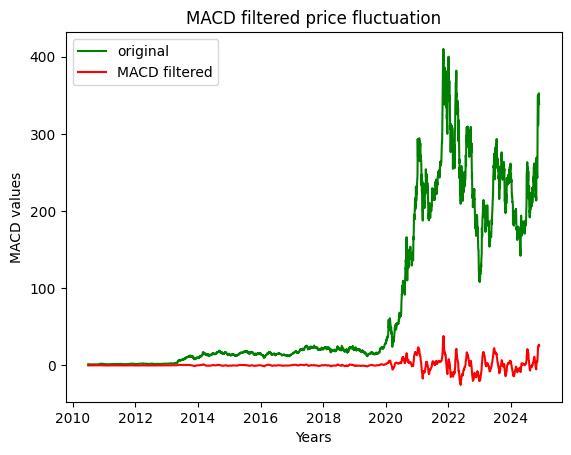

In [196]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="TSLA" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="MACD" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="MACD"
abc(ticker,n_trial,filter,f"{study_naam}",batch_size_no,attn)

##### Optuna plot

In [197]:
optuna.visualization.plot_optimization_history(study_lstm)

In [198]:
# optuna-dashboard sqlite:///db.sqlite3

optuna.visualization.plot_slice(study_lstm)

##### Best parameter values

In [199]:
study_lstm.best_trial.params

{'win_size': 20,
 'epoch_no': 10,
 'split_size': 0.2,
 'units': 70,
 'drop_out': 0.2}

##### After hyperparameter tuning - Evaluate model with best values

In [ ]:
win_size=study_lstm.best_trial.params['win_size']
pred_step=10
epoch_no=study_lstm.best_trial.params['epoch_no']
batch_size_no=32
split_size=round(study_lstm.best_trial.params['split_size'],2)
attn=False
units=study_lstm.best_trial.params['units']
drop_out=round(study_lstm.best_trial.params['drop_out'],2)
n_trial=0
best_model = build_model(win_size,drop_out,units,split_size)
# print(f"**********************{study_naam} filter*************************")

scaled_data_unfilt = scaler.transform(tesla_data[['Close']].values)
X_unfilt,y_unfilt = create_sequences(scaled_data_unfilt,study_lstm.best_trial.params['win_size'])
X_test_unfilt = X_unfilt[-len(X_test):]
y_test_unfilt = y_unfilt[-len(y_test):]

history = best_model.fit(X_train, y_train, epochs=epoch_no, batch_size=32, validation_data=(X_test_unfilt, y_test_unfilt))
# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

Epoch 1/10
91/91 [==============================] - 3s 14ms/step - loss: 0.0100 - val_loss: 0.0096
Epoch 2/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 0.0080
Epoch 3/10
91/91 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 0.0063
Epoch 4/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 0.0053
Epoch 5/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0043
Epoch 6/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0037
Epoch 7/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 8/10
91/91 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 9/10
91/91 [==============================] - 1s 9ms/step - loss: 0.0010 - val_loss: 0.0026
Epoch 10/10
91/91 [==============================] - 1s 8ms/step - loss: 9.8636e-04 - val_loss: 0.0025


##### Evaluate trained model

In [ ]:
evaluate_model(best_model,X_test_unfilt,y_test_unfilt, filter)

23/23 [==============================] - 1s 3ms/step
**********************MACD filter***************************
Mean Absolute Percentage Error (MAPE): 1.92%
Mean Absolute Error (MAE): 2.41
Root Mean Squared Error (RMSE): 3.14
R2 Score: 0.91


##### Val and training loss plot

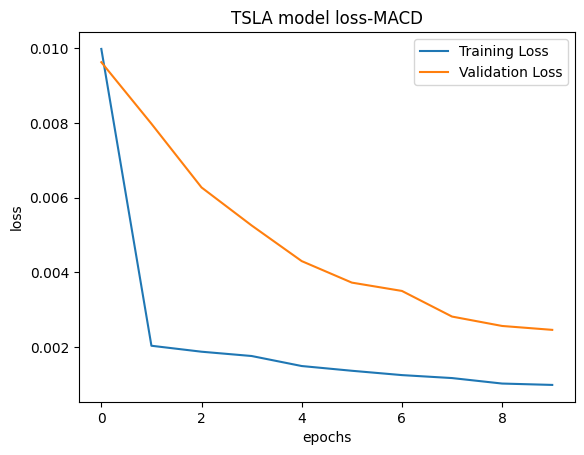

In [202]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [ ]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'TSLA_model_hyperparameter_{filter}.keras')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

In [204]:
best_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 20, 70)            20160     
                                                                 
 dropout_40 (Dropout)        (None, 20, 70)            0         
                                                                 
 lstm_41 (LSTM)              (None, 70)                39480     
                                                                 
 dropout_41 (Dropout)        (None, 70)                0         
                                                                 
 dense_20 (Dense)            (None, 1)                 71        
                                                                 
Total params: 59711 (233.25 KB)
Trainable params: 59711 (233.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

****************************TEST************************************


<Figure size 1000x600 with 0 Axes>

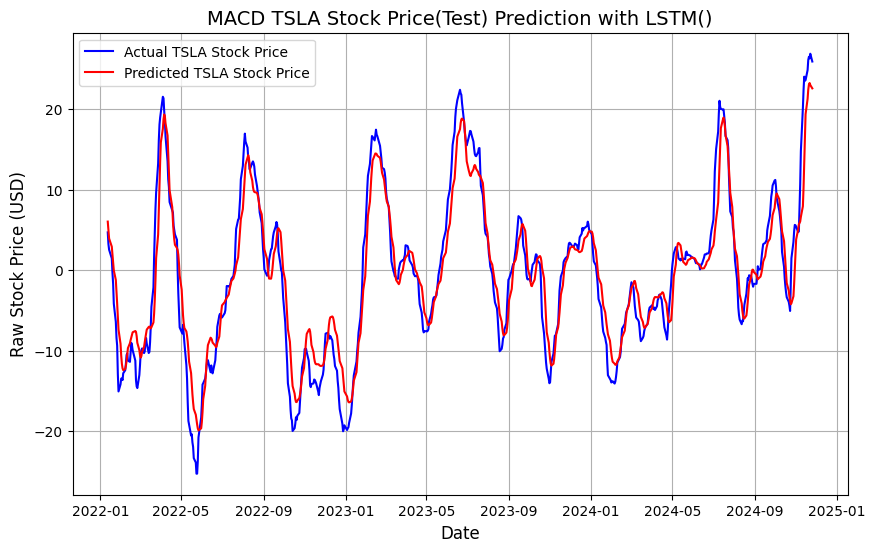

In [205]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
model_name="LSTM"
plot_simple(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw)

#### AKAM - Filtered(Fourier)

##### Start Tuning

In [87]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
threshold = 0.001 #0.2, 0.1, 0.05, 0.01, 0.005, 0.001
n_trial=2
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="fourier" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="fourier"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

The file 'AKAM_data.csv' does exist.
freq- [ 0.          0.00015798  0.00031596 ... -0.00047393 -0.00031596
 -0.00015798]
amp- [344715.01760691 122909.57037917  65989.7722986  ...  52740.26812119
  65989.7722986  122909.57037917]


Filter Name- fourier


The file 'AKAM_data.csv' does exist.
freq- [ 0.          0.00015798  0.00031596 ... -0.00047393 -0.00031596
 -0.00015798]
amp- [344715.01760691 122909.57037917  65989.7722986  ...  52740.26812119
  65989.7722986  122909.57037917]


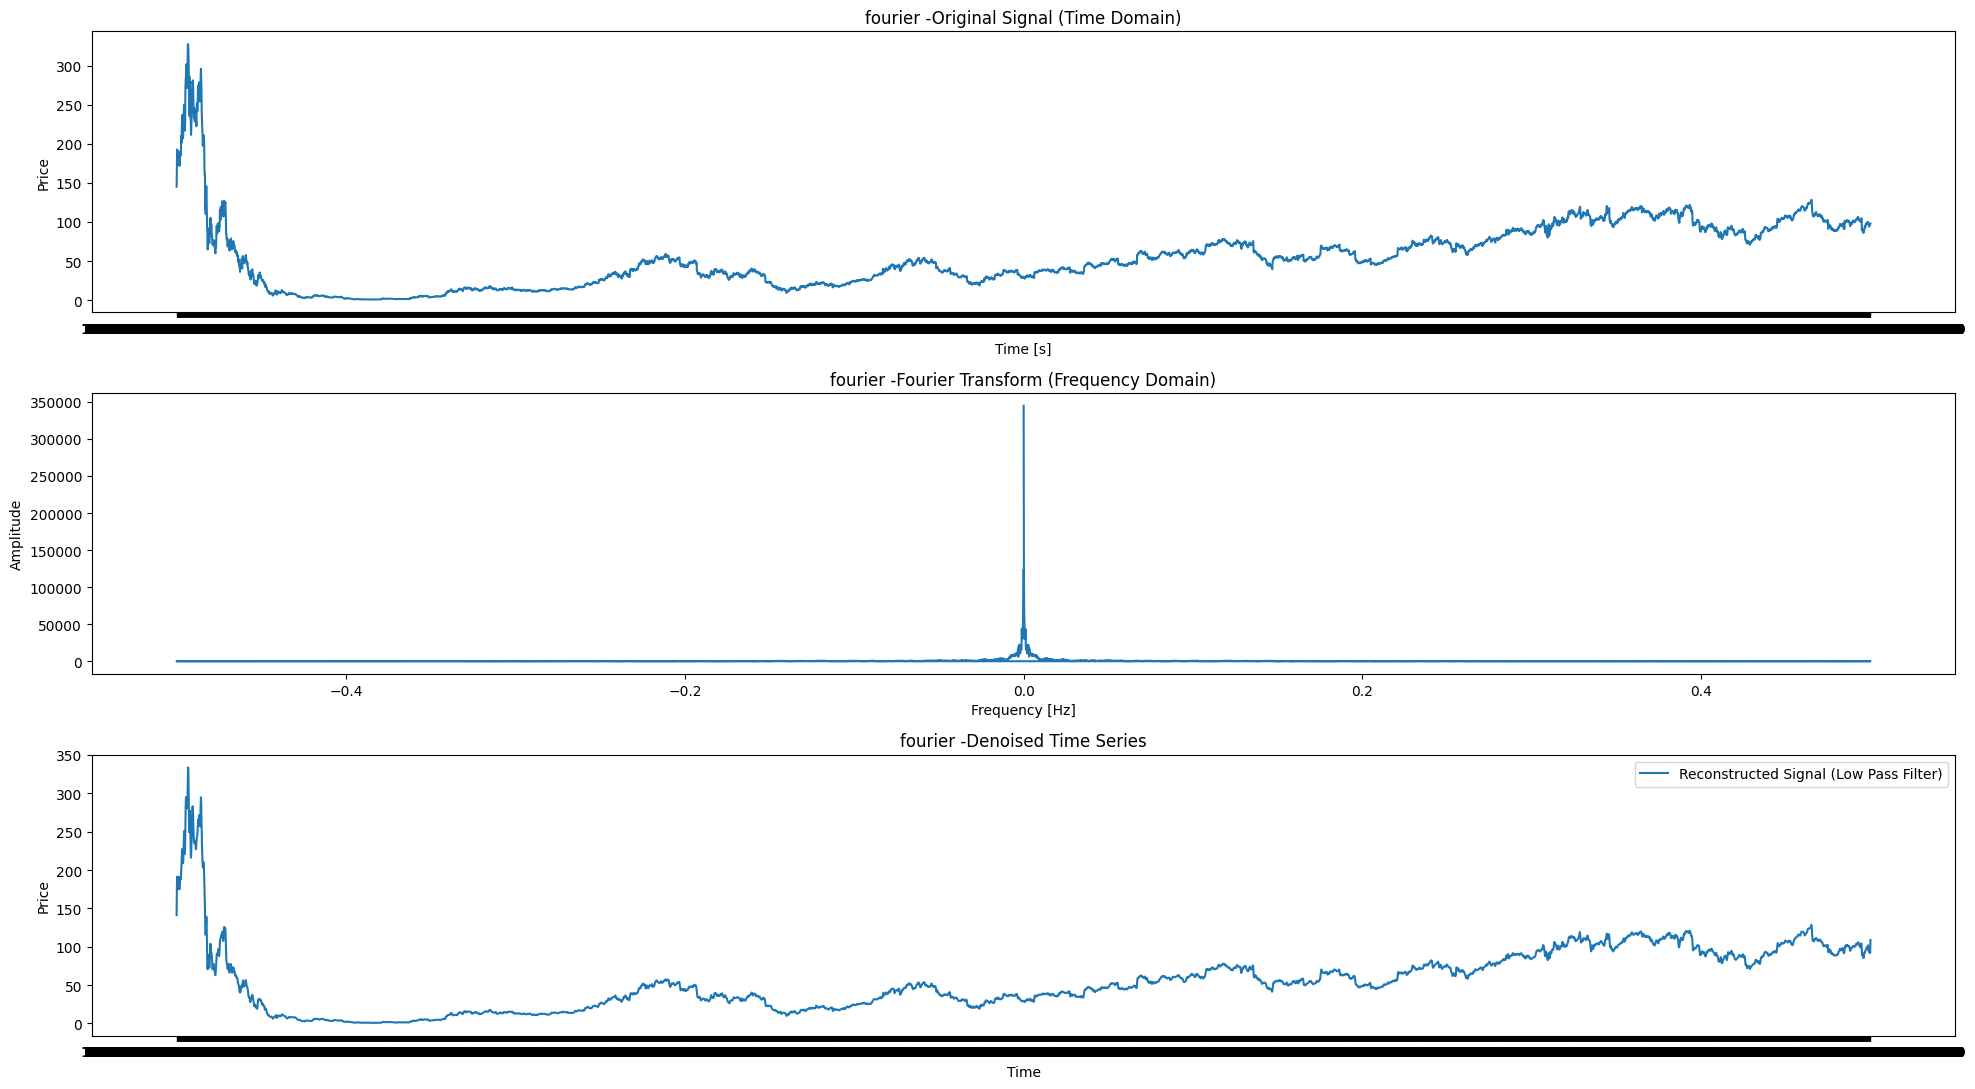

Filter Name- fourier


In [93]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
threshold = 0.2 #0.2, 0.1, 0.05, 0.01, 0.005, 0.001
n_trial=2
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="fourier" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="fourier"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

The file 'AKAM_data.csv' does exist.
freq- [ 0.          0.00015798  0.00031596 ... -0.00047393 -0.00031596
 -0.00015798]
amp- [344715.01760691 122909.57037917  65989.7722986  ...  52740.26812119
  65989.7722986  122909.57037917]


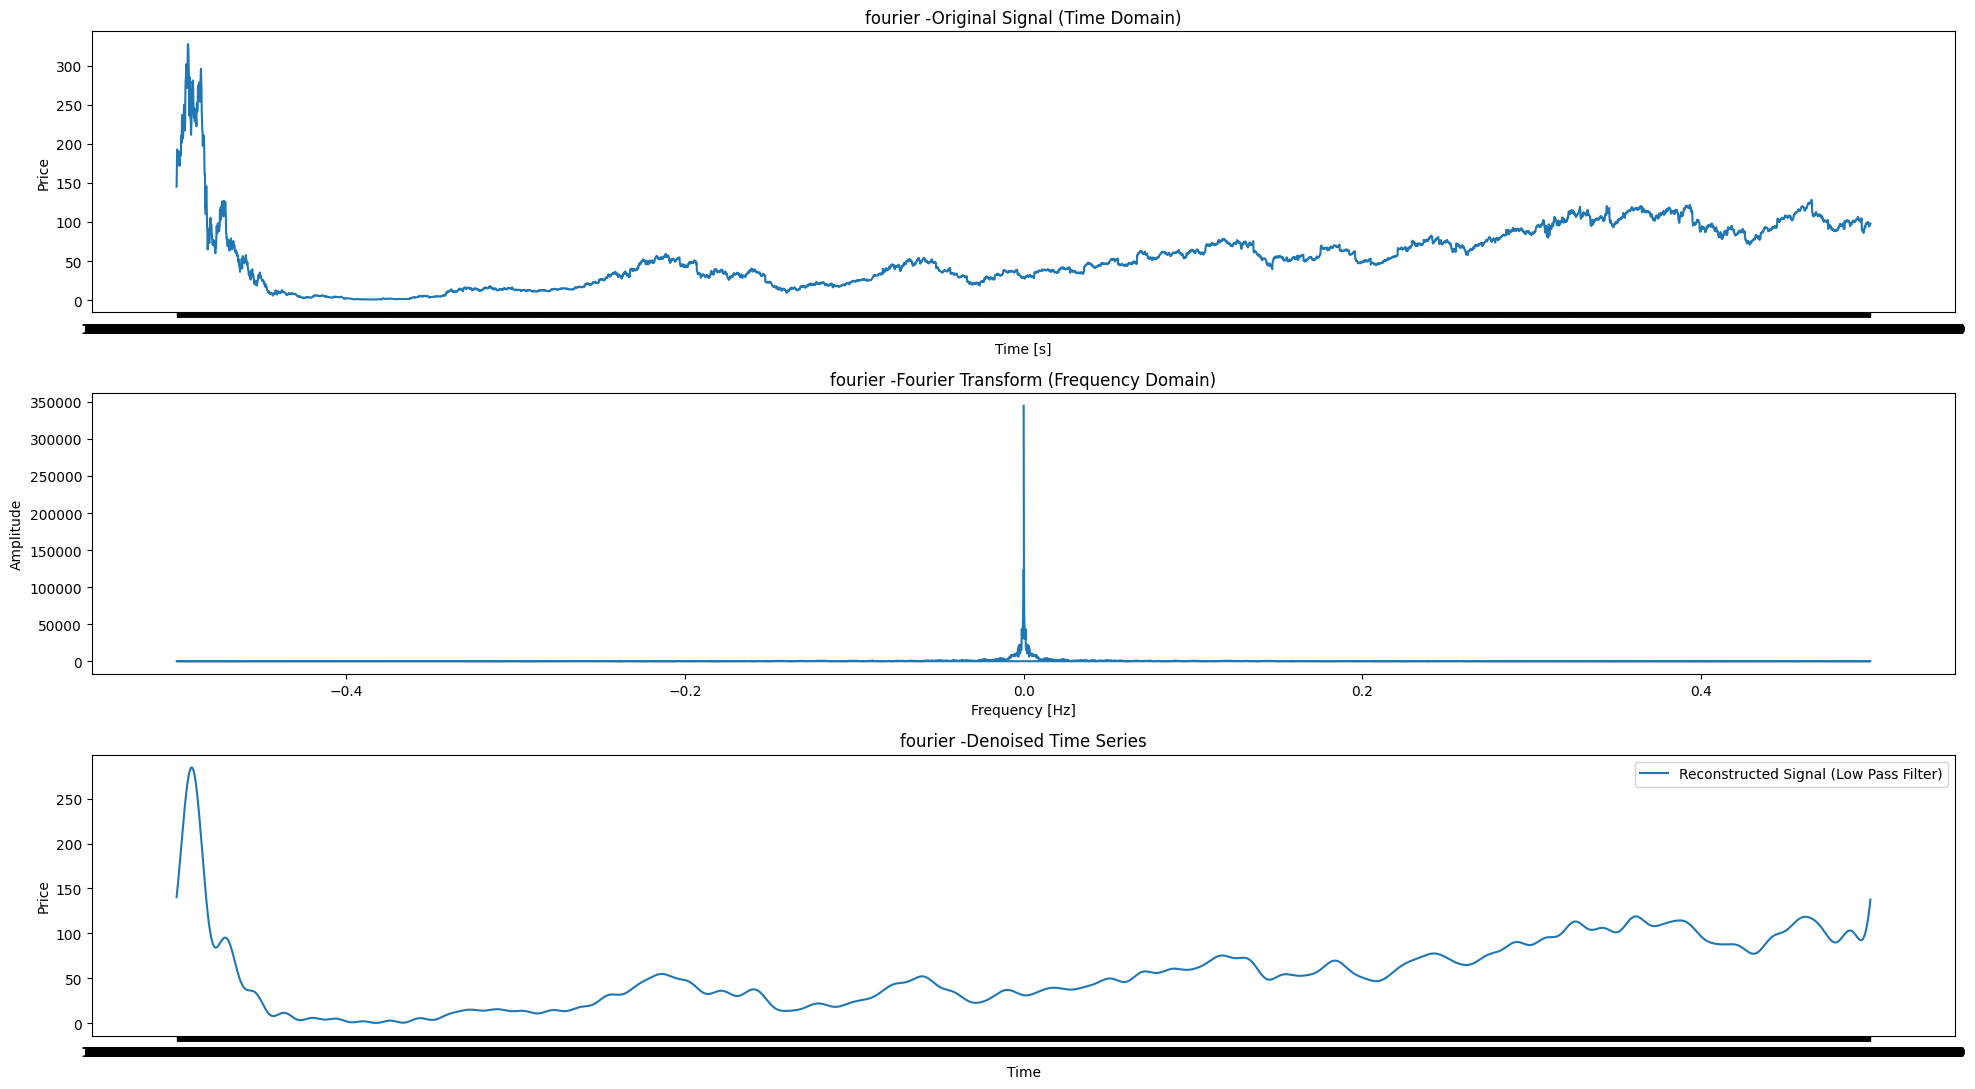

Filter Name- fourier


In [100]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
threshold = 0.01 #0.2, 0.1, 0.05, 0.01, 0.005, 0.001
n_trial=2
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="fourier" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="fourier"
tuning=False
stock_file_name=f"{ticker}_data.csv"
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning)

##### Best parameter values

In [94]:
study_lstm.best_trial.params

{'win_size': 10,
 'epoch_no': 10,
 'split_size': 0.5,
 'units': 60,
 'drop_out': 0.4,
 'optimizer_name': 'adamax',
 'no_layers': 2,
 'loss_fn_name': 'log_cosh',
 'activation_name': 'relu'}

##### After hyperparameter tuning - Train model with best values

In [89]:
win_size=study_lstm.best_trial.params['win_size']
epoch_no=80#study_lstm.best_trial.params['epoch_no']
drop_out=round(study_lstm.best_trial.params['drop_out'],2)
units=study_lstm.best_trial.params['units']
split_size=round(study_lstm.best_trial.params['split_size'],2)
optimizer_options =study_lstm.best_trial.params['optimizer_name']
num_of_layers= study_lstm.best_trial.params['no_layers']
loss_option=study_lstm.best_trial.params['loss_fn_name']
actv_option=study_lstm.best_trial.params['activation_name']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)
Epoch 1/80
99/99 [==============================] - 6s 22ms/step - loss: 0.0063 - val_loss: 0.0010
Epoch 2/80
99/99 [==============================] - 1s 12ms/step - loss: 0.0017 - val_loss: 4.6392e-05
Epoch 3/80
99/99 [==============================] - 1s 12ms/step - loss: 0.0014 - val_loss: 5.6253e-05
Epoch 4/80
99/99 [==============================] - 1s 13ms/step - loss: 0.0013 - val_loss: 7.6917e-05
Epoch 5/80
99/99 [==============================] - 1s 13ms/step - loss: 0.0012 - val_loss: 3.3647e-05
Epoch 6/80
99/99 [==============================] - 1s 14ms/step - loss: 0.0011 - val_loss: 6.4653e-06
Epoch 7/80
99/99 [==============================] - 1s 13ms/step - loss: 0.0011 - val_loss: 1.8556e-04
Epoch 8/80
99/99 [==============================] - 1s 13ms/step - loss: 0.0010 - val_loss: 1.2506e-04
Epoch 9/80
99/99 [==============================] - 1s 14ms/step - loss: 0.0010 - val_loss: 1.0383e-04
Ep

In [95]:
win_size=study_lstm.best_trial.params['win_size']
epoch_no=80#study_lstm.best_trial.params['epoch_no']
drop_out=round(study_lstm.best_trial.params['drop_out'],2)
units=study_lstm.best_trial.params['units']
split_size=round(study_lstm.best_trial.params['split_size'],2)
optimizer_options =study_lstm.best_trial.params['optimizer_name']
num_of_layers= study_lstm.best_trial.params['no_layers']
loss_option=study_lstm.best_trial.params['loss_fn_name']
actv_option=study_lstm.best_trial.params['activation_name']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)
Epoch 1/80
99/99 [==============================] - 6s 21ms/step - loss: 0.0019 - val_loss: 8.2003e-05
Epoch 2/80
99/99 [==============================] - 1s 12ms/step - loss: 6.3059e-04 - val_loss: 1.7188e-04
Epoch 3/80
99/99 [==============================] - 1s 13ms/step - loss: 6.4206e-04 - val_loss: 4.7771e-05
Epoch 4/80
99/99 [==============================] - 1s 12ms/step - loss: 7.1585e-04 - val_loss: 3.6617e-05
Epoch 5/80
99/99 [==============================] - 1s 12ms/step - loss: 6.7146e-04 - val_loss: 1.0991e-04
Epoch 6/80
99/99 [==============================] - 1s 12ms/step - loss: 6.9346e-04 - val_loss: 3.9635e-05
Epoch 7/80
99/99 [==============================] - 1s 12ms/step - loss: 6.1362e-04 - val_loss: 1.2424e-04
Epoch 8/80
99/99 [==============================] - 1s 12ms/step - loss: 4.8592e-04 - val_loss: 3.5753e-05
Epoch 9/80
99/99 [==============================] - 1s 13ms/step - loss: 

In [101]:
win_size=study_lstm.best_trial.params['win_size']
epoch_no=80#study_lstm.best_trial.params['epoch_no']
drop_out=round(study_lstm.best_trial.params['drop_out'],2)
units=study_lstm.best_trial.params['units']
split_size=round(study_lstm.best_trial.params['split_size'],2)
optimizer_options =study_lstm.best_trial.params['optimizer_name']
num_of_layers= study_lstm.best_trial.params['no_layers']
loss_option=study_lstm.best_trial.params['loss_fn_name']
actv_option=study_lstm.best_trial.params['activation_name']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)
Epoch 1/80
99/99 [==============================] - 6s 23ms/step - loss: 0.0026 - val_loss: 2.1826e-05
Epoch 2/80
99/99 [==============================] - 1s 13ms/step - loss: 5.7839e-04 - val_loss: 1.0812e-04
Epoch 3/80
99/99 [==============================] - 1s 14ms/step - loss: 6.1615e-04 - val_loss: 2.3009e-04
Epoch 4/80
99/99 [==============================] - 1s 14ms/step - loss: 5.5711e-04 - val_loss: 6.5032e-05
Epoch 5/80
99/99 [==============================] - 1s 14ms/step - loss: 5.6779e-04 - val_loss: 3.1188e-05
Epoch 6/80
99/99 [==============================] - 1s 14ms/step - loss: 5.2141e-04 - val_loss: 1.6413e-04
Epoch 7/80
99/99 [==============================] - 1s 14ms/step - loss: 5.6377e-04 - val_loss: 7.2062e-06
Epoch 8/80
99/99 [==============================] - 1s 14ms/step - loss: 5.1206e-04 - val_loss: 9.0427e-05
Epoch 9/80
99/99 [==============================] - 1s 12ms/step - loss: 

##### Evaluate trained model

In [90]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

50/50 [==============================] - 1s 4ms/step
**********************fourier filter***************************
Mean Absolute Percentage Error (MAPE): 0.04%
Mean Absolute Error (MAE): 4.32
Root Mean Squared Error (RMSE): 4.68
R2 Score: 0.90


In [96]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

50/50 [==============================] - 1s 3ms/step
**********************fourier filter***************************
Mean Absolute Percentage Error (MAPE): 0.03%
Mean Absolute Error (MAE): 2.86
Root Mean Squared Error (RMSE): 3.65
R2 Score: 0.94


In [102]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

50/50 [==============================] - 1s 3ms/step
**********************fourier filter***************************
Mean Absolute Percentage Error (MAPE): 0.07%
Mean Absolute Error (MAE): 7.06
Root Mean Squared Error (RMSE): 7.37
R2 Score: 0.74


##### Val and training loss plot

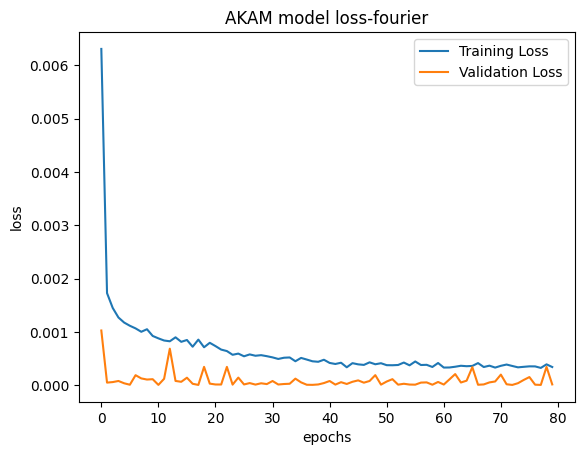

In [91]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

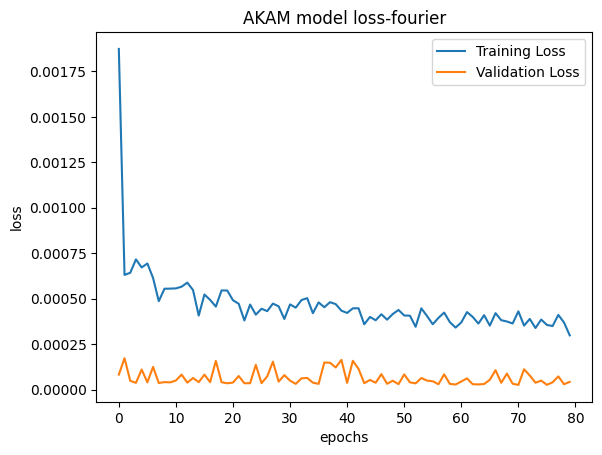

In [97]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

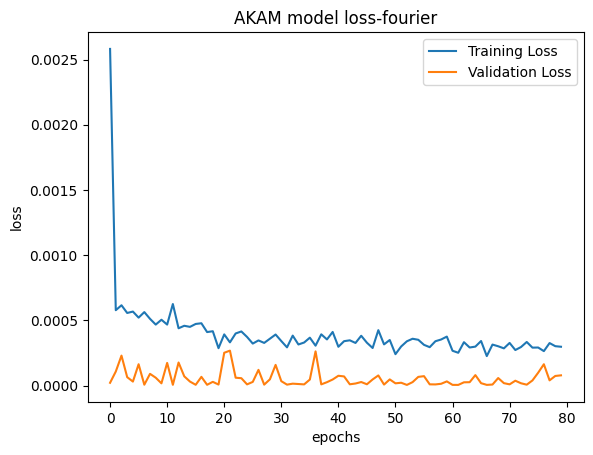

In [103]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [99]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_CNN/{ticker}_model_{study_naam}_{threshold}')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_CNN/AKAM_model_fourier_0.2/assets


INFO:tensorflow:Assets written to: saved_model_CNN/AKAM_model_fourier_0.2/assets


In [105]:
best_model.summary()

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_350 (LSTM)             (None, 10, 60)            14880     
                                                                 
 dropout_350 (Dropout)       (None, 10, 60)            0         
                                                                 
 lstm_351 (LSTM)             (None, 10, 60)            29040     
                                                                 
 dropout_351 (Dropout)       (None, 10, 60)            0         
                                                                 
 lstm_352 (LSTM)             (None, 10, 60)            29040     
                                                                 
 dropout_352 (Dropout)       (None, 10, 60)            0         
                                                                 
 lstm_353 (LSTM)             (None, 60)              

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [92]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [98]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [104]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="CNN"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### AKAM - Filtered(Wavelet)

##### Start Tuning

The file 'AKAM_data.csv' does exist.
length of details- 6
Threshold enabled- False


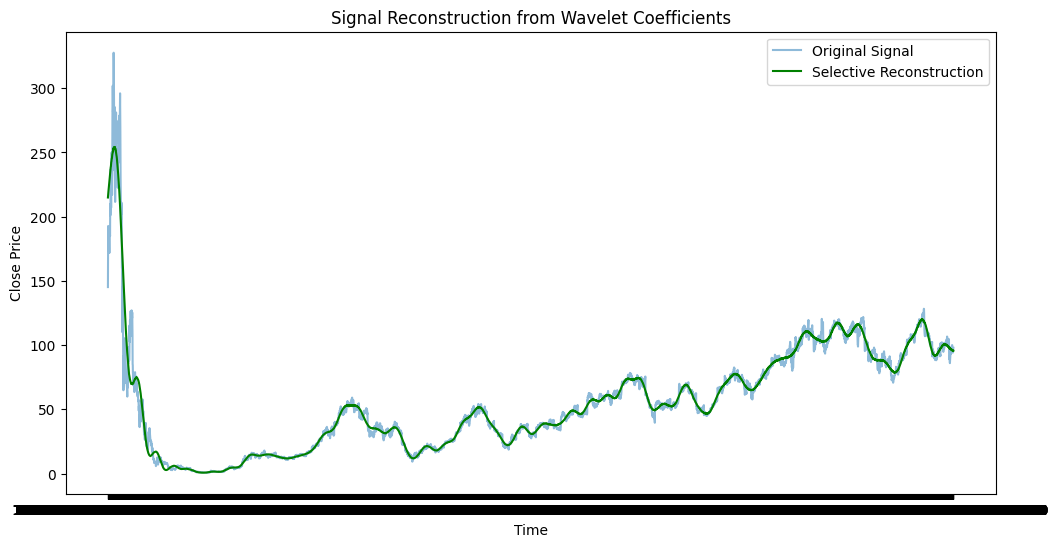

Filter Name- wavelet


In [107]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="wavelet" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="wavelet"
# detail_index=0
# wavelet_name="db4"
# approx_enable=True
# threshold_enable=False
# thresh_value=0
tuning=False
stock_file_name=f"{ticker}_data.csv"
detail_index=6
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="dmey"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

The file 'AKAM_data.csv' does exist.
length of details- 6
Threshold enabled- False


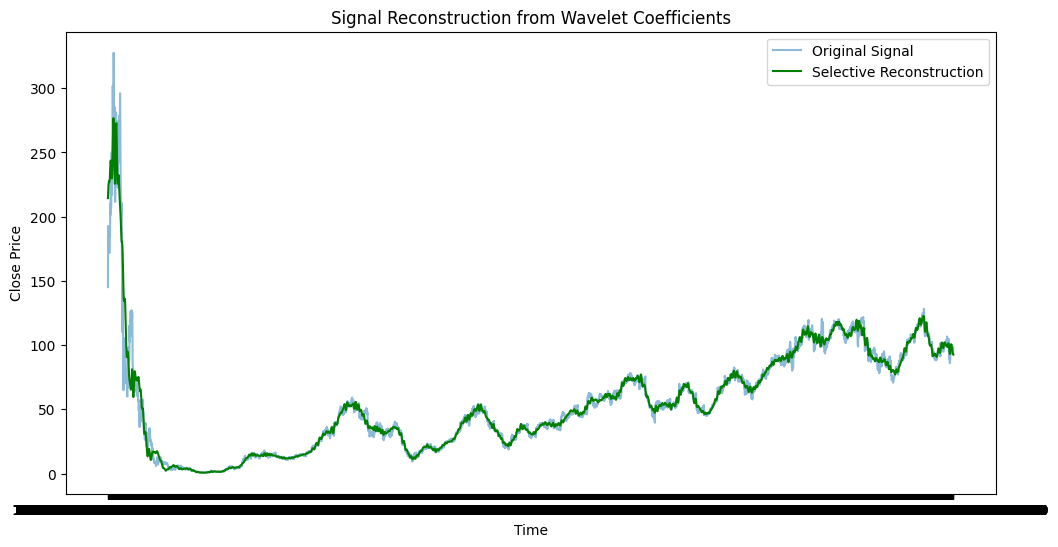

Filter Name- wavelet


In [115]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="wavelet" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="wavelet"
# detail_index=0
# wavelet_name="db4"
# approx_enable=True
# threshold_enable=False
# thresh_value=0
tuning=False
stock_file_name=f"{ticker}_data.csv"
detail_index=2
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="dmey"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

The file 'AKAM_data.csv' does exist.
length of details- 7
Threshold enabled- False


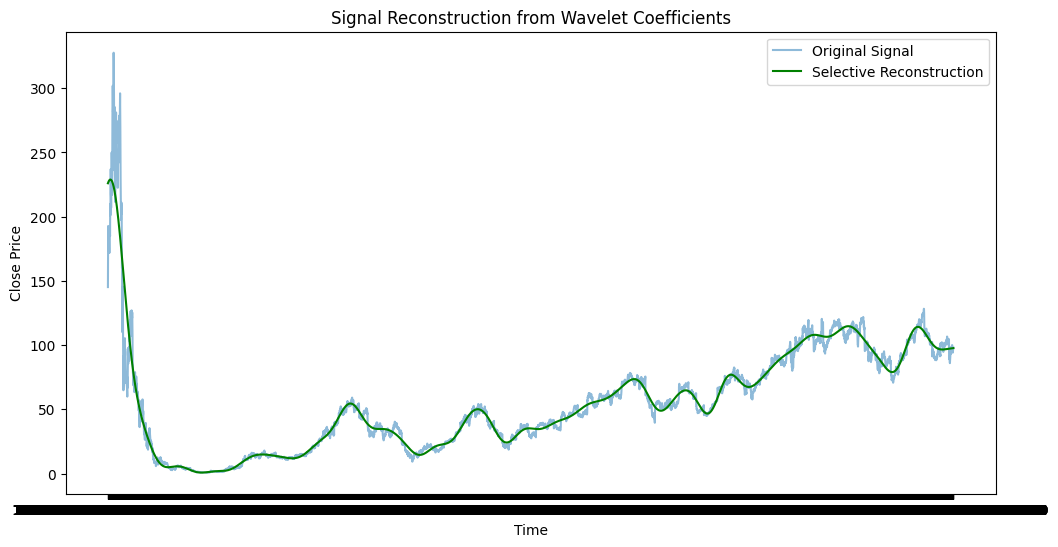

Filter Name- wavelet


In [122]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="wavelet" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="wavelet"
# detail_index=0
# wavelet_name="db4"
# approx_enable=True
# threshold_enable=False
# thresh_value=0
tuning=False
stock_file_name=f"{ticker}_data.csv"
detail_index=7
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="sym18"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

The file 'AKAM_data.csv' does exist.
length of details- 9
Threshold enabled- False


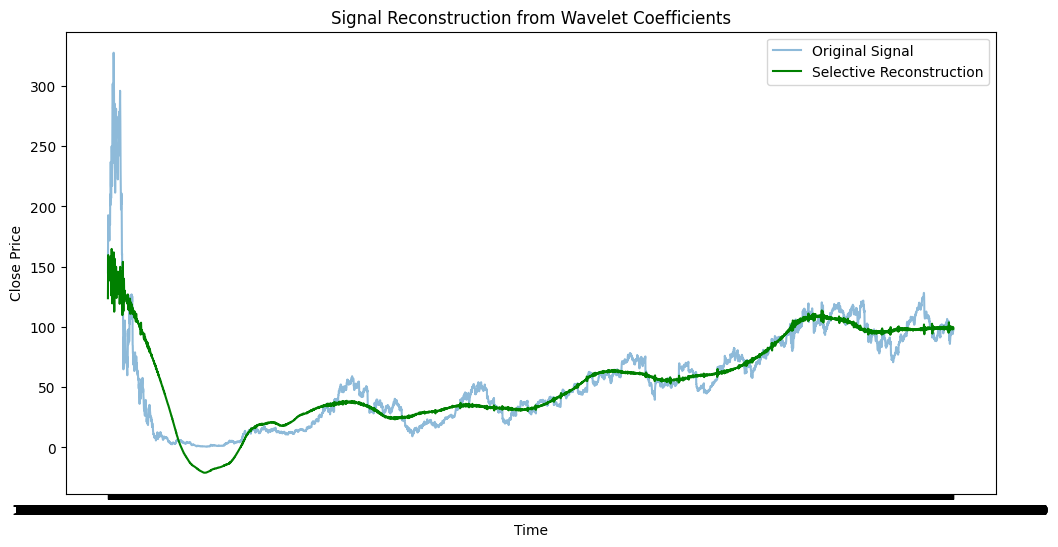

Filter Name- wavelet


In [127]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="wavelet" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="wavelet"
# detail_index=0
# wavelet_name="db4"
# approx_enable=True
# threshold_enable=False
# thresh_value=0
tuning=False
stock_file_name=f"{ticker}_data.csv"
detail_index=7
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="db4"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

In [108]:
study_lstm.best_trial.params

{'win_size': 10,
 'epoch_no': 10,
 'split_size': 0.5,
 'units': 60,
 'drop_out': 0.4,
 'optimizer_name': 'adamax',
 'no_layers': 2,
 'loss_fn_name': 'log_cosh',
 'activation_name': 'relu'}

##### After hyperparameter tuning - Train model with best values

dmey index=6

In [109]:
win_size=study_lstm.best_trial.params['win_size']
epoch_no=80#study_lstm.best_trial.params['epoch_no']
drop_out=round(study_lstm.best_trial.params['drop_out'],2)
units=study_lstm.best_trial.params['units']
split_size=round(study_lstm.best_trial.params['split_size'],2)
optimizer_options =study_lstm.best_trial.params['optimizer_name']
num_of_layers= study_lstm.best_trial.params['no_layers']
loss_option=study_lstm.best_trial.params['loss_fn_name']
actv_option=study_lstm.best_trial.params['activation_name']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)
Epoch 1/80
99/99 [==============================] - 6s 22ms/step - loss: 0.0037 - val_loss: 4.6461e-04
Epoch 2/80
99/99 [==============================] - 1s 11ms/step - loss: 6.7306e-04 - val_loss: 4.6031e-04
Epoch 3/80
99/99 [==============================] - 1s 12ms/step - loss: 5.8954e-04 - val_loss: 2.5098e-04
Epoch 4/80
99/99 [==============================] - 1s 12ms/step - loss: 5.4804e-04 - val_loss: 1.0189e-04
Epoch 5/80
99/99 [==============================] - 1s 12ms/step - loss: 7.2600e-04 - val_loss: 3.3825e-05
Epoch 6/80
99/99 [==============================] - 1s 12ms/step - loss: 5.9056e-04 - val_loss: 6.8010e-05
Epoch 7/80
99/99 [==============================] - 1s 12ms/step - loss: 4.9149e-04 - val_loss: 7.9584e-05
Epoch 8/80
99/99 [==============================] - 1s 12ms/step - loss: 4.4878e-04 - val_loss: 1.0135e-04
Epoch 9/80
99/99 [==============================] - 1s 12ms/step - loss: 

dmey index=2

In [116]:
win_size=study_lstm.best_trial.params['win_size']
epoch_no=80#study_lstm.best_trial.params['epoch_no']
drop_out=round(study_lstm.best_trial.params['drop_out'],2)
units=study_lstm.best_trial.params['units']
split_size=round(study_lstm.best_trial.params['split_size'],2)
optimizer_options =study_lstm.best_trial.params['optimizer_name']
num_of_layers= study_lstm.best_trial.params['no_layers']
loss_option=study_lstm.best_trial.params['loss_fn_name']
actv_option=study_lstm.best_trial.params['activation_name']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)
Epoch 1/80
99/99 [==============================] - 6s 22ms/step - loss: 0.0025 - val_loss: 2.8879e-04
Epoch 2/80
99/99 [==============================] - 1s 11ms/step - loss: 6.2734e-04 - val_loss: 1.2536e-04
Epoch 3/80
99/99 [==============================] - 1s 12ms/step - loss: 5.6991e-04 - val_loss: 6.8201e-05
Epoch 4/80
99/99 [==============================] - 1s 11ms/step - loss: 5.6100e-04 - val_loss: 1.0955e-04
Epoch 5/80
99/99 [==============================] - 1s 12ms/step - loss: 5.9164e-04 - val_loss: 1.4340e-04
Epoch 6/80
99/99 [==============================] - 1s 12ms/step - loss: 5.0268e-04 - val_loss: 2.5067e-04
Epoch 7/80
99/99 [==============================] - 1s 13ms/step - loss: 5.2014e-04 - val_loss: 2.7836e-05
Epoch 8/80
99/99 [==============================] - 1s 13ms/step - loss: 4.0582e-04 - val_loss: 1.1273e-04
Epoch 9/80
99/99 [==============================] - 1s 12ms/step - loss: 

In [123]:
win_size=study_lstm.best_trial.params['win_size']
epoch_no=80#study_lstm.best_trial.params['epoch_no']
drop_out=round(study_lstm.best_trial.params['drop_out'],2)
units=study_lstm.best_trial.params['units']
split_size=round(study_lstm.best_trial.params['split_size'],2)
optimizer_options =study_lstm.best_trial.params['optimizer_name']
num_of_layers= study_lstm.best_trial.params['no_layers']
loss_option=study_lstm.best_trial.params['loss_fn_name']
actv_option=study_lstm.best_trial.params['activation_name']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)
Epoch 1/80
99/99 [==============================] - 6s 22ms/step - loss: 0.0028 - val_loss: 1.4406e-04
Epoch 2/80
99/99 [==============================] - 1s 13ms/step - loss: 7.1766e-04 - val_loss: 7.5543e-04
Epoch 3/80
99/99 [==============================] - 1s 13ms/step - loss: 6.3067e-04 - val_loss: 6.6658e-06
Epoch 4/80
99/99 [==============================] - 1s 13ms/step - loss: 5.0749e-04 - val_loss: 2.1416e-04
Epoch 5/80
99/99 [==============================] - 1s 12ms/step - loss: 6.0237e-04 - val_loss: 5.9838e-05
Epoch 6/80
99/99 [==============================] - 1s 13ms/step - loss: 6.2853e-04 - val_loss: 1.6394e-04
Epoch 7/80
99/99 [==============================] - 1s 13ms/step - loss: 5.3536e-04 - val_loss: 9.2524e-05
Epoch 8/80
99/99 [==============================] - 1s 13ms/step - loss: 4.9978e-04 - val_loss: 1.4177e-05
Epoch 9/80
99/99 [==============================] - 1s 13ms/step - loss: 

In [128]:
win_size=study_lstm.best_trial.params['win_size']
epoch_no=80#study_lstm.best_trial.params['epoch_no']
drop_out=round(study_lstm.best_trial.params['drop_out'],2)
units=study_lstm.best_trial.params['units']
split_size=round(study_lstm.best_trial.params['split_size'],2)
optimizer_options =study_lstm.best_trial.params['optimizer_name']
num_of_layers= study_lstm.best_trial.params['no_layers']
loss_option=study_lstm.best_trial.params['loss_fn_name']
actv_option=study_lstm.best_trial.params['activation_name']
# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))


# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

unscaled X_train size (3160, 10)
scaled X_train size (3160, 10, 1) (3160,)
Epoch 1/80
99/99 [==============================] - 6s 23ms/step - loss: 0.0059 - val_loss: 5.1781e-04
Epoch 2/80
99/99 [==============================] - 1s 12ms/step - loss: 0.0015 - val_loss: 2.5489e-05
Epoch 3/80
99/99 [==============================] - 1s 13ms/step - loss: 0.0013 - val_loss: 6.2449e-04
Epoch 4/80
99/99 [==============================] - 1s 14ms/step - loss: 0.0012 - val_loss: 2.0520e-04
Epoch 5/80
99/99 [==============================] - 1s 13ms/step - loss: 0.0011 - val_loss: 2.1563e-05
Epoch 6/80
99/99 [==============================] - 1s 13ms/step - loss: 9.9005e-04 - val_loss: 3.4632e-05
Epoch 7/80
99/99 [==============================] - 1s 14ms/step - loss: 0.0010 - val_loss: 1.1795e-04
Epoch 8/80
99/99 [==============================] - 1s 13ms/step - loss: 8.5287e-04 - val_loss: 6.3996e-06
Epoch 9/80
99/99 [==============================] - 1s 14ms/step - loss: 9.4622e-04 - val_los

##### Evaluate trained model

In [110]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

50/50 [==============================] - 1s 3ms/step
**********************wavelet filter***************************
Mean Absolute Percentage Error (MAPE): 0.04%
Mean Absolute Error (MAE): 3.45
Root Mean Squared Error (RMSE): 3.68
R2 Score: 0.93


In [117]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

50/50 [==============================] - 1s 3ms/step
**********************wavelet filter***************************
Mean Absolute Percentage Error (MAPE): 0.05%
Mean Absolute Error (MAE): 4.82
Root Mean Squared Error (RMSE): 5.33
R2 Score: 0.86


In [124]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

50/50 [==============================] - 1s 3ms/step
**********************wavelet filter***************************
Mean Absolute Percentage Error (MAPE): 0.05%
Mean Absolute Error (MAE): 4.84
Root Mean Squared Error (RMSE): 4.94
R2 Score: 0.87


In [129]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

50/50 [==============================] - 1s 3ms/step
**********************wavelet filter***************************
Mean Absolute Percentage Error (MAPE): 0.01%
Mean Absolute Error (MAE): 1.41
Root Mean Squared Error (RMSE): 1.66
R2 Score: 0.97


##### Val and training loss plot

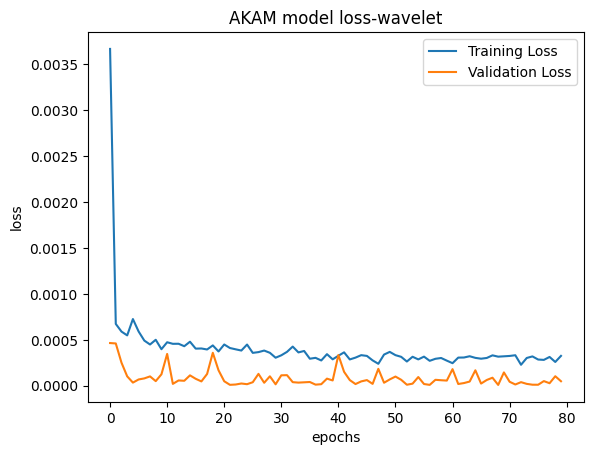

In [111]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

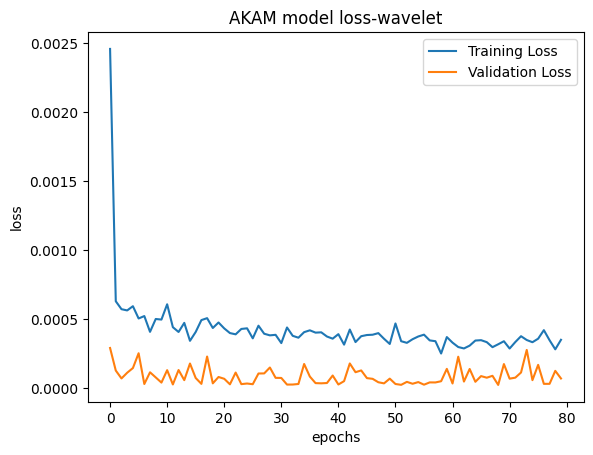

In [118]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

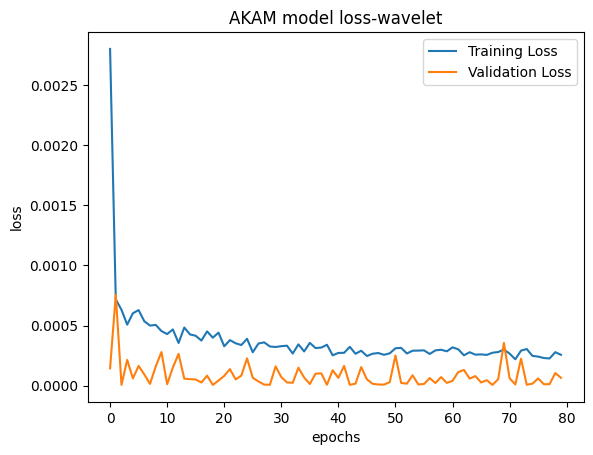

In [125]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

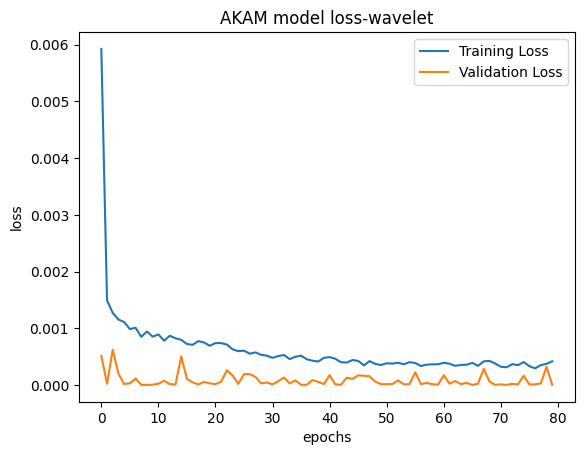

In [130]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [132]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_CNN/{ticker}_model_{study_naam}_{wavelet_name}({detail_index})')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_CNN/AKAM_model_wavelet_db4(7)/assets


INFO:tensorflow:Assets written to: saved_model_CNN/AKAM_model_wavelet_db4(7)/assets


In [112]:
best_model.summary()

Model: "sequential_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_354 (LSTM)             (None, 10, 60)            14880     
                                                                 
 dropout_354 (Dropout)       (None, 10, 60)            0         
                                                                 
 lstm_355 (LSTM)             (None, 10, 60)            29040     
                                                                 
 dropout_355 (Dropout)       (None, 10, 60)            0         
                                                                 
 lstm_356 (LSTM)             (None, 10, 60)            29040     
                                                                 
 dropout_356 (Dropout)       (None, 10, 60)            0         
                                                                 
 lstm_357 (LSTM)             (None, 60)              

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [113]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="LSTM"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [119]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="LSTM"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [126]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="LSTM"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


In [131]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['Close']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="LSTM"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************


#### TSLA - Filtered(MSTL)

##### Start Tuning

In [ ]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="TSLA" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="MSTL" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="MSTL"
detail_index=0
wavelet_name="db4"
approx_enable=True
threshold_enable=False
thresh_value=0
mstl_period=[7]
abc(ticker,n_trial,filter,study_naam,batch_size_no,attn,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value,mstl_period)

[I 2024-12-02 11:52:43,550] A new study created in memory with name: mstl
2024-12-02 11:52:44.902007: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14031 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:65:00.0, compute capability: 8.6
2024-12-02 11:52:46.145986: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-02 11:52:46.148606: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2024-12-02 11:52:46.148646: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2024-12-02 11:52:46.148730: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pas

Epoch 1/10


2024-12-02 11:52:49.114097: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-12-02 11:52:49.441480: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-02 11:52:49.443098: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2024-12-02 11:52:49.443670: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-02 11:52:49.444215: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.24

15/90 [====>.........................] - ETA: 0s - loss: 4.7412e-05 

2024-12-02 11:52:51.278270: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-02 11:52:51.306395: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



90/90 [==============================] - 6s 16ms/step - loss: 0.0059 - val_loss: 0.0048
Epoch 2/10
90/90 [==============================] - 1s 10ms/step - loss: 0.0067 - val_loss: 0.0041
Epoch 3/10
90/90 [==============================] - 1s 9ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 4/10
90/90 [==============================] - 1s 9ms/step - loss: 0.0055 - val_loss: 0.0095
Epoch 5/10
90/90 [==============================] - 1s 10ms/step - loss: 0.0045 - val_loss: 0.0195
Epoch 6/10
90/90 [==============================] - 1s 10ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 7/10
90/90 [==============================] - 1s 10ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 8/10
90/90 [==============================] - 1s 10ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 9/10
90/90 [==============================] - 1s 10ms/step - loss: 0.0056 - val_loss: 0.0016
Epoch 10/10
90/90 [==============================] - 1s 10ms/step - loss: 0.0039 - val_loss: 0.0107


[I 2024-12-02 11:53:00,580] Trial 0 finished with value: 0.0013208534801378846 and parameters: {'win_size': 40, 'epoch_no': 10, 'split_size': 0.2, 'units': 60, 'drop_out': 0.5}. Best is trial 0 with value: 0.0013208534801378846.


loss value [0.004839727189391851, 0.004131915047764778, 0.001882300479337573, 0.009482579305768013, 0.01948384940624237, 0.0013208534801378846, 0.0013252238277345896, 0.006593830417841673, 0.0016331238439306617, 0.01068071834743023]
Epoch 1/30
 1/68 [..............................] - ETA: 2:39 - loss: 2.2075e-07

2024-12-02 11:53:03.221611: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-02 11:53:03.338208: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-12-02 11:53:03.338472: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



68/68 [==============================] - 4s 18ms/step - loss: 6.2392e-05 - val_loss: 0.1890
Epoch 2/30
68/68 [==============================] - 1s 10ms/step - loss: 2.0062e-04 - val_loss: 0.2046
Epoch 3/30
68/68 [==============================] - 1s 10ms/step - loss: 1.6443e-04 - val_loss: 0.2119
Epoch 4/30
68/68 [==============================] - 1s 9ms/step - loss: 2.1413e-04 - val_loss: 0.2212
Epoch 5/30
68/68 [==============================] - 1s 9ms/step - loss: 2.5072e-04 - val_loss: 0.2134
Epoch 6/30
68/68 [==============================] - 1s 10ms/step - loss: 3.5332e-04 - val_loss: 0.2183
Epoch 7/30
68/68 [==============================] - 1s 10ms/step - loss: 3.9601e-04 - val_loss: 0.2109
Epoch 8/30
68/68 [==============================] - 1s 9ms/step - loss: 4.4407e-04 - val_loss: 0.2204
Epoch 9/30
68/68 [==============================] - 1s 10ms/step - loss: 4.0949e-04 - val_loss: 0.2071
Epoch 10/30
68/68 [==============================] - 1s 10ms/step - loss: 3.8335e-04 - 

[I 2024-12-02 11:53:11,163] Trial 1 finished with value: 0.18901915848255157 and parameters: {'win_size': 20, 'epoch_no': 30, 'split_size': 0.4, 'units': 70, 'drop_out': 0.30000000000000004}. Best is trial 0 with value: 0.0013208534801378846.


loss value [0.18901915848255157, 0.20457500219345093, 0.21191009879112244, 0.221239373087883, 0.2133542150259018, 0.2183222621679306, 0.21094796061515808, 0.22040684521198273, 0.20709723234176636, 0.21935489773750305, 0.21560440957546234]
Best parameters: for mstl filter {'win_size': 40, 'epoch_no': 10, 'split_size': 0.2, 'units': 60, 'drop_out': 0.5}
Best value: for mstl filter 0.0013208534801378846
    win_size: 40
    epoch_no: 10
    split_size: 0.2
    units: 60
    drop_out: 0.5


({'win_size': 40,
  'epoch_no': 10,
  'split_size': 0.2,
  'units': 60,
  'drop_out': 0.5},
 0.0013208534801378846)

##### Optuna plot

In [47]:
optuna.visualization.plot_optimization_history(study_lstm)

In [48]:
# optuna-dashboard sqlite:///db.sqlite3

optuna.visualization.plot_slice(study_lstm)

##### Best parameter values

In [49]:
study_lstm.best_trial.params

{'win_size': 40,
 'epoch_no': 10,
 'split_size': 0.2,
 'units': 60,
 'drop_out': 0.5}

##### After hyperparameter tuning - Train model with best values

In [50]:
win_size=study_lstm.best_trial.params['win_size']
pred_step=10
epoch_no=study_lstm.best_trial.params['epoch_no']
batch_size_no=32
split_size=round(study_lstm.best_trial.params['split_size'],2)
attn=False
units=study_lstm.best_trial.params['units']
drop_out=round(study_lstm.best_trial.params['drop_out'],2)
n_trial=0
best_model = build_model(win_size,drop_out,units,split_size)
# print(f"**********************{study_naam} filter*************************")

scaled_data_unfilt = scaler.transform(tesla_data[['Close']].values)
X_unfilt,y_unfilt = create_sequences(scaled_data_unfilt,study_lstm.best_trial.params['win_size'])
X_test_unfilt = X_unfilt[-len(X_test):]
y_test_unfilt = y_unfilt[-len(y_test):]

history = best_model.fit(X_train, y_train, epochs=epoch_no, batch_size=32, validation_data=(X_test_unfilt, y_test_unfilt))
# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

Epoch 1/10
90/90 [==============================] - 4s 16ms/step - loss: 0.0049 - val_loss: 0.0088
Epoch 2/10
90/90 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 3/10
90/90 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 4/10
90/90 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 5/10
90/90 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 6/10
90/90 [==============================] - 1s 10ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 7/10
90/90 [==============================] - 1s 10ms/step - loss: 0.0012 - val_loss: 0.0040
Epoch 8/10
90/90 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 9/10
90/90 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 10/10
90/90 [==============================] - 1s 10ms/step - loss: 0.0014 - val_loss: 0.0024


##### Evaluate trained model

In [51]:
X_test_unfilt.shape

(719, 40)

In [52]:
type(X_test_unfilt)

numpy.ndarray

In [53]:
X_test_unfilt

array([[0.94106936, 0.94700189, 0.91799464, ..., 0.87423682, 0.84456565,
        0.84509336],
       [0.94700189, 0.91799464, 0.96486761, ..., 0.84456565, 0.84509336,
        0.80051849],
       [0.91799464, 0.96486761, 0.97148106, ..., 0.84509336, 0.80051849,
        0.78868748],
       ...,
       [0.65595868, 0.6329776 , 0.61163068, ..., 0.86437202, 0.89736266,
        0.86169084],
       [0.6329776 , 0.61163068, 0.63568426, ..., 0.89736266, 0.86169084,
        0.86077163],
       [0.61163068, 0.63568426, 0.61206477, ..., 0.86169084, 0.86077163,
        0.84713618]])

In [54]:
# scaled_data_org = scaler.transform(tesla_data[['Close']].values)
# X_test,y_test = create_sequences(scaled_data_org,study_lstm.best_trial.params['win_size'])
evaluate_model(best_model,X_test_unfilt,y_test_unfilt, filter)

23/23 [==============================] - 1s 3ms/step
**********************mstl filter***************************
Mean Absolute Percentage Error (MAPE): 0.07%
Mean Absolute Error (MAE): 15.10
Root Mean Squared Error (RMSE): 19.20
R2 Score: 0.86


##### Val and training loss plot

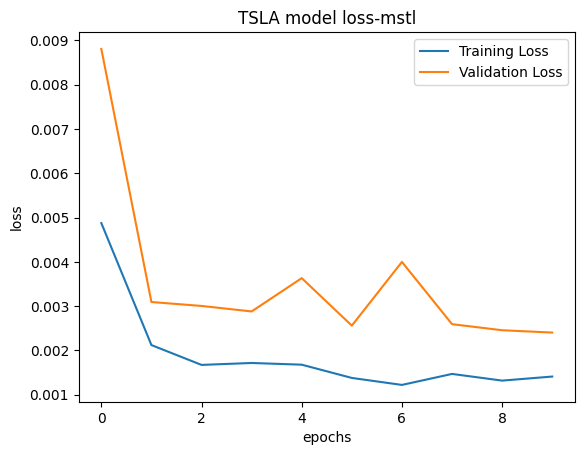

In [55]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [ ]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'TSLA_model_hyperparameter_{filter}.keras')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

In [56]:
best_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 40, 60)            14880     
                                                                 
 dropout_4 (Dropout)         (None, 40, 60)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60)                29040     
                                                                 
 dropout_5 (Dropout)         (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 61        
                                                                 
Total params: 43981 (171.80 KB)
Trainable params: 43981 (171.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

****************************TEST************************************


<Figure size 1000x600 with 0 Axes>

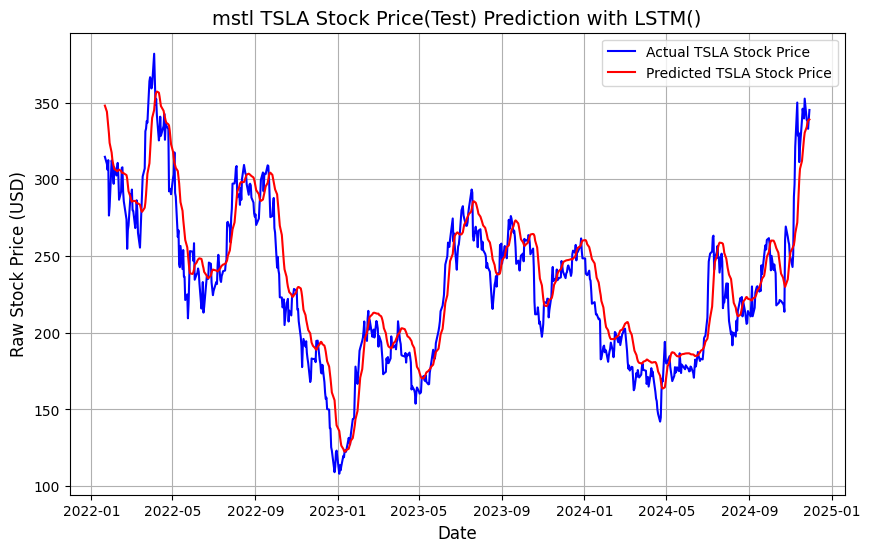

In [57]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
model_name="LSTM"
plot_simple(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw)

#### TSLA - Filtered(STL)

##### Start Tuning

In [ ]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="TSLA" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="STL" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="STL"
detail_index=0
wavelet_name="db4"
approx_enable=True
threshold_enable=False
thresh_value=0
mstl_period=[7]
stl_period=30
abc(ticker,n_trial,filter,study_naam,batch_size_no,attn,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value,mstl_period,stl_period)

##### Optuna plot

In [ ]:
optuna.visualization.plot_optimization_history(study_lstm)

In [ ]:
# optuna-dashboard sqlite:///db.sqlite3

optuna.visualization.plot_slice(study_lstm)

##### Best parameter values

In [ ]:
study_lstm.best_trial.params

##### After hyperparameter tuning - Train model with best values

In [ ]:
win_size=study_lstm.best_trial.params['win_size']
pred_step=10
epoch_no=study_lstm.best_trial.params['epoch_no']
batch_size_no=32
split_size=round(study_lstm.best_trial.params['split_size'],2)
attn=False
units=study_lstm.best_trial.params['units']
drop_out=round(study_lstm.best_trial.params['drop_out'],2)
n_trial=0
best_model = build_model(win_size,drop_out,units,split_size)
# print(f"**********************{study_naam} filter*************************")

scaled_data_unfilt = scaler.transform(tesla_data[['Close']].values)
X_unfilt,y_unfilt = create_sequences(scaled_data_unfilt,study_lstm.best_trial.params['win_size'])
X_test_unfilt = X_unfilt[-len(X_test):]
y_test_unfilt = y_unfilt[-len(y_test):]

history = best_model.fit(X_train, y_train, epochs=epoch_no, batch_size=32, validation_data=(X_test_unfilt, y_test_unfilt))
# abc("TSLA",win_size,pred_step,units,drop_out,n_trial,epoch_no,batch_size_no,split_size,attn)

##### Evaluate trained model

In [ ]:
X_test_unfilt.shape

(719, 40)

In [ ]:
type(X_test_unfilt)

numpy.ndarray

In [ ]:
X_test_unfilt

In [ ]:
# scaled_data_org = scaler.transform(tesla_data[['Close']].values)
# X_test,y_test = create_sequences(scaled_data_org,study_lstm.best_trial.params['win_size'])
evaluate_model(best_model,X_test_unfilt,y_test_unfilt, filter)

##### Val and training loss plot

In [ ]:
#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} model loss-{study_naam}')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save model

In [ ]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'TSLA_model_hyperparameter_{filter}.keras')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

In [ ]:
best_model.summary()

##### Load model

In [ ]:
new_model = tf.keras.models.load_model('TSLA_model_hyperparameter.keras')

##### Plot 

In [ ]:
if attn:
    a = "attention"
else:
    a = ""

print("****************************TEST************************************")
model_name="LSTM"
plot_simple(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw,10,6)
plot_interative(tesla_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,y_raw, predicted_stock_price_raw)

In [ ]:
rt_fft = tf.signal.fft(tesla_data['Close'])
fft = tf.signal.rfft(tesla_data[['Close']])
np.fft.fft(tesla_data['Close'])
recovered = tf.signal.ifft(rt_fft)
#plot tesla_data['Close] and recovered with x axis as tesla_data.index
plt.figure(figsize=(16,8))
plt.plot(tesla_data.index,tesla_data['Close'], label='Org Price', color='blue')
plt.plot(tesla_data.index,recovered, label='Rec Price', color='green')
plt.title('Tesla Stock Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


In [72]:
len(tesla_data['Close'])

5534

In [ ]:
# import scipy.fft as fft
# # Generate a time-domain signal
# t = np.linspace(0, 1, 1000)
# x = np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 20 * t)

# # Calculate the Fourier Transform
# X = fft.fft(tesla_data['Close'].values)
# freqs = fft.fftfreq(tesla_data['Close'].size,d=1)  # Calculate the frequencies

# from scipy import signal
# sos = signal.butter(2, 0.001, 'low', analog=False,output='sos')
# filtered = signal.sosfilt(sos, tesla_data[['Close']])
# # w, h = signal.freqs(b, a)

# # Plot the frequency-domain representation of the signal
# import matplotlib.pyplot as plt
# plt.plot(freqs, np.abs(X))
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Amplitude')
# plt.xlim([0, 50])  # Display frequencies from 0 to 50 Hz for clarity
# plt.show()

# #Plot the filtered data
# plt.figure(figsize=(10,6))
# plt.plot(tesla_data.index,filtered,label="filtered")
# plt.plot(tesla_data.index,tesla_data[['Close']],label="Actual")
# plt.title('Filtered Data')
# plt.xlabel('Time')
# plt.ylabel('Amplitude')
# plt.legend()
# plt.show()


#### AKAM - Proposed Filter(hybrid) - fourier_wavelet

In [30]:
# win_size=20
# pred_step=10
# epoch_no=2
batch_size_no=32
# split_size=0.2
attn=False
# units=50
# drop_out=0.2
n_trial=2
ticker="AKAM" #Cyient.NS, GAIL.NS, INFY.NS, TCS.NS, RELIANCE.NS
filter="hybrid" # kalman, fourier, SMA, EMA, MACD, wavelet
# abc(ticker,win_size,pred_step,units,drop_out,n_trial,filter,epoch_no,batch_size_no,split_size,attn)
study_naam="hybrid"
tuning=False
stock_file_name="AKAM_autoencoder_data.csv"
detail_index=8
#'haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus',
# 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor'
wavelet_name="dmey"
approx_enable=False
threshold_enable=False
thresh_value=0
abc(stock_file_name,ticker,n_trial,filter,f"{study_naam}",tuning,detail_index,wavelet_name,approx_enable,threshold_enable,thresh_value)

In [31]:
win_size= 10 #study_cnn.best_trial.params['win_size']
epoch_no= 100 #study_cnn.best_trial.params['epoch_no']
drop_out= 0.4 #round(study_cnn.best_trial.params['drop_out'],2)
units= 30 #study_cnn.best_trial.params['units']
split_size= 0.4 #round(study_cnn.best_trial.params['split_size'],2)
optimizer_options ='nadam' #study_cnn.best_trial.params['optimizer_name']
num_of_layers= 2 #study_cnn.best_trial.params['no_layers']  
loss_option= 'log_cosh' #study_cnn.best_trial.params['loss_fn_name']
actv_option= 'gelu' #study_cnn.best_trial.params['activation_name']
filter_size= 64 #study_cnn.best_trial.params['filter_size']
kernel_size= 3 #study_cnn.best_trial.params['kernel_size']

# scaled_train_X, scaled_val_X, scaled_test_X, scaled_train_Y,scaled_val_Y,scaled_test_Y
best_model = build_model(win_size,drop_out,units,split_size,optimizer_options,num_of_layers,loss_option,actv_option)
# print(f"**********************{filter} filter*************************")
history = best_model.fit(scaled_train_X, scaled_train_Y, epochs=epoch_no, batch_size=32, validation_data=(scaled_val_X, scaled_val_Y))

unscaled X_train size (3795, 10)
scaled X_train size (3795, 10, 1) (3795,)


2025-01-08 11:15:03.997247: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13912 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:65:00.0, compute capability: 8.6
2025-01-08 11:15:04.201165: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-08 11:15:04.203221: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2025-01-08 11:15:04.203240: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-01-08 11:15:04.203282: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to comp

Epoch 1/100


2025-01-08 11:15:09.184753: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-01-08 11:15:09.423335: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-08 11:15:09.423779: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-08 11:15:09.424159: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-08 11:15:09.425509: W tensorflow/compiler/mlir/tools/

  1/119 [..............................] - ETA: 12:54 - loss: 0.0212

2025-01-08 11:15:11.395003: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-08 11:15:11.467648: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2025-01-08 11:15:11.539105: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



119/119 [==============================] - 9s 21ms/step - loss: 0.0022 - val_loss: 3.6384e-05
Epoch 2/100
119/119 [==============================] - 2s 13ms/step - loss: 0.0010 - val_loss: 8.4624e-08
Epoch 3/100
119/119 [==============================] - 2s 14ms/step - loss: 8.8702e-04 - val_loss: 8.2885e-06
Epoch 4/100
119/119 [==============================] - 2s 13ms/step - loss: 8.8048e-04 - val_loss: 3.2346e-05
Epoch 5/100
119/119 [==============================] - 2s 14ms/step - loss: 7.8677e-04 - val_loss: 1.4566e-06
Epoch 6/100
119/119 [==============================] - 2s 13ms/step - loss: 7.9843e-04 - val_loss: 2.4260e-05
Epoch 7/100
119/119 [==============================] - 2s 13ms/step - loss: 8.7026e-04 - val_loss: 9.1902e-06
Epoch 8/100
119/119 [==============================] - 2s 14ms/step - loss: 7.1599e-04 - val_loss: 2.4444e-06
Epoch 9/100
119/119 [==============================] - 2s 14ms/step - loss: 7.0312e-04 - val_loss: 2.1702e-06
Epoch 10/100
119/119 [========

##### Evaluate Trained Model

In [32]:
evaluate_model(best_model,scaled_test_X,scaled_test_Y, filter)

40/40 [==============================] - 1s 3ms/step
**********************hybrid filter***************************
Mean Absolute Percentage Error (MAPE): 0.12%
Mean Absolute Error (MAE): 0.22
Root Mean Squared Error (RMSE): 0.51
R2 Score: 0.67


##### Val and training plot loss

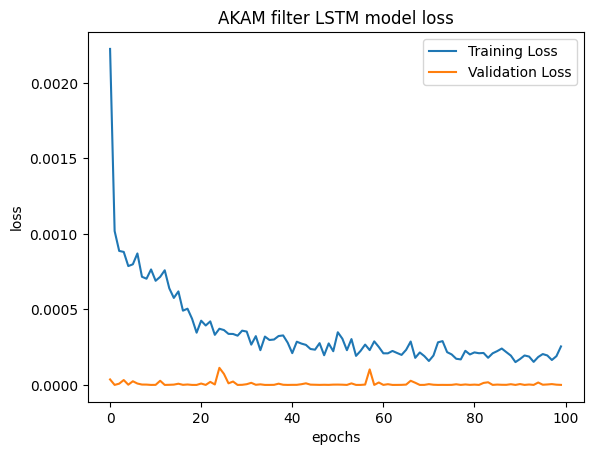

In [33]:

#Plot training and validation loss using history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{ticker} filter LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

##### Save Model

In [34]:
# Save the entire model as a `.keras` zip archive.
best_model.save(f'saved_model_LSTM/{ticker}_model_{study_naam}')

# Save the weights
# model.save_weights('./checkpoints/my_checkpoint')

# Create a new model instance
# model = create_model()

# Restore the weights
# model.load_weights('./checkpoints/my_checkpoint')

INFO:tensorflow:Assets written to: saved_model_LSTM/AKAM_model_hybrid/assets


INFO:tensorflow:Assets written to: saved_model_LSTM/AKAM_model_hybrid/assets


##### Plot

In [35]:
if attn:
    a = "attention"
else:
    a = ""
org_data_split(stock_data[['org_akam']].values,split_size,win_size)
print("****************************TEST************************************")
model_name="LSTM"
# plot_simple(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw,10,6)
plot_interative(stock_data,"test",f'{study_naam} {ticker} Stock Price(Test) Prediction with {model_name}({a})',ticker,Org_y_test, predicted_stock_price_raw)

****************************TEST************************************
